# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/data_obs.root')
file_sig = ROOT.RDataFrame('emu_tree', {'root_raw/em18_raw/ggH_bbtt*.root', 'root_raw/em18_raw/vbf_bbtt*.root'})
file_ZTT = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/embedded.root')
file_TT = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/TT*.root')

files = [file_obs, file_sig, file_ZTT, file_TT]

In [3]:
# 1b events
for i in range(len(files)):
    files[i] = files[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184 && bpt_deepcsv_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mymu+mymet).Pt(),(myele+mymu+mymet).Eta(),(myele+mymu+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
m_btt = '(mytt+myb1).M()'
m_b1e = '(myele+myb1).M()'
m_b1mu = '(mymu+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mymu)'
dR_b1e = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'


# define transverse masses mT and D_zeta
mT_e = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tt = 'sqrt(pow(mytt.Pt()+mymet.Pt(),2)-pow(mytt.Px()+mymet.Px(),2)-pow(mytt.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt(),2)+pow(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mymu.Px())*x_zeta+(myele.Py()+mymu.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'


# add defined variables to dataframe
for i in range(len(files)):
    files[i] = files[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1e', m_b1e)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1e', dR_b1e)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_e', mT_e)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tt', mT_tt)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
# 2018 e+mu trigger requirements
triggerMu8E23 = '(passMu8E23DZ && matchMu8E23DZ_1 && filterMu8E23DZ_1 && matchMu8E23DZ_2 && filterMu8E23DZ_2 && pt_1>24 && pt_2>13)'
triggerMu23E12 = '(passMu23E12DZ && matchMu23E12DZ_1 && filterMu23E12DZ_1 && matchMu23E12DZ_2 && filterMu23E12DZ_2 && pt_1>13 && pt_2>24)'

trigger = triggerMu8E23 + str(' or ') + triggerMu23E12

for i in range(len(files)):
    files[i] = files[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('iso_1<0.10 && iso_2<0.15')\
    .Filter('dR_tt>0.3')\
    .Filter(trigger)#same triggers for all

files[0] = files[0].Filter('Flag_eeBadScFilter==0')
files[2] = files[2].Filter('Flag_eeBadScFilter==0')

files[3] = files[3].Filter('(gen_match_1<3 or gen_match_1==6) && (gen_match_2<3 or gen_match_2==6)')

files[1] = files[1].Filter('gen_match_1==3 && gen_match_2==4')#recontructed taus are gen taus
files[1] = files[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)


# QCD region
qcd = files[0].Filter('q_1*q_2>0')

# signal region
for i in range(1,len(files)):
    files[i] = files[i].Filter('q_1*q_2<0')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'pt_2', 'm_btt', 'm_b1e', 'm_b1mu',\
                'dR_tt', 'dR_b1e', 'dR_b1mu', 'dR_b1tt',\
                'tt_pt', 'tt_eta', 'mT_e', 'mT_mu', 'mT_b1', 'mT_tt', 'norm_zeta', 'Dzeta',\
                'bpt_deepcsv_1', 'met', 'njets']


# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files)):
    files[i] = pd.DataFrame(files[i].AsNumpy(feature_list))
    print(i)
qcd = pd.DataFrame(qcd.AsNumpy(feature_list))
print('qcd')

# tag MC signal events as class 1
files[1]['label'] = np.ones((files[1].shape[0], 1))

# tag MC background events as class 0
files[2]['label'] = np.zeros((files[2].shape[0], 1))
files[3]['label'] = np.zeros((files[3].shape[0], 1))
qcd['label'] = np.zeros((qcd.shape[0],1))

for i in range(1,len(files)):
    print(str(files[i].shape))
print(str(qcd.shape))

1
2
3
qcd
(12171, 21)
(222049, 21)
(1729289, 21)
(7893, 21)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
files[2] = files[2].sample(n = 3000, random_state = 20)#Z->tautau
files[3] = files[3].sample(n = 4000, random_state = 20)#ttbar
qcd = qcd.sample(n = 5171, random_state = 20)


# collect all MC as one dataframe, separated from another datafream for observed data
#df_obs = files[0]
df_MC = [files[1], files[2], files[3], qcd]

df_MC = pd.concat(df_MC)


#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1       pt_2       m_btt       m_b1e      m_b1mu     dR_tt  \
0      32.766426  15.704816   87.354745   70.919945   49.357836  0.349437   
1      25.052036  17.893099   92.935893   69.188936   58.480897  0.332860   
2      15.301179  36.634205  108.660589   54.412048   78.771821  0.359545   
3      26.271544  15.743111   75.728072   78.679200   64.079880  0.333675   
4      32.425983  14.820876   43.810212   79.316565   55.644968  0.391901   
...          ...        ...         ...         ...         ...       ...   
694   108.338120  45.698906  286.505114  152.011876   86.039012  2.863715   
5074  119.629936  41.647972  736.355566  235.904812   75.334649  3.001610   
6290   14.274587  29.531235  213.907690   60.717490  105.779438  1.201759   
2511   29.841805  27.640680   80.146850   50.340124   54.700302  1.489394   
2673   55.406075  22.600222  221.565787  155.058307  106.225984  1.007485   

        dR_b1e   dR_b1mu   dR_b1tt       tt_pt  ...        

## Compare input feature distributions between sig and bkg

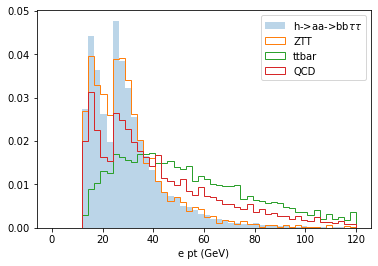

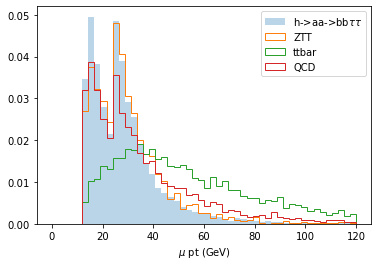

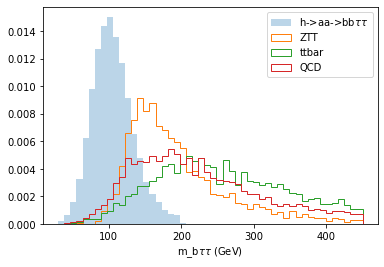

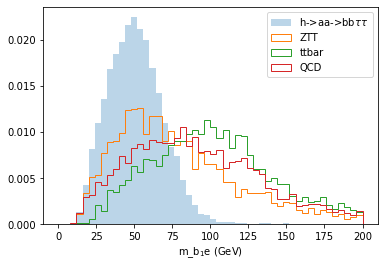

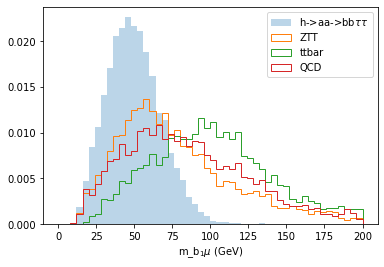

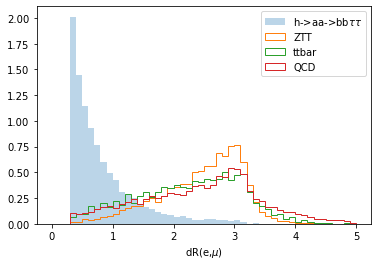

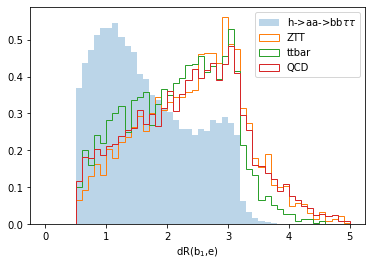

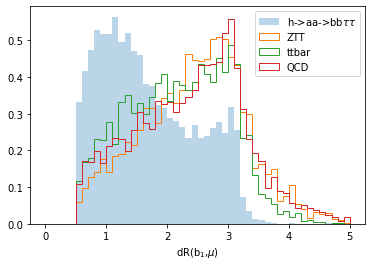

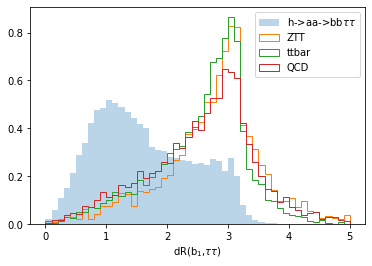

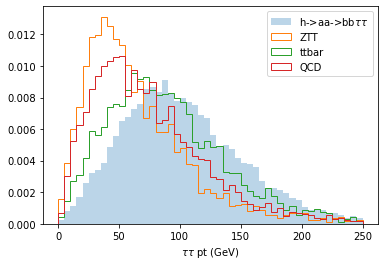

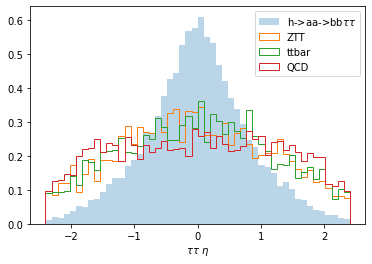

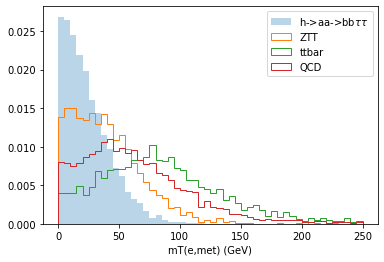

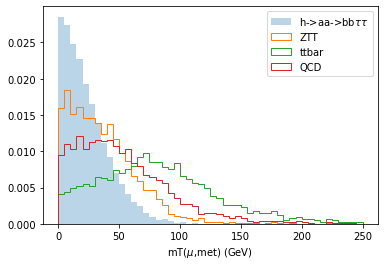

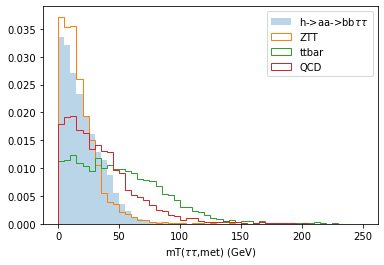

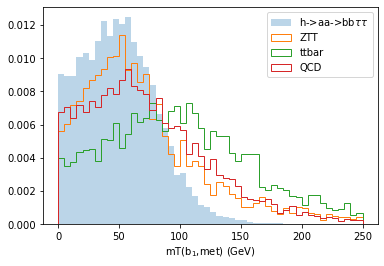

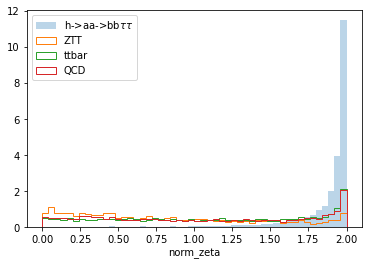

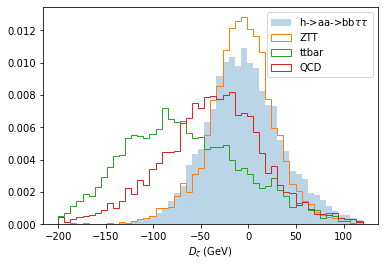

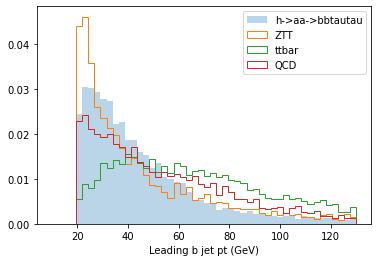

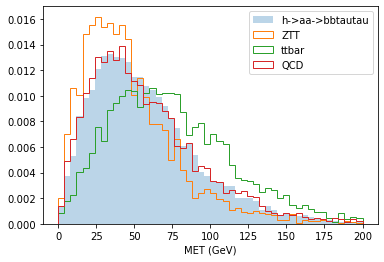

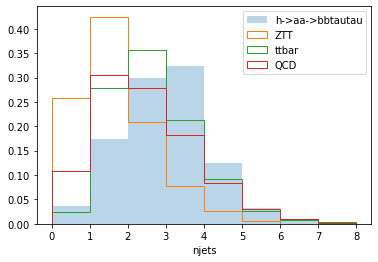

In [8]:
pyplot.hist(files[1]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()


pyplot.hist(files[1]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(files[1]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()


pyplot.hist(files[1]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()


pyplot.hist(files[1]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau\\tau$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'best')
pyplot.xlabel('norm_zeta')
pyplot.show()


pyplot.hist(files[1]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['met'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('MET (GeV)')
pyplot.show()

pyplot.hist(files[1]['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]


# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)


# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (14604, 20)
Y_train.shape: (14604, 1)
X_val.shape: (4869, 20)
Y_val.shape: (4869, 1)
X_test.shape: (4869, 20)
Y_test.shape: (4869, 1)

Total number of sig/bkg examples: 12171/12171 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 7398/7206 (50.7%/49.3%)
val   : 2416/2453 (49.6%/50.4%)
test  : 2357/2512 (48.4%/51.6%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 30,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-02-15 22:28:49.935143: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-15 22:28:49.936589: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val,Y_val), batch_size = 256)

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 41s - loss: 0.7949 - accuracy: 0.523 - ETA: 4s - loss: 0.7000 - accuracy: 0.599 - ETA: 2s - loss: 0.6237 - accuracy: 0.67 - ETA: 1s - loss: 0.5734 - accuracy: 0.71 - ETA: 0s - loss: 0.5305 - accuracy: 0.75 - ETA: 0s - loss: 0.4898 - accuracy: 0.78 - ETA: 0s - loss: 0.4533 - accuracy: 0.80 - ETA: 0s - loss: 0.4221 - accuracy: 0.81 - 1s 92us/sample - loss: 0.4126 - accuracy: 0.8252 - val_loss: 0.1795 - val_accuracy: 0.9392
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.91 - ETA: 0s - loss: 0.2417 - accuracy: 0.91 - ETA: 0s - loss: 0.2232 - accuracy: 0.92 - ETA: 0s - loss: 0.2236 - accuracy: 0.92 - ETA: 0s - loss: 0.2225 - accuracy: 0.92 - ETA: 0s - loss: 0.2188 - accuracy: 0.92 - ETA: 0s - loss: 0.2121 - accuracy: 0.92 - ETA: 0s - loss: 0.2109 - accuracy: 0.92 - ETA: 0s - loss: 0.2079 - accuracy: 0.92 - 1s 37us/sample - loss: 0.2067

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7088 - accuracy: 0.566 - ETA: 3s - loss: 0.6438 - accuracy: 0.631 - ETA: 1s - loss: 0.6015 - accuracy: 0.67 - ETA: 0s - loss: 0.5521 - accuracy: 0.71 - ETA: 0s - loss: 0.5155 - accuracy: 0.74 - ETA: 0s - loss: 0.4904 - accuracy: 0.76 - ETA: 0s - loss: 0.4683 - accuracy: 0.78 - 1s 72us/sample - loss: 0.4534 - accuracy: 0.7929 - val_loss: 0.2272 - val_accuracy: 0.9335
Epoch 2/2
14604/14604 [==============================] - ETA: 5s - loss: 0.3400 - accuracy: 0.87 - ETA: 0s - loss: 0.2912 - accuracy: 0.89 - ETA: 0s - loss: 0.2923 - accuracy: 0.89 - ETA: 0s - loss: 0.2841 - accuracy: 0.89 - ETA: 0s - loss: 0.2775 - accuracy: 0.90 - ETA: 0s - loss: 0.2717 - accuracy: 0.90 - ETA: 0s - loss: 0.2691 - accuracy: 0.90 - 1s 37us/sample - loss: 0.2634 - accuracy: 0.9050 - val_loss: 0.1683 - val_accuracy: 0.9388


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.6425 - accuracy: 0.664 - ETA: 3s - loss: 0.6147 - accuracy: 0.669 - ETA: 1s - loss: 0.5508 - accuracy: 0.73 - ETA: 0s - loss: 0.5051 - accuracy: 0.77 - ETA: 0s - loss: 0.4630 - accuracy: 0.80 - ETA: 0s - loss: 0.4323 - accuracy: 0.81 - ETA: 0s - loss: 0.4068 - accuracy: 0.83 - 1s 73us/sample - loss: 0.3921 - accuracy: 0.8387 - val_loss: 0.1983 - val_accuracy: 0.9263
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.91 - ETA: 0s - loss: 0.2286 - accuracy: 0.91 - ETA: 0s - loss: 0.2242 - accuracy: 0.91 - ETA: 0s - loss: 0.2138 - accuracy: 0.92 - ETA: 0s - loss: 0.2112 - accuracy: 0.92 - ETA: 0s - loss: 0.2097 - accuracy: 0.92 - ETA: 0s - loss: 0.2088 - accuracy: 0.92 - 3s 211us/sample - loss: 0.2083 - accuracy: 0.9228 - val_loss: 0.1568 - val_accuracy: 0.9378


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.6828 - accuracy: 0.554 - ETA: 3s - loss: 0.6025 - accuracy: 0.677 - ETA: 1s - loss: 0.5392 - accuracy: 0.74 - ETA: 0s - loss: 0.4968 - accuracy: 0.77 - ETA: 0s - loss: 0.4503 - accuracy: 0.80 - ETA: 0s - loss: 0.4135 - accuracy: 0.82 - ETA: 0s - loss: 0.3845 - accuracy: 0.83 - ETA: 0s - loss: 0.3622 - accuracy: 0.84 - 1s 75us/sample - loss: 0.3597 - accuracy: 0.8507 - val_loss: 0.1673 - val_accuracy: 0.9351
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.93 - ETA: 0s - loss: 0.2104 - accuracy: 0.92 - ETA: 0s - loss: 0.2028 - accuracy: 0.92 - ETA: 0s - loss: 0.1969 - accuracy: 0.93 - ETA: 0s - loss: 0.1926 - accuracy: 0.93 - ETA: 0s - loss: 0.1937 - accuracy: 0.93 - ETA: 0s - loss: 0.1953 - accuracy: 0.93 - ETA: 0s - loss: 0.1908 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1921 - accuracy: 0.9318 - val_loss: 0.1436 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7373 - accuracy: 0.511 - ETA: 2s - loss: 0.6677 - accuracy: 0.587 - ETA: 1s - loss: 0.6079 - accuracy: 0.65 - ETA: 0s - loss: 0.5603 - accuracy: 0.70 - ETA: 0s - loss: 0.5237 - accuracy: 0.73 - ETA: 0s - loss: 0.4933 - accuracy: 0.76 - ETA: 0s - loss: 0.4632 - accuracy: 0.78 - ETA: 0s - loss: 0.4362 - accuracy: 0.79 - 1s 73us/sample - loss: 0.4360 - accuracy: 0.7994 - val_loss: 0.2078 - val_accuracy: 0.9283
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.92 - ETA: 0s - loss: 0.2497 - accuracy: 0.91 - ETA: 0s - loss: 0.2470 - accuracy: 0.91 - ETA: 0s - loss: 0.2415 - accuracy: 0.91 - ETA: 0s - loss: 0.2382 - accuracy: 0.91 - ETA: 0s - loss: 0.2328 - accuracy: 0.91 - ETA: 0s - loss: 0.2295 - accuracy: 0.92 - ETA: 0s - loss: 0.2237 - accuracy: 0.92 - 1s 35us/sample - loss: 0.2219 - accuracy: 0.9226 - val_loss: 0.1544 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.6155 - accuracy: 0.652 - ETA: 3s - loss: 0.6107 - accuracy: 0.641 - ETA: 1s - loss: 0.5717 - accuracy: 0.68 - ETA: 1s - loss: 0.5349 - accuracy: 0.72 - ETA: 0s - loss: 0.4967 - accuracy: 0.75 - ETA: 0s - loss: 0.4639 - accuracy: 0.78 - ETA: 0s - loss: 0.4295 - accuracy: 0.80 - ETA: 0s - loss: 0.4048 - accuracy: 0.82 - 1s 75us/sample - loss: 0.4015 - accuracy: 0.8227 - val_loss: 0.1840 - val_accuracy: 0.9372
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.92 - ETA: 0s - loss: 0.2297 - accuracy: 0.91 - ETA: 0s - loss: 0.2183 - accuracy: 0.92 - ETA: 0s - loss: 0.2112 - accuracy: 0.92 - ETA: 0s - loss: 0.2097 - accuracy: 0.92 - ETA: 0s - loss: 0.2087 - accuracy: 0.92 - ETA: 0s - loss: 0.2047 - accuracy: 0.92 - ETA: 0s - loss: 0.2041 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2042 - accuracy: 0.9269 - val_loss: 0.1430 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8405 - accuracy: 0.406 - ETA: 2s - loss: 0.7510 - accuracy: 0.528 - ETA: 1s - loss: 0.6811 - accuracy: 0.60 - ETA: 0s - loss: 0.6195 - accuracy: 0.66 - ETA: 0s - loss: 0.5700 - accuracy: 0.71 - ETA: 0s - loss: 0.5292 - accuracy: 0.74 - ETA: 0s - loss: 0.4910 - accuracy: 0.76 - ETA: 0s - loss: 0.4631 - accuracy: 0.78 - 1s 73us/sample - loss: 0.4629 - accuracy: 0.7886 - val_loss: 0.2041 - val_accuracy: 0.9320
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.90 - ETA: 0s - loss: 0.2651 - accuracy: 0.90 - ETA: 0s - loss: 0.2520 - accuracy: 0.90 - ETA: 0s - loss: 0.2439 - accuracy: 0.91 - ETA: 0s - loss: 0.2393 - accuracy: 0.91 - ETA: 0s - loss: 0.2325 - accuracy: 0.91 - ETA: 0s - loss: 0.2274 - accuracy: 0.91 - ETA: 0s - loss: 0.2208 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2203 - accuracy: 0.9184 - val_loss: 0.1548 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7627 - accuracy: 0.457 - ETA: 2s - loss: 0.6664 - accuracy: 0.593 - ETA: 1s - loss: 0.6007 - accuracy: 0.67 - ETA: 0s - loss: 0.5439 - accuracy: 0.73 - ETA: 0s - loss: 0.4984 - accuracy: 0.76 - ETA: 0s - loss: 0.4679 - accuracy: 0.79 - ETA: 0s - loss: 0.4388 - accuracy: 0.80 - ETA: 0s - loss: 0.4152 - accuracy: 0.82 - 1s 77us/sample - loss: 0.4056 - accuracy: 0.8275 - val_loss: 0.1862 - val_accuracy: 0.9390
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.91 - ETA: 0s - loss: 0.2136 - accuracy: 0.93 - ETA: 0s - loss: 0.2120 - accuracy: 0.93 - ETA: 0s - loss: 0.2010 - accuracy: 0.93 - ETA: 0s - loss: 0.2006 - accuracy: 0.93 - ETA: 0s - loss: 0.1980 - accuracy: 0.93 - ETA: 0s - loss: 0.1913 - accuracy: 0.93 - ETA: 0s - loss: 0.1912 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1912 - accuracy: 0.9347 - val_loss: 0.1442 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.7814 - accuracy: 0.515 - ETA: 3s - loss: 0.6799 - accuracy: 0.590 - ETA: 1s - loss: 0.6183 - accuracy: 0.66 - ETA: 1s - loss: 0.5669 - accuracy: 0.71 - ETA: 0s - loss: 0.5250 - accuracy: 0.74 - ETA: 0s - loss: 0.4831 - accuracy: 0.77 - ETA: 0s - loss: 0.4488 - accuracy: 0.80 - ETA: 0s - loss: 0.4223 - accuracy: 0.81 - 1s 76us/sample - loss: 0.4086 - accuracy: 0.8237 - val_loss: 0.1837 - val_accuracy: 0.9380
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.93 - ETA: 0s - loss: 0.2027 - accuracy: 0.93 - ETA: 0s - loss: 0.2032 - accuracy: 0.93 - ETA: 0s - loss: 0.2054 - accuracy: 0.92 - ETA: 0s - loss: 0.2008 - accuracy: 0.93 - ETA: 0s - loss: 0.2015 - accuracy: 0.92 - ETA: 0s - loss: 0.1983 - accuracy: 0.93 - ETA: 0s - loss: 0.1987 - accuracy: 0.92 - 0s 34us/sample - loss: 0.1982 - accuracy: 0.9293 - val_loss: 0.1467 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7272 - accuracy: 0.472 - ETA: 3s - loss: 0.6080 - accuracy: 0.617 - ETA: 1s - loss: 0.5481 - accuracy: 0.69 - ETA: 0s - loss: 0.4996 - accuracy: 0.74 - ETA: 0s - loss: 0.4585 - accuracy: 0.77 - ETA: 0s - loss: 0.4234 - accuracy: 0.80 - ETA: 0s - loss: 0.3949 - accuracy: 0.82 - 1s 74us/sample - loss: 0.3688 - accuracy: 0.8374 - val_loss: 0.1657 - val_accuracy: 0.9374
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.91 - ETA: 0s - loss: 0.1938 - accuracy: 0.92 - ETA: 0s - loss: 0.1971 - accuracy: 0.92 - ETA: 0s - loss: 0.1943 - accuracy: 0.92 - ETA: 0s - loss: 0.1881 - accuracy: 0.93 - ETA: 0s - loss: 0.1856 - accuracy: 0.93 - ETA: 0s - loss: 0.1824 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1815 - accuracy: 0.9338 - val_loss: 0.1377 - val_accuracy: 0.9452


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7133 - accuracy: 0.476 - ETA: 2s - loss: 0.6355 - accuracy: 0.615 - ETA: 1s - loss: 0.5762 - accuracy: 0.69 - ETA: 0s - loss: 0.5213 - accuracy: 0.74 - ETA: 0s - loss: 0.4711 - accuracy: 0.78 - ETA: 0s - loss: 0.4335 - accuracy: 0.81 - ETA: 0s - loss: 0.3989 - accuracy: 0.82 - ETA: 0s - loss: 0.3741 - accuracy: 0.84 - 1s 73us/sample - loss: 0.3704 - accuracy: 0.8450 - val_loss: 0.1627 - val_accuracy: 0.9380
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.92 - ETA: 0s - loss: 0.2144 - accuracy: 0.92 - ETA: 0s - loss: 0.1995 - accuracy: 0.92 - ETA: 0s - loss: 0.1973 - accuracy: 0.92 - ETA: 0s - loss: 0.1917 - accuracy: 0.93 - ETA: 0s - loss: 0.1890 - accuracy: 0.93 - ETA: 0s - loss: 0.1827 - accuracy: 0.93 - ETA: 0s - loss: 0.1809 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1809 - accuracy: 0.9345 - val_loss: 0.1390 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 27s - loss: 0.7089 - accuracy: 0.527 - ETA: 2s - loss: 0.5915 - accuracy: 0.691 - ETA: 1s - loss: 0.5224 - accuracy: 0.75 - ETA: 0s - loss: 0.4710 - accuracy: 0.79 - ETA: 0s - loss: 0.4217 - accuracy: 0.82 - ETA: 0s - loss: 0.3908 - accuracy: 0.84 - ETA: 0s - loss: 0.3626 - accuracy: 0.85 - 1s 72us/sample - loss: 0.3461 - accuracy: 0.8638 - val_loss: 0.1584 - val_accuracy: 0.9411
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.92 - ETA: 0s - loss: 0.1865 - accuracy: 0.93 - ETA: 0s - loss: 0.1781 - accuracy: 0.93 - ETA: 0s - loss: 0.1785 - accuracy: 0.93 - ETA: 0s - loss: 0.1762 - accuracy: 0.93 - ETA: 0s - loss: 0.1750 - accuracy: 0.93 - ETA: 0s - loss: 0.1739 - accuracy: 0.93 - 0s 30us/sample - loss: 0.1729 - accuracy: 0.9378 - val_loss: 0.1339 - val_accuracy: 0.9484


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.8110 - accuracy: 0.519 - ETA: 3s - loss: 0.7493 - accuracy: 0.526 - ETA: 1s - loss: 0.6722 - accuracy: 0.58 - ETA: 0s - loss: 0.6146 - accuracy: 0.64 - ETA: 0s - loss: 0.5659 - accuracy: 0.69 - ETA: 0s - loss: 0.5233 - accuracy: 0.73 - ETA: 0s - loss: 0.4874 - accuracy: 0.76 - ETA: 0s - loss: 0.4587 - accuracy: 0.77 - 1s 76us/sample - loss: 0.4549 - accuracy: 0.7817 - val_loss: 0.1940 - val_accuracy: 0.9335
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.94 - ETA: 0s - loss: 0.2361 - accuracy: 0.92 - ETA: 0s - loss: 0.2328 - accuracy: 0.91 - ETA: 0s - loss: 0.2234 - accuracy: 0.92 - ETA: 0s - loss: 0.2145 - accuracy: 0.92 - ETA: 0s - loss: 0.2116 - accuracy: 0.92 - ETA: 0s - loss: 0.2060 - accuracy: 0.92 - ETA: 0s - loss: 0.2016 - accuracy: 0.93 - 1s 35us/sample - loss: 0.1997 - accuracy: 0.9304 - val_loss: 0.1438 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8074 - accuracy: 0.449 - ETA: 2s - loss: 0.6811 - accuracy: 0.572 - ETA: 1s - loss: 0.6067 - accuracy: 0.66 - ETA: 0s - loss: 0.5485 - accuracy: 0.71 - ETA: 0s - loss: 0.4992 - accuracy: 0.75 - ETA: 0s - loss: 0.4587 - accuracy: 0.78 - ETA: 0s - loss: 0.4257 - accuracy: 0.80 - ETA: 0s - loss: 0.3991 - accuracy: 0.82 - 1s 73us/sample - loss: 0.3988 - accuracy: 0.8211 - val_loss: 0.1752 - val_accuracy: 0.9372
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.90 - ETA: 0s - loss: 0.2203 - accuracy: 0.92 - ETA: 0s - loss: 0.2161 - accuracy: 0.92 - ETA: 0s - loss: 0.2047 - accuracy: 0.92 - ETA: 0s - loss: 0.2014 - accuracy: 0.92 - ETA: 0s - loss: 0.2018 - accuracy: 0.92 - ETA: 0s - loss: 0.1991 - accuracy: 0.92 - ETA: 0s - loss: 0.1971 - accuracy: 0.92 - 0s 34us/sample - loss: 0.1939 - accuracy: 0.9300 - val_loss: 0.1453 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.8068 - accuracy: 0.441 - ETA: 3s - loss: 0.7303 - accuracy: 0.544 - ETA: 1s - loss: 0.6711 - accuracy: 0.60 - ETA: 0s - loss: 0.6248 - accuracy: 0.65 - ETA: 0s - loss: 0.5865 - accuracy: 0.69 - ETA: 0s - loss: 0.5510 - accuracy: 0.72 - ETA: 0s - loss: 0.5204 - accuracy: 0.74 - ETA: 0s - loss: 0.4923 - accuracy: 0.76 - 1s 74us/sample - loss: 0.4921 - accuracy: 0.7656 - val_loss: 0.2482 - val_accuracy: 0.9170
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.89 - ETA: 0s - loss: 0.3056 - accuracy: 0.88 - ETA: 0s - loss: 0.2940 - accuracy: 0.88 - ETA: 0s - loss: 0.2768 - accuracy: 0.89 - ETA: 0s - loss: 0.2641 - accuracy: 0.89 - ETA: 0s - loss: 0.2559 - accuracy: 0.90 - ETA: 0s - loss: 0.2473 - accuracy: 0.90 - ETA: 0s - loss: 0.2405 - accuracy: 0.90 - 0s 33us/sample - loss: 0.2395 - accuracy: 0.9086 - val_loss: 0.1585 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.6974 - accuracy: 0.562 - ETA: 2s - loss: 0.6369 - accuracy: 0.618 - ETA: 1s - loss: 0.5652 - accuracy: 0.69 - ETA: 0s - loss: 0.5101 - accuracy: 0.74 - ETA: 0s - loss: 0.4709 - accuracy: 0.78 - ETA: 0s - loss: 0.4371 - accuracy: 0.80 - ETA: 0s - loss: 0.4081 - accuracy: 0.82 - 1s 74us/sample - loss: 0.3932 - accuracy: 0.8307 - val_loss: 0.1831 - val_accuracy: 0.9359
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.90 - ETA: 0s - loss: 0.2319 - accuracy: 0.92 - ETA: 0s - loss: 0.2241 - accuracy: 0.91 - ETA: 0s - loss: 0.2181 - accuracy: 0.92 - ETA: 0s - loss: 0.2141 - accuracy: 0.92 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.2045 - accuracy: 0.92 - 0s 29us/sample - loss: 0.2040 - accuracy: 0.9271 - val_loss: 0.1529 - val_accuracy: 0.9396


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7839 - accuracy: 0.460 - ETA: 2s - loss: 0.6713 - accuracy: 0.599 - ETA: 1s - loss: 0.6063 - accuracy: 0.66 - ETA: 0s - loss: 0.5454 - accuracy: 0.72 - ETA: 0s - loss: 0.5009 - accuracy: 0.76 - ETA: 0s - loss: 0.4662 - accuracy: 0.78 - ETA: 0s - loss: 0.4332 - accuracy: 0.80 - 1s 73us/sample - loss: 0.4102 - accuracy: 0.8187 - val_loss: 0.1798 - val_accuracy: 0.9335
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.92 - ETA: 0s - loss: 0.2346 - accuracy: 0.91 - ETA: 0s - loss: 0.2247 - accuracy: 0.91 - ETA: 0s - loss: 0.2146 - accuracy: 0.92 - ETA: 0s - loss: 0.2127 - accuracy: 0.92 - ETA: 0s - loss: 0.2082 - accuracy: 0.92 - ETA: 0s - loss: 0.2056 - accuracy: 0.92 - 0s 30us/sample - loss: 0.2044 - accuracy: 0.9272 - val_loss: 0.1464 - val_accuracy: 0.9419


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7054 - accuracy: 0.503 - ETA: 3s - loss: 0.6344 - accuracy: 0.640 - ETA: 1s - loss: 0.5727 - accuracy: 0.71 - ETA: 0s - loss: 0.5228 - accuracy: 0.76 - ETA: 0s - loss: 0.4760 - accuracy: 0.80 - ETA: 0s - loss: 0.4370 - accuracy: 0.82 - ETA: 0s - loss: 0.4057 - accuracy: 0.84 - ETA: 0s - loss: 0.3795 - accuracy: 0.85 - 1s 75us/sample - loss: 0.3751 - accuracy: 0.8548 - val_loss: 0.1676 - val_accuracy: 0.9392
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.92 - ETA: 0s - loss: 0.1900 - accuracy: 0.93 - ETA: 0s - loss: 0.1983 - accuracy: 0.93 - ETA: 0s - loss: 0.1970 - accuracy: 0.93 - ETA: 0s - loss: 0.1936 - accuracy: 0.93 - ETA: 0s - loss: 0.1926 - accuracy: 0.93 - ETA: 0s - loss: 0.1853 - accuracy: 0.93 - ETA: 0s - loss: 0.1829 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1824 - accuracy: 0.9362 - val_loss: 0.1424 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6643 - accuracy: 0.601 - ETA: 3s - loss: 0.6158 - accuracy: 0.662 - ETA: 1s - loss: 0.5646 - accuracy: 0.72 - ETA: 0s - loss: 0.5222 - accuracy: 0.76 - ETA: 0s - loss: 0.4856 - accuracy: 0.79 - ETA: 0s - loss: 0.4540 - accuracy: 0.81 - ETA: 0s - loss: 0.4236 - accuracy: 0.82 - ETA: 0s - loss: 0.4017 - accuracy: 0.83 - 1s 75us/sample - loss: 0.3989 - accuracy: 0.8402 - val_loss: 0.1908 - val_accuracy: 0.9312
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.92 - ETA: 0s - loss: 0.2258 - accuracy: 0.91 - ETA: 0s - loss: 0.2241 - accuracy: 0.92 - ETA: 0s - loss: 0.2179 - accuracy: 0.92 - ETA: 0s - loss: 0.2095 - accuracy: 0.92 - ETA: 0s - loss: 0.2085 - accuracy: 0.92 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2024 - accuracy: 0.9276 - val_loss: 0.1502 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7514 - accuracy: 0.476 - ETA: 3s - loss: 0.6468 - accuracy: 0.624 - ETA: 1s - loss: 0.5888 - accuracy: 0.69 - ETA: 0s - loss: 0.5371 - accuracy: 0.74 - ETA: 0s - loss: 0.4975 - accuracy: 0.78 - ETA: 0s - loss: 0.4623 - accuracy: 0.80 - ETA: 0s - loss: 0.4344 - accuracy: 0.81 - ETA: 0s - loss: 0.4032 - accuracy: 0.83 - 1s 75us/sample - loss: 0.3879 - accuracy: 0.8407 - val_loss: 0.1823 - val_accuracy: 0.9330
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.91 - ETA: 0s - loss: 0.2082 - accuracy: 0.93 - ETA: 0s - loss: 0.2009 - accuracy: 0.93 - ETA: 0s - loss: 0.1952 - accuracy: 0.93 - ETA: 0s - loss: 0.1936 - accuracy: 0.93 - ETA: 0s - loss: 0.1895 - accuracy: 0.93 - ETA: 0s - loss: 0.1866 - accuracy: 0.93 - ETA: 0s - loss: 0.1860 - accuracy: 0.93 - 1s 35us/sample - loss: 0.1859 - accuracy: 0.9330 - val_loss: 0.1410 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7659 - accuracy: 0.453 - ETA: 2s - loss: 0.6688 - accuracy: 0.564 - ETA: 1s - loss: 0.6250 - accuracy: 0.62 - ETA: 0s - loss: 0.5857 - accuracy: 0.67 - ETA: 0s - loss: 0.5564 - accuracy: 0.71 - ETA: 0s - loss: 0.5231 - accuracy: 0.74 - ETA: 0s - loss: 0.4955 - accuracy: 0.76 - ETA: 0s - loss: 0.4689 - accuracy: 0.78 - 1s 73us/sample - loss: 0.4687 - accuracy: 0.7882 - val_loss: 0.2317 - val_accuracy: 0.9361
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.92 - ETA: 0s - loss: 0.2532 - accuracy: 0.91 - ETA: 0s - loss: 0.2461 - accuracy: 0.92 - ETA: 0s - loss: 0.2367 - accuracy: 0.92 - ETA: 0s - loss: 0.2308 - accuracy: 0.92 - ETA: 0s - loss: 0.2276 - accuracy: 0.92 - ETA: 0s - loss: 0.2228 - accuracy: 0.92 - ETA: 0s - loss: 0.2203 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2199 - accuracy: 0.9249 - val_loss: 0.1534 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8382 - accuracy: 0.382 - ETA: 2s - loss: 0.7669 - accuracy: 0.463 - ETA: 1s - loss: 0.6969 - accuracy: 0.55 - ETA: 0s - loss: 0.6488 - accuracy: 0.61 - ETA: 0s - loss: 0.6019 - accuracy: 0.66 - ETA: 0s - loss: 0.5653 - accuracy: 0.70 - ETA: 0s - loss: 0.5322 - accuracy: 0.73 - ETA: 0s - loss: 0.4972 - accuracy: 0.75 - 1s 75us/sample - loss: 0.4860 - accuracy: 0.7640 - val_loss: 0.2012 - val_accuracy: 0.9372
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.92 - ETA: 0s - loss: 0.2506 - accuracy: 0.91 - ETA: 0s - loss: 0.2469 - accuracy: 0.91 - ETA: 0s - loss: 0.2411 - accuracy: 0.92 - ETA: 0s - loss: 0.2344 - accuracy: 0.92 - ETA: 0s - loss: 0.2317 - accuracy: 0.92 - ETA: 0s - loss: 0.2241 - accuracy: 0.92 - ETA: 0s - loss: 0.2215 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2210 - accuracy: 0.9261 - val_loss: 0.1460 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8021 - accuracy: 0.488 - ETA: 2s - loss: 0.7429 - accuracy: 0.521 - ETA: 1s - loss: 0.7020 - accuracy: 0.56 - ETA: 1s - loss: 0.6463 - accuracy: 0.62 - ETA: 0s - loss: 0.6054 - accuracy: 0.66 - ETA: 0s - loss: 0.5646 - accuracy: 0.70 - ETA: 0s - loss: 0.5316 - accuracy: 0.72 - ETA: 0s - loss: 0.5045 - accuracy: 0.75 - 1s 75us/sample - loss: 0.4906 - accuracy: 0.7627 - val_loss: 0.2340 - val_accuracy: 0.9265
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.90 - ETA: 0s - loss: 0.2900 - accuracy: 0.89 - ETA: 0s - loss: 0.2786 - accuracy: 0.89 - ETA: 0s - loss: 0.2648 - accuracy: 0.90 - ETA: 0s - loss: 0.2593 - accuracy: 0.90 - ETA: 0s - loss: 0.2509 - accuracy: 0.90 - ETA: 0s - loss: 0.2457 - accuracy: 0.90 - ETA: 0s - loss: 0.2426 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2426 - accuracy: 0.9114 - val_loss: 0.1567 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8934 - accuracy: 0.437 - ETA: 2s - loss: 0.8223 - accuracy: 0.495 - ETA: 1s - loss: 0.7545 - accuracy: 0.54 - ETA: 0s - loss: 0.7026 - accuracy: 0.59 - ETA: 0s - loss: 0.6529 - accuracy: 0.63 - ETA: 0s - loss: 0.6145 - accuracy: 0.67 - ETA: 0s - loss: 0.5762 - accuracy: 0.70 - 1s 70us/sample - loss: 0.5615 - accuracy: 0.7121 - val_loss: 0.2581 - val_accuracy: 0.9215
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.87 - ETA: 0s - loss: 0.3139 - accuracy: 0.88 - ETA: 0s - loss: 0.3043 - accuracy: 0.88 - ETA: 0s - loss: 0.2926 - accuracy: 0.89 - ETA: 0s - loss: 0.2833 - accuracy: 0.89 - ETA: 0s - loss: 0.2761 - accuracy: 0.89 - ETA: 0s - loss: 0.2709 - accuracy: 0.89 - 0s 30us/sample - loss: 0.2704 - accuracy: 0.8999 - val_loss: 0.1644 - val_accuracy: 0.9361


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8780 - accuracy: 0.335 - ETA: 2s - loss: 0.7776 - accuracy: 0.428 - ETA: 1s - loss: 0.7147 - accuracy: 0.50 - ETA: 0s - loss: 0.6626 - accuracy: 0.58 - ETA: 0s - loss: 0.6251 - accuracy: 0.63 - ETA: 0s - loss: 0.5919 - accuracy: 0.67 - ETA: 0s - loss: 0.5645 - accuracy: 0.69 - ETA: 0s - loss: 0.5355 - accuracy: 0.72 - 1s 76us/sample - loss: 0.5141 - accuracy: 0.7418 - val_loss: 0.2480 - val_accuracy: 0.9254
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.91 - ETA: 0s - loss: 0.2753 - accuracy: 0.90 - ETA: 0s - loss: 0.2571 - accuracy: 0.91 - ETA: 0s - loss: 0.2465 - accuracy: 0.91 - ETA: 0s - loss: 0.2381 - accuracy: 0.91 - ETA: 0s - loss: 0.2319 - accuracy: 0.91 - ETA: 0s - loss: 0.2268 - accuracy: 0.92 - ETA: 0s - loss: 0.2201 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2196 - accuracy: 0.9232 - val_loss: 0.1529 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7858 - accuracy: 0.480 - ETA: 2s - loss: 0.6663 - accuracy: 0.564 - ETA: 1s - loss: 0.5945 - accuracy: 0.65 - ETA: 0s - loss: 0.5397 - accuracy: 0.71 - ETA: 0s - loss: 0.4997 - accuracy: 0.75 - ETA: 0s - loss: 0.4635 - accuracy: 0.77 - ETA: 0s - loss: 0.4257 - accuracy: 0.80 - 1s 71us/sample - loss: 0.4092 - accuracy: 0.8135 - val_loss: 0.1778 - val_accuracy: 0.9361
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.92 - ETA: 0s - loss: 0.2187 - accuracy: 0.92 - ETA: 0s - loss: 0.2146 - accuracy: 0.92 - ETA: 0s - loss: 0.2129 - accuracy: 0.92 - ETA: 0s - loss: 0.2100 - accuracy: 0.92 - ETA: 0s - loss: 0.2005 - accuracy: 0.92 - ETA: 0s - loss: 0.1987 - accuracy: 0.92 - ETA: 0s - loss: 0.1958 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1959 - accuracy: 0.9300 - val_loss: 0.1443 - val_accuracy: 0.9419


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 30s - loss: 0.7991 - accuracy: 0.519 - ETA: 3s - loss: 0.7262 - accuracy: 0.548 - ETA: 1s - loss: 0.6628 - accuracy: 0.61 - ETA: 0s - loss: 0.6149 - accuracy: 0.66 - ETA: 0s - loss: 0.5773 - accuracy: 0.69 - ETA: 0s - loss: 0.5480 - accuracy: 0.72 - ETA: 0s - loss: 0.5173 - accuracy: 0.74 - ETA: 0s - loss: 0.4879 - accuracy: 0.76 - 1s 77us/sample - loss: 0.4848 - accuracy: 0.7703 - val_loss: 0.2291 - val_accuracy: 0.9257
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.92 - ETA: 0s - loss: 0.2659 - accuracy: 0.90 - ETA: 0s - loss: 0.2654 - accuracy: 0.90 - ETA: 0s - loss: 0.2628 - accuracy: 0.90 - ETA: 0s - loss: 0.2544 - accuracy: 0.90 - ETA: 0s - loss: 0.2502 - accuracy: 0.90 - ETA: 0s - loss: 0.2414 - accuracy: 0.91 - ETA: 0s - loss: 0.2373 - accuracy: 0.91 - 0s 34us/sample - loss: 0.2366 - accuracy: 0.9132 - val_loss: 0.1548 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.7259 - accuracy: 0.535 - ETA: 3s - loss: 0.6365 - accuracy: 0.619 - ETA: 1s - loss: 0.5790 - accuracy: 0.69 - ETA: 1s - loss: 0.5312 - accuracy: 0.74 - ETA: 0s - loss: 0.4910 - accuracy: 0.77 - ETA: 0s - loss: 0.4594 - accuracy: 0.79 - ETA: 0s - loss: 0.4344 - accuracy: 0.80 - ETA: 0s - loss: 0.4123 - accuracy: 0.82 - ETA: 0s - loss: 0.3896 - accuracy: 0.83 - 1s 79us/sample - loss: 0.3840 - accuracy: 0.8361 - val_loss: 0.1782 - val_accuracy: 0.9353
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.93 - ETA: 0s - loss: 0.2100 - accuracy: 0.92 - ETA: 0s - loss: 0.2054 - accuracy: 0.92 - ETA: 0s - loss: 0.2128 - accuracy: 0.92 - ETA: 0s - loss: 0.2078 - accuracy: 0.92 - ETA: 0s - loss: 0.2069 - accuracy: 0.92 - ETA: 0s - loss: 0.2030 - accuracy: 0.92 - ETA: 0s - loss: 0.1986 - accuracy: 0.92 - ETA: 0s - loss: 0.1984 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6933 - accuracy: 0.582 - ETA: 2s - loss: 0.6085 - accuracy: 0.676 - ETA: 1s - loss: 0.5551 - accuracy: 0.73 - ETA: 0s - loss: 0.5052 - accuracy: 0.77 - ETA: 0s - loss: 0.4643 - accuracy: 0.80 - ETA: 0s - loss: 0.4289 - accuracy: 0.82 - ETA: 0s - loss: 0.4034 - accuracy: 0.83 - ETA: 0s - loss: 0.3779 - accuracy: 0.84 - 1s 73us/sample - loss: 0.3777 - accuracy: 0.8491 - val_loss: 0.1759 - val_accuracy: 0.9357
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.94 - ETA: 0s - loss: 0.2114 - accuracy: 0.92 - ETA: 0s - loss: 0.2117 - accuracy: 0.92 - ETA: 0s - loss: 0.2059 - accuracy: 0.92 - ETA: 0s - loss: 0.1985 - accuracy: 0.92 - ETA: 0s - loss: 0.1975 - accuracy: 0.93 - ETA: 0s - loss: 0.1913 - accuracy: 0.93 - ETA: 0s - loss: 0.1908 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1908 - accuracy: 0.9323 - val_loss: 0.1413 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7631 - accuracy: 0.464 - ETA: 3s - loss: 0.6616 - accuracy: 0.590 - ETA: 1s - loss: 0.5827 - accuracy: 0.67 - ETA: 0s - loss: 0.5280 - accuracy: 0.72 - ETA: 0s - loss: 0.4819 - accuracy: 0.76 - ETA: 0s - loss: 0.4392 - accuracy: 0.79 - ETA: 0s - loss: 0.4088 - accuracy: 0.81 - ETA: 0s - loss: 0.3836 - accuracy: 0.82 - 1s 74us/sample - loss: 0.3835 - accuracy: 0.8291 - val_loss: 0.1771 - val_accuracy: 0.9341
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.91 - ETA: 0s - loss: 0.2045 - accuracy: 0.93 - ETA: 0s - loss: 0.2000 - accuracy: 0.92 - ETA: 0s - loss: 0.1972 - accuracy: 0.92 - ETA: 0s - loss: 0.1938 - accuracy: 0.92 - ETA: 0s - loss: 0.1907 - accuracy: 0.93 - ETA: 0s - loss: 0.1899 - accuracy: 0.93 - ETA: 0s - loss: 0.1886 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1886 - accuracy: 0.9312 - val_loss: 0.1421 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7221 - accuracy: 0.515 - ETA: 2s - loss: 0.6595 - accuracy: 0.573 - ETA: 1s - loss: 0.6053 - accuracy: 0.64 - ETA: 0s - loss: 0.5576 - accuracy: 0.69 - ETA: 0s - loss: 0.5183 - accuracy: 0.73 - ETA: 0s - loss: 0.4831 - accuracy: 0.76 - ETA: 0s - loss: 0.4554 - accuracy: 0.78 - ETA: 0s - loss: 0.4303 - accuracy: 0.80 - 1s 72us/sample - loss: 0.4302 - accuracy: 0.8029 - val_loss: 0.2007 - val_accuracy: 0.9355
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2641 - accuracy: 0.88 - ETA: 0s - loss: 0.2462 - accuracy: 0.91 - ETA: 0s - loss: 0.2364 - accuracy: 0.91 - ETA: 0s - loss: 0.2313 - accuracy: 0.91 - ETA: 0s - loss: 0.2273 - accuracy: 0.91 - ETA: 0s - loss: 0.2240 - accuracy: 0.91 - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.2146 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2137 - accuracy: 0.9226 - val_loss: 0.1525 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8586 - accuracy: 0.437 - ETA: 3s - loss: 0.7656 - accuracy: 0.481 - ETA: 1s - loss: 0.6821 - accuracy: 0.56 - ETA: 0s - loss: 0.6261 - accuracy: 0.63 - ETA: 0s - loss: 0.5781 - accuracy: 0.68 - ETA: 0s - loss: 0.5429 - accuracy: 0.71 - ETA: 0s - loss: 0.5087 - accuracy: 0.74 - ETA: 0s - loss: 0.4832 - accuracy: 0.76 - ETA: 0s - loss: 0.4562 - accuracy: 0.78 - 1s 78us/sample - loss: 0.4523 - accuracy: 0.7869 - val_loss: 0.1979 - val_accuracy: 0.9347
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2195 - accuracy: 0.92 - ETA: 0s - loss: 0.2249 - accuracy: 0.92 - ETA: 0s - loss: 0.2215 - accuracy: 0.92 - ETA: 0s - loss: 0.2177 - accuracy: 0.92 - ETA: 0s - loss: 0.2116 - accuracy: 0.92 - ETA: 0s - loss: 0.2070 - accuracy: 0.92 - ETA: 0s - loss: 0.2060 - accuracy: 0.92 - ETA: 0s - loss: 0.2048 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2047

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8921 - accuracy: 0.453 - ETA: 3s - loss: 0.7853 - accuracy: 0.488 - ETA: 1s - loss: 0.7156 - accuracy: 0.55 - ETA: 0s - loss: 0.6537 - accuracy: 0.62 - ETA: 0s - loss: 0.6028 - accuracy: 0.67 - ETA: 0s - loss: 0.5621 - accuracy: 0.70 - ETA: 0s - loss: 0.5255 - accuracy: 0.73 - ETA: 0s - loss: 0.4915 - accuracy: 0.76 - 1s 77us/sample - loss: 0.4875 - accuracy: 0.7632 - val_loss: 0.2251 - val_accuracy: 0.9269
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.89 - ETA: 0s - loss: 0.2646 - accuracy: 0.90 - ETA: 0s - loss: 0.2562 - accuracy: 0.91 - ETA: 0s - loss: 0.2449 - accuracy: 0.91 - ETA: 0s - loss: 0.2396 - accuracy: 0.91 - ETA: 0s - loss: 0.2351 - accuracy: 0.91 - ETA: 0s - loss: 0.2348 - accuracy: 0.91 - ETA: 0s - loss: 0.2274 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2251 - accuracy: 0.9210 - val_loss: 0.1595 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8505 - accuracy: 0.500 - ETA: 2s - loss: 0.7528 - accuracy: 0.555 - ETA: 1s - loss: 0.6936 - accuracy: 0.60 - ETA: 0s - loss: 0.6439 - accuracy: 0.64 - ETA: 0s - loss: 0.5989 - accuracy: 0.68 - ETA: 0s - loss: 0.5606 - accuracy: 0.71 - ETA: 0s - loss: 0.5313 - accuracy: 0.73 - ETA: 0s - loss: 0.5043 - accuracy: 0.75 - 1s 74us/sample - loss: 0.4970 - accuracy: 0.7586 - val_loss: 0.2245 - val_accuracy: 0.9300
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.88 - ETA: 0s - loss: 0.2948 - accuracy: 0.89 - ETA: 0s - loss: 0.2810 - accuracy: 0.89 - ETA: 0s - loss: 0.2681 - accuracy: 0.90 - ETA: 0s - loss: 0.2613 - accuracy: 0.90 - ETA: 0s - loss: 0.2535 - accuracy: 0.90 - ETA: 0s - loss: 0.2459 - accuracy: 0.91 - ETA: 0s - loss: 0.2404 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2405 - accuracy: 0.9145 - val_loss: 0.1574 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7598 - accuracy: 0.472 - ETA: 2s - loss: 0.6245 - accuracy: 0.634 - ETA: 1s - loss: 0.5378 - accuracy: 0.73 - ETA: 0s - loss: 0.4719 - accuracy: 0.78 - ETA: 0s - loss: 0.4238 - accuracy: 0.81 - ETA: 0s - loss: 0.3868 - accuracy: 0.83 - ETA: 0s - loss: 0.3570 - accuracy: 0.84 - 1s 70us/sample - loss: 0.3525 - accuracy: 0.8519 - val_loss: 0.1619 - val_accuracy: 0.9394
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.95 - ETA: 0s - loss: 0.1818 - accuracy: 0.93 - ETA: 0s - loss: 0.1816 - accuracy: 0.93 - ETA: 0s - loss: 0.1754 - accuracy: 0.93 - ETA: 0s - loss: 0.1781 - accuracy: 0.93 - ETA: 0s - loss: 0.1758 - accuracy: 0.93 - ETA: 0s - loss: 0.1764 - accuracy: 0.93 - 0s 29us/sample - loss: 0.1743 - accuracy: 0.9365 - val_loss: 0.1384 - val_accuracy: 0.9460


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7958 - accuracy: 0.515 - ETA: 2s - loss: 0.6688 - accuracy: 0.622 - ETA: 1s - loss: 0.6120 - accuracy: 0.68 - ETA: 0s - loss: 0.5655 - accuracy: 0.73 - ETA: 0s - loss: 0.5210 - accuracy: 0.76 - ETA: 0s - loss: 0.4834 - accuracy: 0.79 - ETA: 0s - loss: 0.4525 - accuracy: 0.80 - ETA: 0s - loss: 0.4251 - accuracy: 0.82 - 1s 76us/sample - loss: 0.4060 - accuracy: 0.8322 - val_loss: 0.1794 - val_accuracy: 0.9357
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.90 - ETA: 0s - loss: 0.2165 - accuracy: 0.92 - ETA: 0s - loss: 0.2081 - accuracy: 0.92 - ETA: 0s - loss: 0.1984 - accuracy: 0.92 - ETA: 0s - loss: 0.1973 - accuracy: 0.92 - ETA: 0s - loss: 0.1944 - accuracy: 0.93 - ETA: 0s - loss: 0.1910 - accuracy: 0.93 - ETA: 0s - loss: 0.1898 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1886 - accuracy: 0.9322 - val_loss: 0.1429 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7306 - accuracy: 0.453 - ETA: 3s - loss: 0.6585 - accuracy: 0.594 - ETA: 1s - loss: 0.5913 - accuracy: 0.68 - ETA: 0s - loss: 0.5337 - accuracy: 0.74 - ETA: 0s - loss: 0.4857 - accuracy: 0.78 - ETA: 0s - loss: 0.4408 - accuracy: 0.81 - ETA: 0s - loss: 0.4089 - accuracy: 0.82 - 1s 73us/sample - loss: 0.3853 - accuracy: 0.8402 - val_loss: 0.1755 - val_accuracy: 0.9347
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.94 - ETA: 0s - loss: 0.2124 - accuracy: 0.92 - ETA: 0s - loss: 0.2026 - accuracy: 0.92 - ETA: 0s - loss: 0.1953 - accuracy: 0.92 - ETA: 0s - loss: 0.1912 - accuracy: 0.93 - ETA: 0s - loss: 0.1868 - accuracy: 0.93 - ETA: 0s - loss: 0.1836 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1828 - accuracy: 0.9330 - val_loss: 0.1435 - val_accuracy: 0.9445


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 27s - loss: 0.6808 - accuracy: 0.496 - ETA: 2s - loss: 0.6506 - accuracy: 0.553 - ETA: 1s - loss: 0.6106 - accuracy: 0.61 - ETA: 0s - loss: 0.5706 - accuracy: 0.67 - ETA: 0s - loss: 0.5373 - accuracy: 0.71 - ETA: 0s - loss: 0.5039 - accuracy: 0.75 - ETA: 0s - loss: 0.4721 - accuracy: 0.77 - ETA: 0s - loss: 0.4419 - accuracy: 0.79 - 1s 73us/sample - loss: 0.4354 - accuracy: 0.8020 - val_loss: 0.1938 - val_accuracy: 0.9351
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.87 - ETA: 0s - loss: 0.2305 - accuracy: 0.92 - ETA: 0s - loss: 0.2212 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA: 0s - loss: 0.2083 - accuracy: 0.92 - ETA: 0s - loss: 0.2014 - accuracy: 0.92 - ETA: 0s - loss: 0.1968 - accuracy: 0.93 - ETA: 0s - loss: 0.1971 - accuracy: 0.92 - 0s 33us/sample - loss: 0.1966 - accuracy: 0.9299 - val_loss: 0.1478 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.6877 - accuracy: 0.566 - ETA: 2s - loss: 0.6096 - accuracy: 0.664 - ETA: 1s - loss: 0.5486 - accuracy: 0.73 - ETA: 0s - loss: 0.4966 - accuracy: 0.78 - ETA: 0s - loss: 0.4574 - accuracy: 0.80 - ETA: 0s - loss: 0.4225 - accuracy: 0.82 - ETA: 0s - loss: 0.3951 - accuracy: 0.84 - ETA: 0s - loss: 0.3721 - accuracy: 0.85 - 1s 73us/sample - loss: 0.3719 - accuracy: 0.8522 - val_loss: 0.1801 - val_accuracy: 0.9322
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.91 - ETA: 0s - loss: 0.2028 - accuracy: 0.92 - ETA: 0s - loss: 0.2065 - accuracy: 0.92 - ETA: 0s - loss: 0.2017 - accuracy: 0.92 - ETA: 0s - loss: 0.1985 - accuracy: 0.92 - ETA: 0s - loss: 0.1949 - accuracy: 0.92 - ETA: 0s - loss: 0.1931 - accuracy: 0.93 - ETA: 0s - loss: 0.1920 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1920 - accuracy: 0.9304 - val_loss: 0.1454 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 31s - loss: 0.7600 - accuracy: 0.523 - ETA: 3s - loss: 0.6886 - accuracy: 0.594 - ETA: 1s - loss: 0.6132 - accuracy: 0.66 - ETA: 0s - loss: 0.5642 - accuracy: 0.71 - ETA: 0s - loss: 0.5151 - accuracy: 0.75 - ETA: 0s - loss: 0.4801 - accuracy: 0.77 - ETA: 0s - loss: 0.4448 - accuracy: 0.80 - 1s 78us/sample - loss: 0.4302 - accuracy: 0.8117 - val_loss: 0.1986 - val_accuracy: 0.9380
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.89 - ETA: 0s - loss: 0.2487 - accuracy: 0.91 - ETA: 0s - loss: 0.2385 - accuracy: 0.91 - ETA: 0s - loss: 0.2270 - accuracy: 0.92 - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.2150 - accuracy: 0.92 - ETA: 0s - loss: 0.2061 - accuracy: 0.92 - ETA: 0s - loss: 0.2061 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2059 - accuracy: 0.9295 - val_loss: 0.1478 - val_accuracy: 0.9419


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 31s - loss: 0.7956 - accuracy: 0.488 - ETA: 3s - loss: 0.7012 - accuracy: 0.585 - ETA: 1s - loss: 0.6318 - accuracy: 0.65 - ETA: 0s - loss: 0.5748 - accuracy: 0.71 - ETA: 0s - loss: 0.5253 - accuracy: 0.76 - ETA: 0s - loss: 0.4893 - accuracy: 0.78 - ETA: 0s - loss: 0.4546 - accuracy: 0.80 - ETA: 0s - loss: 0.4268 - accuracy: 0.82 - 1s 77us/sample - loss: 0.4265 - accuracy: 0.8243 - val_loss: 0.1869 - val_accuracy: 0.9384
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.94 - ETA: 0s - loss: 0.2264 - accuracy: 0.93 - ETA: 0s - loss: 0.2187 - accuracy: 0.92 - ETA: 0s - loss: 0.2123 - accuracy: 0.92 - ETA: 0s - loss: 0.2102 - accuracy: 0.92 - ETA: 0s - loss: 0.2058 - accuracy: 0.92 - ETA: 0s - loss: 0.2003 - accuracy: 0.93 - ETA: 0s - loss: 0.1989 - accuracy: 0.93 - ETA: 0s - loss: 0.2000 - accuracy: 0.93 - 1s 36us/sample - loss: 0.1999

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 31s - loss: 0.8216 - accuracy: 0.359 - ETA: 3s - loss: 0.7172 - accuracy: 0.510 - ETA: 1s - loss: 0.6516 - accuracy: 0.60 - ETA: 0s - loss: 0.6032 - accuracy: 0.66 - ETA: 0s - loss: 0.5571 - accuracy: 0.71 - ETA: 0s - loss: 0.5170 - accuracy: 0.74 - ETA: 0s - loss: 0.4810 - accuracy: 0.77 - ETA: 0s - loss: 0.4494 - accuracy: 0.79 - 1s 77us/sample - loss: 0.4493 - accuracy: 0.7925 - val_loss: 0.1925 - val_accuracy: 0.9361
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.92 - ETA: 0s - loss: 0.2400 - accuracy: 0.91 - ETA: 0s - loss: 0.2242 - accuracy: 0.91 - ETA: 0s - loss: 0.2211 - accuracy: 0.92 - ETA: 0s - loss: 0.2142 - accuracy: 0.92 - ETA: 0s - loss: 0.2047 - accuracy: 0.92 - ETA: 0s - loss: 0.2006 - accuracy: 0.92 - ETA: 0s - loss: 0.1967 - accuracy: 0.92 - 0s 33us/sample - loss: 0.1970 - accuracy: 0.9286 - val_loss: 0.1419 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 29s - loss: 0.8638 - accuracy: 0.500 - ETA: 3s - loss: 0.7863 - accuracy: 0.536 - ETA: 1s - loss: 0.7146 - accuracy: 0.60 - ETA: 0s - loss: 0.6490 - accuracy: 0.66 - ETA: 0s - loss: 0.5954 - accuracy: 0.71 - ETA: 0s - loss: 0.5519 - accuracy: 0.74 - ETA: 0s - loss: 0.5187 - accuracy: 0.76 - ETA: 0s - loss: 0.4865 - accuracy: 0.78 - 1s 75us/sample - loss: 0.4829 - accuracy: 0.7882 - val_loss: 0.2120 - val_accuracy: 0.9351
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.87 - ETA: 0s - loss: 0.2797 - accuracy: 0.89 - ETA: 0s - loss: 0.2564 - accuracy: 0.91 - ETA: 0s - loss: 0.2436 - accuracy: 0.91 - ETA: 0s - loss: 0.2320 - accuracy: 0.92 - ETA: 0s - loss: 0.2260 - accuracy: 0.92 - ETA: 0s - loss: 0.2256 - accuracy: 0.92 - ETA: 0s - loss: 0.2213 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2224 - accuracy: 0.9249 - val_loss: 0.1530 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 29s - loss: 0.9485 - accuracy: 0.390 - ETA: 3s - loss: 0.8212 - accuracy: 0.458 - ETA: 1s - loss: 0.7430 - accuracy: 0.53 - ETA: 1s - loss: 0.6754 - accuracy: 0.61 - ETA: 0s - loss: 0.6198 - accuracy: 0.66 - ETA: 0s - loss: 0.5731 - accuracy: 0.71 - ETA: 0s - loss: 0.5318 - accuracy: 0.74 - ETA: 0s - loss: 0.4959 - accuracy: 0.76 - 1s 76us/sample - loss: 0.4695 - accuracy: 0.7831 - val_loss: 0.1931 - val_accuracy: 0.9382
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA: 0s - loss: 0.2199 - accuracy: 0.92 - ETA: 0s - loss: 0.2111 - accuracy: 0.92 - ETA: 0s - loss: 0.2066 - accuracy: 0.92 - ETA: 0s - loss: 0.1995 - accuracy: 0.93 - ETA: 0s - loss: 0.1946 - accuracy: 0.93 - ETA: 0s - loss: 0.1933 - accuracy: 0.93 - ETA: 0s - loss: 0.1902 - accuracy: 0.93 - 1s 34us/sample - loss: 0.1899 - accuracy: 0.9323 - val_loss: 0.1453 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7799 - accuracy: 0.418 - ETA: 3s - loss: 0.6694 - accuracy: 0.603 - ETA: 1s - loss: 0.6000 - accuracy: 0.69 - ETA: 0s - loss: 0.5421 - accuracy: 0.75 - ETA: 0s - loss: 0.4949 - accuracy: 0.78 - ETA: 0s - loss: 0.4520 - accuracy: 0.81 - ETA: 0s - loss: 0.4197 - accuracy: 0.82 - ETA: 0s - loss: 0.3918 - accuracy: 0.84 - 1s 75us/sample - loss: 0.3916 - accuracy: 0.8429 - val_loss: 0.1729 - val_accuracy: 0.9382
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.92 - ETA: 0s - loss: 0.2004 - accuracy: 0.93 - ETA: 0s - loss: 0.1912 - accuracy: 0.93 - ETA: 0s - loss: 0.1923 - accuracy: 0.93 - ETA: 0s - loss: 0.1908 - accuracy: 0.93 - ETA: 0s - loss: 0.1900 - accuracy: 0.93 - ETA: 0s - loss: 0.1849 - accuracy: 0.93 - ETA: 0s - loss: 0.1835 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1836 - accuracy: 0.9345 - val_loss: 0.1411 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7090 - accuracy: 0.593 - ETA: 3s - loss: 0.6453 - accuracy: 0.645 - ETA: 1s - loss: 0.5916 - accuracy: 0.69 - ETA: 0s - loss: 0.5465 - accuracy: 0.73 - ETA: 0s - loss: 0.5072 - accuracy: 0.76 - ETA: 0s - loss: 0.4767 - accuracy: 0.78 - ETA: 0s - loss: 0.4465 - accuracy: 0.80 - ETA: 0s - loss: 0.4228 - accuracy: 0.81 - 1s 75us/sample - loss: 0.4171 - accuracy: 0.8207 - val_loss: 0.2010 - val_accuracy: 0.9285
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.91 - ETA: 0s - loss: 0.2497 - accuracy: 0.90 - ETA: 0s - loss: 0.2462 - accuracy: 0.90 - ETA: 0s - loss: 0.2321 - accuracy: 0.91 - ETA: 0s - loss: 0.2285 - accuracy: 0.91 - ETA: 0s - loss: 0.2232 - accuracy: 0.92 - ETA: 0s - loss: 0.2211 - accuracy: 0.92 - ETA: 0s - loss: 0.2174 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2167 - accuracy: 0.9226 - val_loss: 0.1543 - v

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7097 - accuracy: 0.519 - ETA: 2s - loss: 0.6133 - accuracy: 0.675 - ETA: 1s - loss: 0.5219 - accuracy: 0.77 - ETA: 0s - loss: 0.4628 - accuracy: 0.81 - ETA: 0s - loss: 0.4089 - accuracy: 0.84 - ETA: 0s - loss: 0.3765 - accuracy: 0.85 - ETA: 0s - loss: 0.3491 - accuracy: 0.86 - 1s 72us/sample - loss: 0.3349 - accuracy: 0.8743 - val_loss: 0.1617 - val_accuracy: 0.9382
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.92 - ETA: 0s - loss: 0.1884 - accuracy: 0.93 - ETA: 0s - loss: 0.1786 - accuracy: 0.93 - ETA: 0s - loss: 0.1739 - accuracy: 0.93 - ETA: 0s - loss: 0.1727 - accuracy: 0.93 - ETA: 0s - loss: 0.1705 - accuracy: 0.93 - ETA: 0s - loss: 0.1684 - accuracy: 0.93 - 0s 30us/sample - loss: 0.1696 - accuracy: 0.9375 - val_loss: 0.1357 - val_accuracy: 0.9476
Epoch 7/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7066 - accuracy: 0.605 - ETA: 2s - loss: 0.6150 - accuracy: 0.674 - ETA: 1s - loss: 0.5557 - accuracy: 0.73 - ETA: 0s - loss: 0.5057 - accuracy: 0.77 - ETA: 0s - loss: 0.4707 - accuracy: 0.79 - ETA: 0s - loss: 0.4377 - accuracy: 0.81 - ETA: 0s - loss: 0.4092 - accuracy: 0.83 - ETA: 0s - loss: 0.3859 - accuracy: 0.84 - 1s 76us/sample - loss: 0.3741 - accuracy: 0.8489 - val_loss: 0.1827 - val_accuracy: 0.9333
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.89 - ETA: 0s - loss: 0.2280 - accuracy: 0.91 - ETA: 0s - loss: 0.2117 - accuracy: 0.92 - ETA: 0s - loss: 0.2035 - accuracy: 0.92 - ETA: 0s - loss: 0.2021 - accuracy: 0.92 - ETA: 0s - loss: 0.1978 - accuracy: 0.92 - ETA: 0s - loss: 0.1942 - accuracy: 0.92 - ETA: 0s - loss: 0.1923 - accuracy: 0.92 - 0s 33us/sample - loss: 0.1919 - accuracy: 0.9297 - val_loss: 0.1457 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7556 - accuracy: 0.582 - ETA: 3s - loss: 0.6789 - accuracy: 0.624 - ETA: 1s - loss: 0.6072 - accuracy: 0.70 - ETA: 0s - loss: 0.5469 - accuracy: 0.76 - ETA: 0s - loss: 0.5003 - accuracy: 0.79 - ETA: 0s - loss: 0.4635 - accuracy: 0.81 - ETA: 0s - loss: 0.4295 - accuracy: 0.83 - ETA: 0s - loss: 0.4027 - accuracy: 0.84 - 1s 76us/sample - loss: 0.3860 - accuracy: 0.8520 - val_loss: 0.1749 - val_accuracy: 0.9361
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2291 - accuracy: 0.89 - ETA: 0s - loss: 0.1911 - accuracy: 0.92 - ETA: 0s - loss: 0.1888 - accuracy: 0.93 - ETA: 0s - loss: 0.1910 - accuracy: 0.93 - ETA: 0s - loss: 0.1858 - accuracy: 0.93 - ETA: 0s - loss: 0.1819 - accuracy: 0.93 - ETA: 0s - loss: 0.1823 - accuracy: 0.93 - ETA: 0s - loss: 0.1794 - accuracy: 0.93 - 1s 34us/sample - loss: 0.1788 - accuracy: 0.9352 - val_loss: 0.1408 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7991 - accuracy: 0.410 - ETA: 2s - loss: 0.6854 - accuracy: 0.576 - ETA: 1s - loss: 0.6120 - accuracy: 0.67 - ETA: 0s - loss: 0.5549 - accuracy: 0.72 - ETA: 0s - loss: 0.4976 - accuracy: 0.76 - ETA: 0s - loss: 0.4566 - accuracy: 0.79 - ETA: 0s - loss: 0.4220 - accuracy: 0.81 - 1s 72us/sample - loss: 0.4024 - accuracy: 0.8248 - val_loss: 0.1757 - val_accuracy: 0.9349
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.94 - ETA: 0s - loss: 0.2059 - accuracy: 0.92 - ETA: 0s - loss: 0.2086 - accuracy: 0.92 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.1987 - accuracy: 0.93 - ETA: 0s - loss: 0.1956 - accuracy: 0.93 - ETA: 0s - loss: 0.1922 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1908 - accuracy: 0.9336 - val_loss: 0.1449 - val_accuracy: 0.9425
Epoch 7/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.6907 - accuracy: 0.554 - ETA: 2s - loss: 0.5543 - accuracy: 0.722 - ETA: 1s - loss: 0.4786 - accuracy: 0.78 - ETA: 0s - loss: 0.4236 - accuracy: 0.82 - ETA: 0s - loss: 0.3790 - accuracy: 0.84 - ETA: 0s - loss: 0.3493 - accuracy: 0.85 - ETA: 0s - loss: 0.3235 - accuracy: 0.87 - 1s 73us/sample - loss: 0.3090 - accuracy: 0.8784 - val_loss: 0.1486 - val_accuracy: 0.9439
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.90 - ETA: 0s - loss: 0.1702 - accuracy: 0.92 - ETA: 0s - loss: 0.1688 - accuracy: 0.93 - ETA: 0s - loss: 0.1658 - accuracy: 0.93 - ETA: 0s - loss: 0.1656 - accuracy: 0.93 - ETA: 0s - loss: 0.1676 - accuracy: 0.93 - ETA: 0s - loss: 0.1658 - accuracy: 0.93 - 0s 30us/sample - loss: 0.1668 - accuracy: 0.9382 - val_loss: 0.1327 - val_accuracy: 0.9482
Epoch 13/30
14604/14604 [==============================] - E

14604/14604 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.94 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - accuracy: 0.96 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - 0s 28us/sample - loss: 0.1206 - accuracy: 0.9569 - val_loss: 0.1049 - val_accuracy: 0.9610
Epoch 30/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - 0s 29us/sample - loss: 0.1202 - accuracy: 0.9551 - val_loss: 0.1020 - val_accuracy: 0.9622


Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7628 - accuracy: 0.519 - ETA: 3s - loss: 0.6991 - accuracy: 0.556 - ETA: 1s - loss: 0.6469 - accuracy: 0.61 - ETA: 0s - loss: 0.5873 - accuracy: 0.67 - ETA: 0s - loss: 0.5450 - accuracy: 0.72 - ETA: 0s - loss: 0.5017 - accuracy: 0.75 - ETA: 0s - loss: 0.4646 - accuracy: 0.78 - ETA: 0s - loss: 0.4355 - accuracy: 0.79 - 1s 74us/sample - loss: 0.4293 - accuracy: 0.8038 - val_loss: 0.1898 - val_accuracy: 0.9320
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.94 - ETA: 0s - loss: 0.2179 - accuracy: 0.92 - ETA: 0s - loss: 0.2072 - accuracy: 0.93 - ETA: 0s - loss: 0.1999 - accuracy: 0.93 - ETA: 0s - loss: 0.1992 - accuracy: 0.93 - ETA: 0s - loss: 0.1970 - accuracy: 0.93 - ETA: 0s - loss: 0.1976 - accuracy: 0.93 - ETA: 0s - loss: 0.1928 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1930 - accuracy: 0.9327 - val_loss: 0.1462

14604/14604 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.94 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1244 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1261 - accuracy: 0.9536 - val_loss: 0.1056 - val_accuracy: 0.9593
Epoch 29/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.1158 - accuracy: 0.96 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1253 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1251 - accuracy: 0.9544 - val_loss: 0.1049 - val_accuracy: 0.9597
Epoch 30/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.94 - ETA: 0s - loss: 0.1027 

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.6709 - accuracy: 0.605 - ETA: 3s - loss: 0.6466 - accuracy: 0.621 - ETA: 1s - loss: 0.5947 - accuracy: 0.67 - ETA: 0s - loss: 0.5462 - accuracy: 0.72 - ETA: 0s - loss: 0.5034 - accuracy: 0.76 - ETA: 0s - loss: 0.4703 - accuracy: 0.78 - ETA: 0s - loss: 0.4375 - accuracy: 0.80 - ETA: 0s - loss: 0.4113 - accuracy: 0.81 - 1s 73us/sample - loss: 0.4112 - accuracy: 0.8196 - val_loss: 0.1902 - val_accuracy: 0.9326
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - ETA: 0s - loss: 0.2346 - accuracy: 0.91 - ETA: 0s - loss: 0.2294 - accuracy: 0.91 - ETA: 0s - loss: 0.2239 - accuracy: 0.91 - ETA: 0s - loss: 0.2232 - accuracy: 0.91 - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - ETA: 0s - loss: 0.2107 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2074 - accuracy: 0.9229 - val_loss: 0.1494 - val_accuracy: 0.9404
Epoch 3/4
14604/14604 

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7224 - accuracy: 0.507 - ETA: 2s - loss: 0.6282 - accuracy: 0.635 - ETA: 1s - loss: 0.5797 - accuracy: 0.69 - ETA: 0s - loss: 0.5353 - accuracy: 0.73 - ETA: 0s - loss: 0.4917 - accuracy: 0.77 - ETA: 0s - loss: 0.4609 - accuracy: 0.79 - ETA: 0s - loss: 0.4264 - accuracy: 0.81 - ETA: 0s - loss: 0.3999 - accuracy: 0.82 - 1s 75us/sample - loss: 0.3897 - accuracy: 0.8306 - val_loss: 0.1695 - val_accuracy: 0.9361
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.91 - ETA: 0s - loss: 0.2219 - accuracy: 0.91 - ETA: 0s - loss: 0.2147 - accuracy: 0.92 - ETA: 0s - loss: 0.2067 - accuracy: 0.92 - ETA: 0s - loss: 0.1999 - accuracy: 0.92 - ETA: 0s - loss: 0.1953 - accuracy: 0.93 - ETA: 0s - loss: 0.1928 - accuracy: 0.93 - ETA: 0s - loss: 0.1899 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1888 - accuracy: 0.9333 - val_loss: 0.1406 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 29s - loss: 0.7652 - accuracy: 0.500 - ETA: 3s - loss: 0.6779 - accuracy: 0.578 - ETA: 1s - loss: 0.6396 - accuracy: 0.62 - ETA: 0s - loss: 0.5975 - accuracy: 0.67 - ETA: 0s - loss: 0.5648 - accuracy: 0.70 - ETA: 0s - loss: 0.5357 - accuracy: 0.73 - ETA: 0s - loss: 0.5037 - accuracy: 0.75 - ETA: 0s - loss: 0.4743 - accuracy: 0.77 - 1s 75us/sample - loss: 0.4705 - accuracy: 0.7755 - val_loss: 0.2357 - val_accuracy: 0.9203
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.88 - ETA: 0s - loss: 0.2831 - accuracy: 0.88 - ETA: 0s - loss: 0.2689 - accuracy: 0.89 - ETA: 0s - loss: 0.2606 - accuracy: 0.90 - ETA: 0s - loss: 0.2567 - accuracy: 0.90 - ETA: 0s - loss: 0.2545 - accuracy: 0.90 - ETA: 0s - loss: 0.2497 - accuracy: 0.90 - ETA: 0s - loss: 0.2485 - accuracy: 0.90 - 0s 32us/sample - loss: 0.2484 - accuracy: 0.9084 - val_loss: 0.1623 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8682 - accuracy: 0.472 - ETA: 2s - loss: 0.7679 - accuracy: 0.541 - ETA: 1s - loss: 0.6967 - accuracy: 0.59 - ETA: 0s - loss: 0.6363 - accuracy: 0.64 - ETA: 0s - loss: 0.5860 - accuracy: 0.69 - ETA: 0s - loss: 0.5496 - accuracy: 0.71 - ETA: 0s - loss: 0.5168 - accuracy: 0.74 - ETA: 0s - loss: 0.4885 - accuracy: 0.76 - 1s 75us/sample - loss: 0.4793 - accuracy: 0.7688 - val_loss: 0.2179 - val_accuracy: 0.9304
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.88 - ETA: 0s - loss: 0.2621 - accuracy: 0.90 - ETA: 0s - loss: 0.2463 - accuracy: 0.90 - ETA: 0s - loss: 0.2396 - accuracy: 0.91 - ETA: 0s - loss: 0.2370 - accuracy: 0.91 - ETA: 0s - loss: 0.2344 - accuracy: 0.91 - ETA: 0s - loss: 0.2313 - accuracy: 0.91 - ETA: 0s - loss: 0.2283 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2283 - accuracy: 0.9166 - val_loss: 0.1559 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 1.0829 - accuracy: 0.476 - ETA: 2s - loss: 0.9585 - accuracy: 0.493 - ETA: 1s - loss: 0.8549 - accuracy: 0.53 - ETA: 0s - loss: 0.7746 - accuracy: 0.58 - ETA: 0s - loss: 0.7170 - accuracy: 0.62 - ETA: 0s - loss: 0.6712 - accuracy: 0.65 - ETA: 0s - loss: 0.6324 - accuracy: 0.68 - 1s 72us/sample - loss: 0.6101 - accuracy: 0.7006 - val_loss: 0.2959 - val_accuracy: 0.9234
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.85 - ETA: 0s - loss: 0.3561 - accuracy: 0.86 - ETA: 0s - loss: 0.3394 - accuracy: 0.87 - ETA: 0s - loss: 0.3260 - accuracy: 0.88 - ETA: 0s - loss: 0.3169 - accuracy: 0.88 - ETA: 0s - loss: 0.3057 - accuracy: 0.89 - ETA: 0s - loss: 0.2967 - accuracy: 0.89 - 0s 29us/sample - loss: 0.2961 - accuracy: 0.8941 - val_loss: 0.1787 - val_accuracy: 0.9343
Epoch 3/4
14604/14604 [==============================] - ETA: 0s

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7188 - accuracy: 0.492 - ETA: 3s - loss: 0.6673 - accuracy: 0.580 - ETA: 1s - loss: 0.6148 - accuracy: 0.63 - ETA: 0s - loss: 0.5592 - accuracy: 0.69 - ETA: 0s - loss: 0.5215 - accuracy: 0.72 - ETA: 0s - loss: 0.4841 - accuracy: 0.75 - ETA: 0s - loss: 0.4552 - accuracy: 0.77 - ETA: 0s - loss: 0.4305 - accuracy: 0.79 - 1s 78us/sample - loss: 0.4175 - accuracy: 0.8056 - val_loss: 0.1858 - val_accuracy: 0.9380
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.94 - ETA: 0s - loss: 0.2433 - accuracy: 0.91 - ETA: 0s - loss: 0.2331 - accuracy: 0.91 - ETA: 0s - loss: 0.2242 - accuracy: 0.91 - ETA: 0s - loss: 0.2195 - accuracy: 0.91 - ETA: 0s - loss: 0.2150 - accuracy: 0.91 - ETA: 0s - loss: 0.2121 - accuracy: 0.92 - ETA: 0s - loss: 0.2098 - accuracy: 0.92 - 1s 35us/sample - loss: 0.2076 - accuracy: 0.9228 - val_loss: 0.1463 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 29s - loss: 0.8174 - accuracy: 0.472 - ETA: 3s - loss: 0.7840 - accuracy: 0.490 - ETA: 1s - loss: 0.7155 - accuracy: 0.56 - ETA: 0s - loss: 0.6629 - accuracy: 0.62 - ETA: 0s - loss: 0.6188 - accuracy: 0.66 - ETA: 0s - loss: 0.5764 - accuracy: 0.69 - ETA: 0s - loss: 0.5392 - accuracy: 0.72 - ETA: 0s - loss: 0.5055 - accuracy: 0.75 - 1s 77us/sample - loss: 0.4973 - accuracy: 0.7599 - val_loss: 0.2143 - val_accuracy: 0.9326
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.95 - ETA: 0s - loss: 0.2533 - accuracy: 0.91 - ETA: 0s - loss: 0.2520 - accuracy: 0.91 - ETA: 0s - loss: 0.2523 - accuracy: 0.91 - ETA: 0s - loss: 0.2466 - accuracy: 0.91 - ETA: 0s - loss: 0.2412 - accuracy: 0.91 - ETA: 0s - loss: 0.2349 - accuracy: 0.91 - ETA: 0s - loss: 0.2298 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2296 - accuracy: 0.9193 - val_loss: 0.1516 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 32s - loss: 0.7001 - accuracy: 0.589 - ETA: 3s - loss: 0.6259 - accuracy: 0.667 - ETA: 1s - loss: 0.5692 - accuracy: 0.71 - ETA: 1s - loss: 0.5234 - accuracy: 0.75 - ETA: 0s - loss: 0.4823 - accuracy: 0.78 - ETA: 0s - loss: 0.4438 - accuracy: 0.80 - ETA: 0s - loss: 0.4148 - accuracy: 0.82 - 1s 78us/sample - loss: 0.3918 - accuracy: 0.8370 - val_loss: 0.1754 - val_accuracy: 0.9380
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.91 - ETA: 0s - loss: 0.2084 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA: 0s - loss: 0.2144 - accuracy: 0.92 - ETA: 0s - loss: 0.2093 - accuracy: 0.92 - ETA: 0s - loss: 0.2099 - accuracy: 0.92 - ETA: 0s - loss: 0.2091 - accuracy: 0.92 - ETA: 0s - loss: 0.2070 - accuracy: 0.92 - 1s 35us/sample - loss: 0.2049 - accuracy: 0.9283 - val_loss: 0.1451 - val_accuracy: 0.9433
Epoch 3/4
14604/14604 

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7469 - accuracy: 0.453 - ETA: 3s - loss: 0.6949 - accuracy: 0.548 - ETA: 1s - loss: 0.6305 - accuracy: 0.62 - ETA: 0s - loss: 0.5863 - accuracy: 0.68 - ETA: 0s - loss: 0.5457 - accuracy: 0.72 - ETA: 0s - loss: 0.5065 - accuracy: 0.75 - ETA: 0s - loss: 0.4733 - accuracy: 0.77 - ETA: 0s - loss: 0.4445 - accuracy: 0.79 - 1s 73us/sample - loss: 0.4408 - accuracy: 0.7997 - val_loss: 0.2041 - val_accuracy: 0.9349
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.94 - ETA: 0s - loss: 0.2398 - accuracy: 0.92 - ETA: 0s - loss: 0.2304 - accuracy: 0.92 - ETA: 0s - loss: 0.2275 - accuracy: 0.92 - ETA: 0s - loss: 0.2168 - accuracy: 0.92 - ETA: 0s - loss: 0.2135 - accuracy: 0.92 - ETA: 0s - loss: 0.2099 - accuracy: 0.92 - ETA: 0s - loss: 0.2084 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2083 - accuracy: 0.9293 - val_loss: 0.1493 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 29s - loss: 0.7431 - accuracy: 0.503 - ETA: 3s - loss: 0.6684 - accuracy: 0.604 - ETA: 1s - loss: 0.6063 - accuracy: 0.67 - ETA: 0s - loss: 0.5627 - accuracy: 0.71 - ETA: 0s - loss: 0.5169 - accuracy: 0.75 - ETA: 0s - loss: 0.4835 - accuracy: 0.77 - ETA: 0s - loss: 0.4554 - accuracy: 0.79 - ETA: 0s - loss: 0.4290 - accuracy: 0.81 - 1s 77us/sample - loss: 0.4159 - accuracy: 0.8192 - val_loss: 0.1843 - val_accuracy: 0.9372
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.88 - ETA: 0s - loss: 0.2246 - accuracy: 0.91 - ETA: 0s - loss: 0.2161 - accuracy: 0.92 - ETA: 0s - loss: 0.2175 - accuracy: 0.92 - ETA: 0s - loss: 0.2163 - accuracy: 0.92 - ETA: 0s - loss: 0.2115 - accuracy: 0.92 - ETA: 0s - loss: 0.2115 - accuracy: 0.92 - ETA: 0s - loss: 0.2090 - accuracy: 0.92 - ETA: 0s - loss: 0.2066 - accuracy: 0.92 - 1s 37us/sample - loss: 0.2070

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 29s - loss: 0.8108 - accuracy: 0.550 - ETA: 3s - loss: 0.7124 - accuracy: 0.608 - ETA: 1s - loss: 0.6421 - accuracy: 0.65 - ETA: 0s - loss: 0.5910 - accuracy: 0.69 - ETA: 0s - loss: 0.5512 - accuracy: 0.72 - ETA: 0s - loss: 0.5148 - accuracy: 0.75 - ETA: 0s - loss: 0.4848 - accuracy: 0.77 - ETA: 0s - loss: 0.4601 - accuracy: 0.78 - 1s 74us/sample - loss: 0.4600 - accuracy: 0.7864 - val_loss: 0.2154 - val_accuracy: 0.9304
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.91 - ETA: 0s - loss: 0.2856 - accuracy: 0.88 - ETA: 0s - loss: 0.2758 - accuracy: 0.89 - ETA: 0s - loss: 0.2688 - accuracy: 0.89 - ETA: 0s - loss: 0.2557 - accuracy: 0.90 - ETA: 0s - loss: 0.2538 - accuracy: 0.90 - ETA: 0s - loss: 0.2507 - accuracy: 0.90 - 0s 30us/sample - loss: 0.2490 - accuracy: 0.9061 - val_loss: 0.1649 - val_accuracy: 0.9380
Epoch 3/4
14604/14604 

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 30s - loss: 0.7507 - accuracy: 0.468 - ETA: 4s - loss: 0.6691 - accuracy: 0.580 - ETA: 2s - loss: 0.6133 - accuracy: 0.64 - ETA: 1s - loss: 0.5644 - accuracy: 0.70 - ETA: 0s - loss: 0.5229 - accuracy: 0.74 - ETA: 0s - loss: 0.4815 - accuracy: 0.77 - ETA: 0s - loss: 0.4521 - accuracy: 0.79 - ETA: 0s - loss: 0.4299 - accuracy: 0.81 - ETA: 0s - loss: 0.4058 - accuracy: 0.82 - ETA: 0s - loss: 0.3854 - accuracy: 0.83 - 1s 85us/sample - loss: 0.3854 - accuracy: 0.8349 - val_loss: 0.1709 - val_accuracy: 0.9376
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.92 - ETA: 0s - loss: 0.2021 - accuracy: 0.92 - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - ETA: 0s - loss: 0.2006 - accuracy: 0.92 - ETA: 0s - loss: 0.2013 - accuracy: 0.92 - ETA: 0s - loss: 0.1962 - accuracy: 0.92 - ETA: 0s - loss: 0.1973 - accuracy: 0.92 - ETA: 0s - loss: 0.1943 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 29s - loss: 0.7701 - accuracy: 0.480 - ETA: 2s - loss: 0.7601 - accuracy: 0.497 - ETA: 1s - loss: 0.7009 - accuracy: 0.55 - ETA: 0s - loss: 0.6537 - accuracy: 0.61 - ETA: 0s - loss: 0.6135 - accuracy: 0.65 - ETA: 0s - loss: 0.5746 - accuracy: 0.69 - ETA: 0s - loss: 0.5406 - accuracy: 0.72 - 1s 71us/sample - loss: 0.5346 - accuracy: 0.7296 - val_loss: 0.2742 - val_accuracy: 0.9250
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.86 - ETA: 0s - loss: 0.3251 - accuracy: 0.88 - ETA: 0s - loss: 0.3079 - accuracy: 0.88 - ETA: 0s - loss: 0.2962 - accuracy: 0.89 - ETA: 0s - loss: 0.2842 - accuracy: 0.89 - ETA: 0s - loss: 0.2721 - accuracy: 0.90 - ETA: 0s - loss: 0.2625 - accuracy: 0.90 - 0s 29us/sample - loss: 0.2608 - accuracy: 0.9062 - val_loss: 0.1686 - val_accuracy: 0.9361
Epoch 3/4
14604/14604 [==============================] - ETA: 0s

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8248 - accuracy: 0.406 - ETA: 3s - loss: 0.6898 - accuracy: 0.550 - ETA: 1s - loss: 0.6297 - accuracy: 0.61 - ETA: 0s - loss: 0.5700 - accuracy: 0.68 - ETA: 0s - loss: 0.5228 - accuracy: 0.73 - ETA: 0s - loss: 0.4872 - accuracy: 0.76 - ETA: 0s - loss: 0.4502 - accuracy: 0.79 - ETA: 0s - loss: 0.4201 - accuracy: 0.80 - 1s 75us/sample - loss: 0.4130 - accuracy: 0.8133 - val_loss: 0.1836 - val_accuracy: 0.9335
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.91 - ETA: 0s - loss: 0.2233 - accuracy: 0.91 - ETA: 0s - loss: 0.2132 - accuracy: 0.92 - ETA: 0s - loss: 0.2106 - accuracy: 0.92 - ETA: 0s - loss: 0.1999 - accuracy: 0.92 - ETA: 0s - loss: 0.1928 - accuracy: 0.93 - ETA: 0s - loss: 0.1908 - accuracy: 0.93 - ETA: 0s - loss: 0.1902 - accuracy: 0.93 - 1s 36us/sample - loss: 0.1858 - accuracy: 0.9335 - val_loss: 0.1486 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.6561 - accuracy: 0.582 - ETA: 2s - loss: 0.5894 - accuracy: 0.671 - ETA: 1s - loss: 0.5434 - accuracy: 0.71 - ETA: 0s - loss: 0.5042 - accuracy: 0.75 - ETA: 0s - loss: 0.4702 - accuracy: 0.78 - ETA: 0s - loss: 0.4428 - accuracy: 0.80 - ETA: 0s - loss: 0.4196 - accuracy: 0.81 - 1s 71us/sample - loss: 0.4151 - accuracy: 0.8180 - val_loss: 0.2020 - val_accuracy: 0.9306
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3051 - accuracy: 0.89 - ETA: 0s - loss: 0.2807 - accuracy: 0.89 - ETA: 0s - loss: 0.2759 - accuracy: 0.90 - ETA: 0s - loss: 0.2670 - accuracy: 0.90 - ETA: 0s - loss: 0.2620 - accuracy: 0.90 - ETA: 0s - loss: 0.2530 - accuracy: 0.90 - ETA: 0s - loss: 0.2440 - accuracy: 0.91 - ETA: 0s - loss: 0.2383 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2385 - accuracy: 0.9149 - val_loss: 0.1595 - val_accuracy: 0.9365
Epoch 3/4
14604/14604 

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 29s - loss: 0.7841 - accuracy: 0.453 - ETA: 3s - loss: 0.7354 - accuracy: 0.534 - ETA: 1s - loss: 0.6532 - accuracy: 0.61 - ETA: 1s - loss: 0.5869 - accuracy: 0.67 - ETA: 0s - loss: 0.5349 - accuracy: 0.72 - ETA: 0s - loss: 0.4899 - accuracy: 0.76 - ETA: 0s - loss: 0.4536 - accuracy: 0.78 - ETA: 0s - loss: 0.4252 - accuracy: 0.80 - 1s 78us/sample - loss: 0.4049 - accuracy: 0.8144 - val_loss: 0.1732 - val_accuracy: 0.9380
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.92 - ETA: 0s - loss: 0.2289 - accuracy: 0.91 - ETA: 0s - loss: 0.2134 - accuracy: 0.92 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.2043 - accuracy: 0.92 - ETA: 0s - loss: 0.2019 - accuracy: 0.92 - ETA: 0s - loss: 0.1989 - accuracy: 0.93 - ETA: 0s - loss: 0.1966 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1957 - accuracy: 0.9306 - val_loss: 0.1469 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7801 - accuracy: 0.472 - ETA: 3s - loss: 0.6653 - accuracy: 0.609 - ETA: 1s - loss: 0.6040 - accuracy: 0.66 - ETA: 1s - loss: 0.5514 - accuracy: 0.72 - ETA: 0s - loss: 0.5064 - accuracy: 0.75 - ETA: 0s - loss: 0.4691 - accuracy: 0.78 - ETA: 0s - loss: 0.4373 - accuracy: 0.80 - ETA: 0s - loss: 0.4104 - accuracy: 0.81 - ETA: 0s - loss: 0.3897 - accuracy: 0.83 - 1s 78us/sample - loss: 0.3896 - accuracy: 0.8307 - val_loss: 0.1793 - val_accuracy: 0.9361
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.91 - ETA: 0s - loss: 0.2289 - accuracy: 0.91 - ETA: 0s - loss: 0.2257 - accuracy: 0.91 - ETA: 0s - loss: 0.2190 - accuracy: 0.91 - ETA: 0s - loss: 0.2122 - accuracy: 0.91 - ETA: 0s - loss: 0.2076 - accuracy: 0.92 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.2003 - accuracy: 0.92 - ETA: 0s - loss: 0.1965 - ac

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7592 - accuracy: 0.488 - ETA: 2s - loss: 0.6848 - accuracy: 0.575 - ETA: 1s - loss: 0.6157 - accuracy: 0.64 - ETA: 0s - loss: 0.5623 - accuracy: 0.70 - ETA: 0s - loss: 0.5175 - accuracy: 0.73 - ETA: 0s - loss: 0.4785 - accuracy: 0.76 - ETA: 0s - loss: 0.4486 - accuracy: 0.79 - 1s 73us/sample - loss: 0.4385 - accuracy: 0.7967 - val_loss: 0.1874 - val_accuracy: 0.9376
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.89 - ETA: 0s - loss: 0.2594 - accuracy: 0.90 - ETA: 0s - loss: 0.2402 - accuracy: 0.91 - ETA: 0s - loss: 0.2336 - accuracy: 0.91 - ETA: 0s - loss: 0.2240 - accuracy: 0.92 - ETA: 0s - loss: 0.2173 - accuracy: 0.92 - ETA: 0s - loss: 0.2141 - accuracy: 0.92 - 0s 30us/sample - loss: 0.2131 - accuracy: 0.9256 - val_loss: 0.1485 - val_accuracy: 0.9415
Epoch 7/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 29s - loss: 0.7249 - accuracy: 0.558 - ETA: 3s - loss: 0.6758 - accuracy: 0.605 - ETA: 1s - loss: 0.6235 - accuracy: 0.66 - ETA: 1s - loss: 0.5758 - accuracy: 0.70 - ETA: 0s - loss: 0.5355 - accuracy: 0.74 - ETA: 0s - loss: 0.5001 - accuracy: 0.76 - ETA: 0s - loss: 0.4742 - accuracy: 0.78 - ETA: 0s - loss: 0.4479 - accuracy: 0.79 - ETA: 0s - loss: 0.4260 - accuracy: 0.80 - 1s 80us/sample - loss: 0.4262 - accuracy: 0.8090 - val_loss: 0.1928 - val_accuracy: 0.9328
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.90 - ETA: 0s - loss: 0.2321 - accuracy: 0.91 - ETA: 0s - loss: 0.2305 - accuracy: 0.91 - ETA: 0s - loss: 0.2277 - accuracy: 0.91 - ETA: 0s - loss: 0.2315 - accuracy: 0.91 - ETA: 0s - loss: 0.2274 - accuracy: 0.91 - ETA: 0s - loss: 0.2223 - accuracy: 0.92 - ETA: 0s - loss: 0.2176 - accuracy: 0.92 - ETA: 0s - loss: 0.2164 - ac

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8460 - accuracy: 0.511 - ETA: 3s - loss: 0.7161 - accuracy: 0.582 - ETA: 1s - loss: 0.6358 - accuracy: 0.65 - ETA: 0s - loss: 0.5831 - accuracy: 0.70 - ETA: 0s - loss: 0.5387 - accuracy: 0.74 - ETA: 0s - loss: 0.4999 - accuracy: 0.76 - ETA: 0s - loss: 0.4627 - accuracy: 0.79 - ETA: 0s - loss: 0.4325 - accuracy: 0.81 - 1s 76us/sample - loss: 0.4192 - accuracy: 0.8188 - val_loss: 0.1915 - val_accuracy: 0.9322
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.91 - ETA: 0s - loss: 0.2122 - accuracy: 0.93 - ETA: 0s - loss: 0.2126 - accuracy: 0.93 - ETA: 0s - loss: 0.2116 - accuracy: 0.92 - ETA: 0s - loss: 0.2127 - accuracy: 0.92 - ETA: 0s - loss: 0.2069 - accuracy: 0.92 - ETA: 0s - loss: 0.2053 - accuracy: 0.92 - ETA: 0s - loss: 0.2019 - accuracy: 0.92 - 1s 35us/sample - loss: 0.1998 - accuracy: 0.9297 - val_loss: 0.1490 -

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.8133 - accuracy: 0.480 - ETA: 3s - loss: 0.7214 - accuracy: 0.559 - ETA: 1s - loss: 0.6452 - accuracy: 0.64 - ETA: 0s - loss: 0.5940 - accuracy: 0.69 - ETA: 0s - loss: 0.5403 - accuracy: 0.74 - ETA: 0s - loss: 0.4985 - accuracy: 0.77 - ETA: 0s - loss: 0.4642 - accuracy: 0.79 - ETA: 0s - loss: 0.4350 - accuracy: 0.81 - 1s 76us/sample - loss: 0.4153 - accuracy: 0.8222 - val_loss: 0.1759 - val_accuracy: 0.9386
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.91 - ETA: 0s - loss: 0.2221 - accuracy: 0.91 - ETA: 0s - loss: 0.2111 - accuracy: 0.92 - ETA: 0s - loss: 0.2076 - accuracy: 0.92 - ETA: 0s - loss: 0.2006 - accuracy: 0.92 - ETA: 0s - loss: 0.1957 - accuracy: 0.93 - ETA: 0s - loss: 0.1957 - accuracy: 0.93 - ETA: 0s - loss: 0.1919 - accuracy: 0.93 - 1s 34us/sample - loss: 0.1903 - accuracy: 0.9319 - val_loss: 0.1444

14604/14604 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1328 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1299 - accuracy: 0.95 - ETA: 0s - loss: 0.1294 - accuracy: 0.95 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1281 - accuracy: 0.9530 - val_loss: 0.1078 - val_accuracy: 0.9577
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.92 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1257 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1257 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1259 - accuracy: 0.9537 - val_loss: 0.1072 - val_accuracy: 0.9591
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 29s - loss: 0.7217 - accuracy: 0.574 - ETA: 3s - loss: 0.6098 - accuracy: 0.685 - ETA: 1s - loss: 0.5584 - accuracy: 0.73 - ETA: 1s - loss: 0.5109 - accuracy: 0.77 - ETA: 0s - loss: 0.4718 - accuracy: 0.80 - ETA: 0s - loss: 0.4350 - accuracy: 0.82 - ETA: 0s - loss: 0.4096 - accuracy: 0.83 - ETA: 0s - loss: 0.3862 - accuracy: 0.84 - 1s 76us/sample - loss: 0.3693 - accuracy: 0.8534 - val_loss: 0.1703 - val_accuracy: 0.9355
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.92 - ETA: 0s - loss: 0.2142 - accuracy: 0.92 - ETA: 0s - loss: 0.2073 - accuracy: 0.92 - ETA: 0s - loss: 0.2165 - accuracy: 0.92 - ETA: 0s - loss: 0.2035 - accuracy: 0.92 - ETA: 0s - loss: 0.2014 - accuracy: 0.92 - ETA: 0s - loss: 0.2004 - accuracy: 0.92 - ETA: 0s - loss: 0.1992 - accuracy: 0.92 - 1s 34us/sample - loss: 0.1989 - accuracy: 0.9266 - val_loss: 0.1462

14604/14604 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.96 - ETA: 0s - loss: 0.1311 - accuracy: 0.95 - ETA: 0s - loss: 0.1305 - accuracy: 0.95 - ETA: 0s - loss: 0.1332 - accuracy: 0.95 - ETA: 0s - loss: 0.1334 - accuracy: 0.95 - ETA: 0s - loss: 0.1330 - accuracy: 0.95 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1312 - accuracy: 0.95 - 1s 35us/sample - loss: 0.1305 - accuracy: 0.9528 - val_loss: 0.1091 - val_accuracy: 0.9573
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.94 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1292 - accuracy: 0.9534 - val_loss: 0.1080 - val_accuracy: 0.9573
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8113 - accuracy: 0.410 - ETA: 3s - loss: 0.7340 - accuracy: 0.502 - ETA: 1s - loss: 0.6727 - accuracy: 0.57 - ETA: 0s - loss: 0.6218 - accuracy: 0.64 - ETA: 0s - loss: 0.5795 - accuracy: 0.69 - ETA: 0s - loss: 0.5435 - accuracy: 0.72 - ETA: 0s - loss: 0.5120 - accuracy: 0.75 - ETA: 0s - loss: 0.4790 - accuracy: 0.77 - 1s 75us/sample - loss: 0.4600 - accuracy: 0.7873 - val_loss: 0.2144 - val_accuracy: 0.9287
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.90 - ETA: 0s - loss: 0.2477 - accuracy: 0.90 - ETA: 0s - loss: 0.2401 - accuracy: 0.91 - ETA: 0s - loss: 0.2310 - accuracy: 0.91 - ETA: 0s - loss: 0.2189 - accuracy: 0.92 - ETA: 0s - loss: 0.2174 - accuracy: 0.92 - ETA: 0s - loss: 0.2176 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2152 - accuracy: 0.9229 - val_loss: 0.1546 - val_accuracy: 0.9423
Epoch 3/10
14604/146

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7924 - accuracy: 0.484 - ETA: 3s - loss: 0.6764 - accuracy: 0.575 - ETA: 1s - loss: 0.6060 - accuracy: 0.65 - ETA: 0s - loss: 0.5493 - accuracy: 0.70 - ETA: 0s - loss: 0.5030 - accuracy: 0.74 - ETA: 0s - loss: 0.4649 - accuracy: 0.77 - ETA: 0s - loss: 0.4326 - accuracy: 0.80 - ETA: 0s - loss: 0.4035 - accuracy: 0.81 - 1s 74us/sample - loss: 0.4033 - accuracy: 0.8186 - val_loss: 0.1782 - val_accuracy: 0.9406
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.92 - ETA: 0s - loss: 0.2159 - accuracy: 0.93 - ETA: 0s - loss: 0.2145 - accuracy: 0.92 - ETA: 0s - loss: 0.2083 - accuracy: 0.92 - ETA: 0s - loss: 0.2083 - accuracy: 0.92 - ETA: 0s - loss: 0.2076 - accuracy: 0.92 - ETA: 0s - loss: 0.2032 - accuracy: 0.92 - ETA: 0s - loss: 0.2003 - accuracy: 0.93 - 0s 32us/sample - loss: 0.2001 - accuracy: 0.9308 - val_loss: 0.1444 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 29s - loss: 0.7543 - accuracy: 0.550 - ETA: 3s - loss: 0.6741 - accuracy: 0.626 - ETA: 1s - loss: 0.6215 - accuracy: 0.67 - ETA: 1s - loss: 0.5808 - accuracy: 0.71 - ETA: 0s - loss: 0.5383 - accuracy: 0.75 - ETA: 0s - loss: 0.4974 - accuracy: 0.78 - ETA: 0s - loss: 0.4694 - accuracy: 0.80 - ETA: 0s - loss: 0.4412 - accuracy: 0.81 - 1s 76us/sample - loss: 0.4302 - accuracy: 0.8233 - val_loss: 0.2030 - val_accuracy: 0.9335
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.89 - ETA: 0s - loss: 0.2478 - accuracy: 0.90 - ETA: 0s - loss: 0.2325 - accuracy: 0.91 - ETA: 0s - loss: 0.2340 - accuracy: 0.91 - ETA: 0s - loss: 0.2239 - accuracy: 0.92 - ETA: 0s - loss: 0.2201 - accuracy: 0.92 - ETA: 0s - loss: 0.2157 - accuracy: 0.92 - ETA: 0s - loss: 0.2118 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2113 - accuracy: 0.9254 - val_loss: 0.1579 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 33s - loss: 0.8012 - accuracy: 0.527 - ETA: 3s - loss: 0.6784 - accuracy: 0.630 - ETA: 1s - loss: 0.6043 - accuracy: 0.68 - ETA: 1s - loss: 0.5558 - accuracy: 0.72 - ETA: 0s - loss: 0.5157 - accuracy: 0.75 - ETA: 0s - loss: 0.4774 - accuracy: 0.78 - ETA: 0s - loss: 0.4493 - accuracy: 0.79 - ETA: 0s - loss: 0.4226 - accuracy: 0.81 - 1s 80us/sample - loss: 0.4172 - accuracy: 0.8189 - val_loss: 0.1919 - val_accuracy: 0.9296
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.90 - ETA: 0s - loss: 0.2526 - accuracy: 0.91 - ETA: 0s - loss: 0.2396 - accuracy: 0.91 - ETA: 0s - loss: 0.2301 - accuracy: 0.91 - ETA: 0s - loss: 0.2305 - accuracy: 0.91 - ETA: 0s - loss: 0.2227 - accuracy: 0.92 - ETA: 0s - loss: 0.2223 - accuracy: 0.91 - ETA: 0s - loss: 0.2174 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2173 - accuracy: 0.9214 - val_loss: 0.1483 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.6866 - accuracy: 0.570 - ETA: 2s - loss: 0.6098 - accuracy: 0.662 - ETA: 1s - loss: 0.5633 - accuracy: 0.71 - ETA: 0s - loss: 0.5197 - accuracy: 0.75 - ETA: 0s - loss: 0.4789 - accuracy: 0.78 - ETA: 0s - loss: 0.4440 - accuracy: 0.80 - ETA: 0s - loss: 0.4132 - accuracy: 0.82 - ETA: 0s - loss: 0.3901 - accuracy: 0.83 - 1s 74us/sample - loss: 0.3899 - accuracy: 0.8383 - val_loss: 0.1840 - val_accuracy: 0.9335
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.91 - ETA: 0s - loss: 0.2132 - accuracy: 0.92 - ETA: 0s - loss: 0.2110 - accuracy: 0.92 - ETA: 0s - loss: 0.2138 - accuracy: 0.92 - ETA: 0s - loss: 0.2077 - accuracy: 0.92 - ETA: 0s - loss: 0.2040 - accuracy: 0.92 - ETA: 0s - loss: 0.2025 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2019 - accuracy: 0.9269 - val_loss: 0.1492 - val_accuracy: 0.9423
Epoch 3/10
14604/146

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8605 - accuracy: 0.472 - ETA: 3s - loss: 0.7286 - accuracy: 0.555 - ETA: 1s - loss: 0.6684 - accuracy: 0.61 - ETA: 0s - loss: 0.6122 - accuracy: 0.66 - ETA: 0s - loss: 0.5626 - accuracy: 0.71 - ETA: 0s - loss: 0.5280 - accuracy: 0.73 - ETA: 0s - loss: 0.4984 - accuracy: 0.76 - ETA: 0s - loss: 0.4671 - accuracy: 0.78 - 1s 75us/sample - loss: 0.4574 - accuracy: 0.7875 - val_loss: 0.1994 - val_accuracy: 0.9322
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.88 - ETA: 0s - loss: 0.2474 - accuracy: 0.91 - ETA: 0s - loss: 0.2384 - accuracy: 0.91 - ETA: 0s - loss: 0.2407 - accuracy: 0.91 - ETA: 0s - loss: 0.2408 - accuracy: 0.91 - ETA: 0s - loss: 0.2351 - accuracy: 0.91 - ETA: 0s - loss: 0.2291 - accuracy: 0.91 - ETA: 0s - loss: 0.2254 - accuracy: 0.91 - 0s 34us/sample - loss: 0.2236 - accuracy: 0.9201 - val_loss: 0.1505 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8742 - accuracy: 0.429 - ETA: 3s - loss: 0.7687 - accuracy: 0.525 - ETA: 1s - loss: 0.6970 - accuracy: 0.58 - ETA: 0s - loss: 0.6432 - accuracy: 0.63 - ETA: 0s - loss: 0.6028 - accuracy: 0.67 - ETA: 0s - loss: 0.5617 - accuracy: 0.71 - ETA: 0s - loss: 0.5237 - accuracy: 0.74 - ETA: 0s - loss: 0.4923 - accuracy: 0.76 - 1s 76us/sample - loss: 0.4882 - accuracy: 0.7665 - val_loss: 0.2290 - val_accuracy: 0.9320
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.88 - ETA: 0s - loss: 0.2580 - accuracy: 0.90 - ETA: 0s - loss: 0.2435 - accuracy: 0.91 - ETA: 0s - loss: 0.2412 - accuracy: 0.91 - ETA: 0s - loss: 0.2350 - accuracy: 0.91 - ETA: 0s - loss: 0.2315 - accuracy: 0.91 - ETA: 0s - loss: 0.2281 - accuracy: 0.91 - ETA: 0s - loss: 0.2247 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2235 - accuracy: 0.9191 - val_loss: 0.1547 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 29s - loss: 0.6784 - accuracy: 0.507 - ETA: 3s - loss: 0.6045 - accuracy: 0.627 - ETA: 1s - loss: 0.5484 - accuracy: 0.71 - ETA: 1s - loss: 0.5055 - accuracy: 0.76 - ETA: 0s - loss: 0.4659 - accuracy: 0.79 - ETA: 0s - loss: 0.4317 - accuracy: 0.81 - ETA: 0s - loss: 0.3955 - accuracy: 0.83 - ETA: 0s - loss: 0.3663 - accuracy: 0.85 - 1s 76us/sample - loss: 0.3527 - accuracy: 0.8601 - val_loss: 0.1644 - val_accuracy: 0.9359
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.94 - ETA: 0s - loss: 0.1862 - accuracy: 0.93 - ETA: 0s - loss: 0.1831 - accuracy: 0.93 - ETA: 0s - loss: 0.1795 - accuracy: 0.93 - ETA: 0s - loss: 0.1806 - accuracy: 0.93 - ETA: 0s - loss: 0.1784 - accuracy: 0.93 - ETA: 0s - loss: 0.1737 - accuracy: 0.93 - ETA: 0s - loss: 0.1731 - accuracy: 0.93 - 1s 36us/sample - loss: 0.1720 - accuracy: 0.9369 - val_loss: 0.1366 -

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 29s - loss: 0.7944 - accuracy: 0.429 - ETA: 3s - loss: 0.6852 - accuracy: 0.580 - ETA: 1s - loss: 0.6061 - accuracy: 0.67 - ETA: 0s - loss: 0.5415 - accuracy: 0.73 - ETA: 0s - loss: 0.4917 - accuracy: 0.77 - ETA: 0s - loss: 0.4527 - accuracy: 0.80 - ETA: 0s - loss: 0.4195 - accuracy: 0.81 - ETA: 0s - loss: 0.3950 - accuracy: 0.83 - 1s 75us/sample - loss: 0.3915 - accuracy: 0.8341 - val_loss: 0.1710 - val_accuracy: 0.9386
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.91 - ETA: 0s - loss: 0.2029 - accuracy: 0.93 - ETA: 0s - loss: 0.1960 - accuracy: 0.93 - ETA: 0s - loss: 0.1910 - accuracy: 0.93 - ETA: 0s - loss: 0.1904 - accuracy: 0.93 - ETA: 0s - loss: 0.1853 - accuracy: 0.93 - ETA: 0s - loss: 0.1834 - accuracy: 0.93 - ETA: 0s - loss: 0.1860 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1844 - accuracy: 0.9347 - val_loss: 0.1420

14604/14604 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.97 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1228 - accuracy: 0.9549 - val_loss: 0.1052 - val_accuracy: 0.9581
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1298 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1240 - accuracy: 0.9548 - val_loss: 0.1049 - val_accuracy: 0.9589
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 29s - loss: 0.7617 - accuracy: 0.515 - ETA: 3s - loss: 0.7194 - accuracy: 0.553 - ETA: 1s - loss: 0.6665 - accuracy: 0.61 - ETA: 1s - loss: 0.6188 - accuracy: 0.65 - ETA: 0s - loss: 0.5789 - accuracy: 0.69 - ETA: 0s - loss: 0.5439 - accuracy: 0.72 - ETA: 0s - loss: 0.5079 - accuracy: 0.75 - ETA: 0s - loss: 0.4815 - accuracy: 0.77 - 1s 77us/sample - loss: 0.4684 - accuracy: 0.7844 - val_loss: 0.2339 - val_accuracy: 0.9209
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.91 - ETA: 0s - loss: 0.2700 - accuracy: 0.89 - ETA: 0s - loss: 0.2555 - accuracy: 0.90 - ETA: 0s - loss: 0.2465 - accuracy: 0.91 - ETA: 0s - loss: 0.2404 - accuracy: 0.91 - ETA: 0s - loss: 0.2327 - accuracy: 0.91 - ETA: 0s - loss: 0.2319 - accuracy: 0.91 - ETA: 0s - loss: 0.2273 - accuracy: 0.91 - 0s 34us/sample - loss: 0.2240 - accuracy: 0.9205 - val_loss: 0.1585

14604/14604 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.93 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1261 - accuracy: 0.95 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - ETA: 0s - loss: 0.1316 - accuracy: 0.95 - 1s 34us/sample - loss: 0.1312 - accuracy: 0.9525 - val_loss: 0.1085 - val_accuracy: 0.9581
Epoch 29/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.94 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - 1s 34us/sample - loss: 0.1296 - accuracy: 0.9541 - val_loss: 0.1080 - val_accuracy: 0.957

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 33s - loss: 0.8456 - accuracy: 0.343 - ETA: 3s - loss: 0.7606 - accuracy: 0.457 - ETA: 1s - loss: 0.6926 - accuracy: 0.54 - ETA: 1s - loss: 0.6394 - accuracy: 0.61 - ETA: 0s - loss: 0.6015 - accuracy: 0.65 - ETA: 0s - loss: 0.5591 - accuracy: 0.69 - ETA: 0s - loss: 0.5218 - accuracy: 0.72 - ETA: 0s - loss: 0.4880 - accuracy: 0.75 - ETA: 0s - loss: 0.4591 - accuracy: 0.77 - 1s 84us/sample - loss: 0.4588 - accuracy: 0.7753 - val_loss: 0.1951 - val_accuracy: 0.9353
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.89 - ETA: 0s - loss: 0.2428 - accuracy: 0.92 - ETA: 0s - loss: 0.2313 - accuracy: 0.92 - ETA: 0s - loss: 0.2181 - accuracy: 0.92 - ETA: 0s - loss: 0.2148 - accuracy: 0.92 - ETA: 0s - loss: 0.2101 - accuracy: 0.92 - ETA: 0s - loss: 0.2093 - accuracy: 0.92 - ETA: 0s - loss: 0.2053 - accuracy: 0.92 - 1s 35us/sample - loss: 0.

14604/14604 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.96 - ETA: 0s - loss: 0.1170 - accuracy: 0.96 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - ETA: 0s - loss: 0.1272 - accuracy: 0.95 - 1s 35us/sample - loss: 0.1284 - accuracy: 0.9539 - val_loss: 0.1071 - val_accuracy: 0.9591
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.94 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1293 - accuracy: 0.9541 - val_loss: 0.1055 - val_accuracy: 0.9602
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7686 - accuracy: 0.543 - ETA: 2s - loss: 0.6974 - accuracy: 0.590 - ETA: 1s - loss: 0.6257 - accuracy: 0.66 - ETA: 0s - loss: 0.5748 - accuracy: 0.71 - ETA: 0s - loss: 0.5303 - accuracy: 0.74 - ETA: 0s - loss: 0.4970 - accuracy: 0.77 - ETA: 0s - loss: 0.4631 - accuracy: 0.79 - ETA: 0s - loss: 0.4368 - accuracy: 0.80 - 1s 74us/sample - loss: 0.4311 - accuracy: 0.8096 - val_loss: 0.1954 - val_accuracy: 0.9269
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.85 - ETA: 0s - loss: 0.2433 - accuracy: 0.90 - ETA: 0s - loss: 0.2508 - accuracy: 0.90 - ETA: 0s - loss: 0.2401 - accuracy: 0.91 - ETA: 0s - loss: 0.2314 - accuracy: 0.91 - ETA: 0s - loss: 0.2272 - accuracy: 0.91 - ETA: 0s - loss: 0.2243 - accuracy: 0.91 - ETA: 0s - loss: 0.2216 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2231 - accuracy: 0.9169 - val_loss: 0.1528 -

14604/14604 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1358 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1326 - accuracy: 0.95 - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - 0s 30us/sample - loss: 0.1344 - accuracy: 0.9519 - val_loss: 0.1110 - val_accuracy: 0.9556
Epoch 19/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.98 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1340 - accuracy: 0.95 - ETA: 0s - loss: 0.1323 - accuracy: 0.95 - ETA: 0s - loss: 0.1331 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1353 - accuracy: 0.9527 - val_loss: 0.1099 - val_accuracy: 0.9565
Epoch 20/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 29s - loss: 0.7226 - accuracy: 0.507 - ETA: 3s - loss: 0.6230 - accuracy: 0.641 - ETA: 1s - loss: 0.5480 - accuracy: 0.72 - ETA: 0s - loss: 0.4937 - accuracy: 0.77 - ETA: 0s - loss: 0.4508 - accuracy: 0.80 - ETA: 0s - loss: 0.4157 - accuracy: 0.82 - ETA: 0s - loss: 0.3854 - accuracy: 0.83 - ETA: 0s - loss: 0.3618 - accuracy: 0.85 - 1s 76us/sample - loss: 0.3619 - accuracy: 0.8516 - val_loss: 0.1673 - val_accuracy: 0.9382
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2121 - accuracy: 0.93 - ETA: 0s - loss: 0.1995 - accuracy: 0.93 - ETA: 0s - loss: 0.1946 - accuracy: 0.93 - ETA: 0s - loss: 0.1874 - accuracy: 0.93 - ETA: 0s - loss: 0.1842 - accuracy: 0.93 - ETA: 0s - loss: 0.1832 - accuracy: 0.93 - ETA: 0s - loss: 0.1803 - accuracy: 0.93 - ETA: 0s - loss: 0.1814 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1808 - accuracy: 0.9368 - val_loss: 0.1419 -

Epoch 19/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.96 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - 0s 30us/sample - loss: 0.1239 - accuracy: 0.9541 - val_loss: 0.1026 - val_accuracy: 0.9614
Epoch 20/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.96 - ETA: 0s - loss: 0.1331 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - 0s 29us/sample - loss: 0.1225 - accuracy: 0.9556 - val_loss: 0.1017 - val_accuracy: 0.9622
Epoch 21/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.94 - ETA: 0s - l

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7475 - accuracy: 0.546 - ETA: 3s - loss: 0.6944 - accuracy: 0.601 - ETA: 1s - loss: 0.6411 - accuracy: 0.65 - ETA: 1s - loss: 0.5957 - accuracy: 0.69 - ETA: 0s - loss: 0.5542 - accuracy: 0.73 - ETA: 0s - loss: 0.5221 - accuracy: 0.76 - ETA: 0s - loss: 0.4930 - accuracy: 0.77 - ETA: 0s - loss: 0.4641 - accuracy: 0.79 - ETA: 0s - loss: 0.4395 - accuracy: 0.81 - 1s 79us/sample - loss: 0.4394 - accuracy: 0.8111 - val_loss: 0.1970 - val_accuracy: 0.9343
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.89 - ETA: 0s - loss: 0.2455 - accuracy: 0.91 - ETA: 0s - loss: 0.2356 - accuracy: 0.91 - ETA: 0s - loss: 0.2306 - accuracy: 0.91 - ETA: 0s - loss: 0.2243 - accuracy: 0.92 - ETA: 0s - loss: 0.2195 - accuracy: 0.92 - ETA: 0s - loss: 0.2158 - accuracy: 0.92 - ETA: 0s - loss: 0.2105 - accuracy: 0.92 - ETA: 0s - loss: 0.2068 - ac

14604/14604 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.94 - ETA: 0s - loss: 0.1359 - accuracy: 0.94 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - ETA: 0s - loss: 0.1385 - accuracy: 0.94 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1340 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1336 - accuracy: 0.9518 - val_loss: 0.1097 - val_accuracy: 0.9558
Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.94 - ETA: 0s - loss: 0.1351 - accuracy: 0.95 - ETA: 0s - loss: 0.1331 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1311 - accuracy: 0.95 - ETA: 0s - loss: 0.1324 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - ETA: 0s - loss: 0.1304 - accuracy: 0.95 - 1s 35us/sample - loss: 0.1299 - accuracy: 0.9517 - val_loss: 0.1083 - val_accuracy: 0.9571
Epoch 19/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 28s - loss: 0.9669 - accuracy: 0.445 - ETA: 3s - loss: 0.8535 - accuracy: 0.499 - ETA: 1s - loss: 0.7705 - accuracy: 0.54 - ETA: 0s - loss: 0.7018 - accuracy: 0.60 - ETA: 0s - loss: 0.6458 - accuracy: 0.65 - ETA: 0s - loss: 0.5966 - accuracy: 0.69 - ETA: 0s - loss: 0.5569 - accuracy: 0.72 - ETA: 0s - loss: 0.5210 - accuracy: 0.75 - 1s 75us/sample - loss: 0.5129 - accuracy: 0.7577 - val_loss: 0.2436 - val_accuracy: 0.9226
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.87 - ETA: 0s - loss: 0.2682 - accuracy: 0.90 - ETA: 0s - loss: 0.2626 - accuracy: 0.90 - ETA: 0s - loss: 0.2546 - accuracy: 0.90 - ETA: 0s - loss: 0.2424 - accuracy: 0.91 - ETA: 0s - loss: 0.2353 - accuracy: 0.91 - ETA: 0s - loss: 0.2278 - accuracy: 0.91 - ETA: 0s - loss: 0.2259 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2250 - accuracy: 0.9180 - val_loss: 0.1590 -

14604/14604 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.96 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1316 - accuracy: 0.9536 - val_loss: 0.1089 - val_accuracy: 0.9581
Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.94 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1274 - accuracy: 0.9541 - val_loss: 0.1078 - val_accuracy: 0.9595
Epoch 19/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7277 - accuracy: 0.582 - ETA: 3s - loss: 0.6686 - accuracy: 0.615 - ETA: 1s - loss: 0.5988 - accuracy: 0.68 - ETA: 0s - loss: 0.5451 - accuracy: 0.72 - ETA: 0s - loss: 0.5038 - accuracy: 0.76 - ETA: 0s - loss: 0.4742 - accuracy: 0.78 - ETA: 0s - loss: 0.4433 - accuracy: 0.80 - ETA: 0s - loss: 0.4151 - accuracy: 0.81 - 1s 74us/sample - loss: 0.4121 - accuracy: 0.8191 - val_loss: 0.1966 - val_accuracy: 0.9326
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.93 - ETA: 0s - loss: 0.2261 - accuracy: 0.91 - ETA: 0s - loss: 0.2196 - accuracy: 0.91 - ETA: 0s - loss: 0.2152 - accuracy: 0.92 - ETA: 0s - loss: 0.2150 - accuracy: 0.92 - ETA: 0s - loss: 0.2087 - accuracy: 0.92 - ETA: 0s - loss: 0.2053 - accuracy: 0.92 - ETA: 0s - loss: 0.2021 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2022 - accuracy: 0.9275 - val_loss: 0.1470 -

Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.93 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1239 - accuracy: 0.9554 - val_loss: 0.1054 - val_accuracy: 0.9600
Epoch 19/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.95 - ETA: 0s - loss: 0.1314 - accuracy: 0.95 - ETA: 0s - loss: 0.1255 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1230 - accuracy: 0.9555 - val_loss: 0.1044 - val_accuracy: 0.9604
Epoch 20/30
14604/14604 [==============================] - ETA: 0s - l

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.7571 - accuracy: 0.457 - ETA: 3s - loss: 0.7197 - accuracy: 0.532 - ETA: 1s - loss: 0.6670 - accuracy: 0.59 - ETA: 0s - loss: 0.6158 - accuracy: 0.65 - ETA: 0s - loss: 0.5741 - accuracy: 0.69 - ETA: 0s - loss: 0.5363 - accuracy: 0.73 - ETA: 0s - loss: 0.5075 - accuracy: 0.75 - ETA: 0s - loss: 0.4783 - accuracy: 0.77 - 1s 75us/sample - loss: 0.4707 - accuracy: 0.7785 - val_loss: 0.2225 - val_accuracy: 0.9285
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.89 - ETA: 0s - loss: 0.2709 - accuracy: 0.90 - ETA: 0s - loss: 0.2576 - accuracy: 0.90 - ETA: 0s - loss: 0.2512 - accuracy: 0.90 - ETA: 0s - loss: 0.2455 - accuracy: 0.91 - ETA: 0s - loss: 0.2384 - accuracy: 0.91 - ETA: 0s - loss: 0.2370 - accuracy: 0.91 - ETA: 0s - loss: 0.2331 - accuracy: 0.91 - 1s 35us/sample - loss: 0.2277 - accuracy: 0.9186 - val_loss: 0.1590 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7048 - accuracy: 0.515 - ETA: 2s - loss: 0.6187 - accuracy: 0.676 - ETA: 1s - loss: 0.5635 - accuracy: 0.74 - ETA: 0s - loss: 0.5038 - accuracy: 0.79 - ETA: 0s - loss: 0.4499 - accuracy: 0.82 - ETA: 0s - loss: 0.4178 - accuracy: 0.84 - ETA: 0s - loss: 0.3858 - accuracy: 0.85 - ETA: 0s - loss: 0.3581 - accuracy: 0.86 - 1s 76us/sample - loss: 0.3501 - accuracy: 0.8710 - val_loss: 0.1607 - val_accuracy: 0.9413
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.93 - ETA: 0s - loss: 0.1896 - accuracy: 0.92 - ETA: 0s - loss: 0.1843 - accuracy: 0.93 - ETA: 0s - loss: 0.1763 - accuracy: 0.93 - ETA: 0s - loss: 0.1735 - accuracy: 0.93 - ETA: 0s - loss: 0.1713 - accuracy: 0.93 - ETA: 0s - loss: 0.1712 - accuracy: 0.93 - ETA: 0s - loss: 0.1711 - accuracy: 0.93 - 1s 34us/sample - loss: 0.1692 - accuracy: 0.9389 - val_loss: 0.1383 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8674 - accuracy: 0.335 - ETA: 2s - loss: 0.7092 - accuracy: 0.523 - ETA: 1s - loss: 0.6354 - accuracy: 0.62 - ETA: 0s - loss: 0.5747 - accuracy: 0.68 - ETA: 0s - loss: 0.5213 - accuracy: 0.73 - ETA: 0s - loss: 0.4843 - accuracy: 0.76 - ETA: 0s - loss: 0.4494 - accuracy: 0.78 - ETA: 0s - loss: 0.4195 - accuracy: 0.80 - 1s 74us/sample - loss: 0.4162 - accuracy: 0.8057 - val_loss: 0.1824 - val_accuracy: 0.9343
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.92 - ETA: 0s - loss: 0.2046 - accuracy: 0.92 - ETA: 0s - loss: 0.2020 - accuracy: 0.92 - ETA: 0s - loss: 0.2028 - accuracy: 0.92 - ETA: 0s - loss: 0.1983 - accuracy: 0.92 - ETA: 0s - loss: 0.1955 - accuracy: 0.92 - ETA: 0s - loss: 0.1916 - accuracy: 0.92 - 0s 31us/sample - loss: 0.1894 - accuracy: 0.9302 - val_loss: 0.1454 - val_accuracy: 0.9406


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.7930 - accuracy: 0.484 - ETA: 2s - loss: 0.7107 - accuracy: 0.551 - ETA: 1s - loss: 0.6691 - accuracy: 0.59 - ETA: 0s - loss: 0.6297 - accuracy: 0.63 - ETA: 0s - loss: 0.5979 - accuracy: 0.66 - ETA: 0s - loss: 0.5699 - accuracy: 0.68 - ETA: 0s - loss: 0.5428 - accuracy: 0.71 - 1s 75us/sample - loss: 0.5201 - accuracy: 0.7309 - val_loss: 0.2486 - val_accuracy: 0.9261
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.87 - ETA: 0s - loss: 0.3266 - accuracy: 0.88 - ETA: 0s - loss: 0.3022 - accuracy: 0.89 - ETA: 0s - loss: 0.2967 - accuracy: 0.89 - ETA: 0s - loss: 0.2879 - accuracy: 0.89 - ETA: 0s - loss: 0.2836 - accuracy: 0.89 - ETA: 0s - loss: 0.2757 - accuracy: 0.90 - ETA: 0s - loss: 0.2712 - accuracy: 0.90 - 0s 33us/sample - loss: 0.2696 - accuracy: 0.9028 - val_loss: 0.1583 - val_accuracy: 0.9374


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.6883 - accuracy: 0.570 - ETA: 3s - loss: 0.5835 - accuracy: 0.695 - ETA: 1s - loss: 0.5140 - accuracy: 0.76 - ETA: 0s - loss: 0.4620 - accuracy: 0.80 - ETA: 0s - loss: 0.4254 - accuracy: 0.82 - ETA: 0s - loss: 0.3911 - accuracy: 0.84 - ETA: 0s - loss: 0.3648 - accuracy: 0.85 - ETA: 0s - loss: 0.3457 - accuracy: 0.86 - 1s 74us/sample - loss: 0.3438 - accuracy: 0.8648 - val_loss: 0.1607 - val_accuracy: 0.9396
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.91 - ETA: 0s - loss: 0.2059 - accuracy: 0.93 - ETA: 0s - loss: 0.1952 - accuracy: 0.93 - ETA: 0s - loss: 0.1917 - accuracy: 0.93 - ETA: 0s - loss: 0.1882 - accuracy: 0.93 - ETA: 0s - loss: 0.1888 - accuracy: 0.93 - ETA: 0s - loss: 0.1886 - accuracy: 0.93 - ETA: 0s - loss: 0.1889 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1888 - accuracy: 0.9332 - val_loss: 0.1383 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7270 - accuracy: 0.535 - ETA: 3s - loss: 0.6617 - accuracy: 0.584 - ETA: 1s - loss: 0.6127 - accuracy: 0.64 - ETA: 0s - loss: 0.5714 - accuracy: 0.68 - ETA: 0s - loss: 0.5389 - accuracy: 0.72 - ETA: 0s - loss: 0.5106 - accuracy: 0.74 - ETA: 0s - loss: 0.4788 - accuracy: 0.77 - ETA: 0s - loss: 0.4524 - accuracy: 0.79 - 1s 75us/sample - loss: 0.4471 - accuracy: 0.7962 - val_loss: 0.2132 - val_accuracy: 0.9320
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.93 - ETA: 0s - loss: 0.2622 - accuracy: 0.91 - ETA: 0s - loss: 0.2414 - accuracy: 0.91 - ETA: 0s - loss: 0.2351 - accuracy: 0.91 - ETA: 0s - loss: 0.2271 - accuracy: 0.92 - ETA: 0s - loss: 0.2246 - accuracy: 0.92 - ETA: 0s - loss: 0.2227 - accuracy: 0.92 - ETA: 0s - loss: 0.2216 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2209 - accuracy: 0.9224 - val_loss: 0.1539 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7033 - accuracy: 0.535 - ETA: 3s - loss: 0.6367 - accuracy: 0.634 - ETA: 1s - loss: 0.5706 - accuracy: 0.69 - ETA: 0s - loss: 0.5235 - accuracy: 0.74 - ETA: 0s - loss: 0.4787 - accuracy: 0.77 - ETA: 0s - loss: 0.4485 - accuracy: 0.79 - ETA: 0s - loss: 0.4185 - accuracy: 0.81 - ETA: 0s - loss: 0.3907 - accuracy: 0.82 - 1s 75us/sample - loss: 0.3861 - accuracy: 0.8307 - val_loss: 0.1759 - val_accuracy: 0.9359
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.91 - ETA: 0s - loss: 0.2237 - accuracy: 0.92 - ETA: 0s - loss: 0.2130 - accuracy: 0.91 - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - ETA: 0s - loss: 0.2140 - accuracy: 0.92 - ETA: 0s - loss: 0.2075 - accuracy: 0.92 - ETA: 0s - loss: 0.2028 - accuracy: 0.92 - ETA: 0s - loss: 0.2029 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2037 - accuracy: 0.9265 - val_loss: 0.1474 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8031 - accuracy: 0.476 - ETA: 3s - loss: 0.7364 - accuracy: 0.503 - ETA: 1s - loss: 0.6814 - accuracy: 0.57 - ETA: 1s - loss: 0.6308 - accuracy: 0.64 - ETA: 0s - loss: 0.5884 - accuracy: 0.68 - ETA: 0s - loss: 0.5536 - accuracy: 0.72 - ETA: 0s - loss: 0.5211 - accuracy: 0.74 - ETA: 0s - loss: 0.4902 - accuracy: 0.76 - ETA: 0s - loss: 0.4615 - accuracy: 0.78 - 1s 79us/sample - loss: 0.4544 - accuracy: 0.7918 - val_loss: 0.2025 - val_accuracy: 0.9291
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.89 - ETA: 0s - loss: 0.2464 - accuracy: 0.90 - ETA: 0s - loss: 0.2369 - accuracy: 0.90 - ETA: 0s - loss: 0.2276 - accuracy: 0.91 - ETA: 0s - loss: 0.2247 - accuracy: 0.91 - ETA: 0s - loss: 0.2173 - accuracy: 0.91 - ETA: 0s - loss: 0.2145 - accuracy: 0.92 - ETA: 0s - loss: 0.2118 - accuracy: 0.92 - 1s 34us/sample - loss: 0.2095

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8303 - accuracy: 0.398 - ETA: 3s - loss: 0.7706 - accuracy: 0.483 - ETA: 1s - loss: 0.7175 - accuracy: 0.54 - ETA: 0s - loss: 0.6685 - accuracy: 0.59 - ETA: 0s - loss: 0.6320 - accuracy: 0.63 - ETA: 0s - loss: 0.6020 - accuracy: 0.66 - ETA: 0s - loss: 0.5702 - accuracy: 0.69 - 1s 71us/sample - loss: 0.5541 - accuracy: 0.7101 - val_loss: 0.3051 - val_accuracy: 0.9228
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.78 - ETA: 0s - loss: 0.3634 - accuracy: 0.86 - ETA: 0s - loss: 0.3441 - accuracy: 0.87 - ETA: 0s - loss: 0.3332 - accuracy: 0.87 - ETA: 0s - loss: 0.3259 - accuracy: 0.88 - ETA: 0s - loss: 0.3157 - accuracy: 0.88 - ETA: 0s - loss: 0.3059 - accuracy: 0.88 - 0s 32us/sample - loss: 0.2949 - accuracy: 0.8919 - val_loss: 0.1785 - val_accuracy: 0.9341


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7761 - accuracy: 0.500 - ETA: 3s - loss: 0.7204 - accuracy: 0.532 - ETA: 1s - loss: 0.6643 - accuracy: 0.59 - ETA: 0s - loss: 0.6153 - accuracy: 0.65 - ETA: 0s - loss: 0.5751 - accuracy: 0.69 - ETA: 0s - loss: 0.5419 - accuracy: 0.72 - ETA: 0s - loss: 0.5051 - accuracy: 0.75 - ETA: 0s - loss: 0.4749 - accuracy: 0.77 - 1s 75us/sample - loss: 0.4607 - accuracy: 0.7811 - val_loss: 0.2096 - val_accuracy: 0.9279
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.91 - ETA: 0s - loss: 0.2504 - accuracy: 0.90 - ETA: 0s - loss: 0.2425 - accuracy: 0.90 - ETA: 0s - loss: 0.2287 - accuracy: 0.91 - ETA: 0s - loss: 0.2283 - accuracy: 0.91 - ETA: 0s - loss: 0.2267 - accuracy: 0.91 - ETA: 0s - loss: 0.2237 - accuracy: 0.91 - ETA: 0s - loss: 0.2226 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2226 - accuracy: 0.9182 - val_loss: 0.1548 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6982 - accuracy: 0.570 - ETA: 2s - loss: 0.6178 - accuracy: 0.677 - ETA: 1s - loss: 0.5388 - accuracy: 0.76 - ETA: 0s - loss: 0.4859 - accuracy: 0.80 - ETA: 0s - loss: 0.4450 - accuracy: 0.82 - ETA: 0s - loss: 0.4128 - accuracy: 0.84 - ETA: 0s - loss: 0.3851 - accuracy: 0.85 - 1s 72us/sample - loss: 0.3765 - accuracy: 0.8614 - val_loss: 0.1803 - val_accuracy: 0.9374
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.92 - ETA: 0s - loss: 0.2138 - accuracy: 0.92 - ETA: 0s - loss: 0.2116 - accuracy: 0.92 - ETA: 0s - loss: 0.2002 - accuracy: 0.92 - ETA: 0s - loss: 0.1980 - accuracy: 0.93 - ETA: 0s - loss: 0.1968 - accuracy: 0.93 - ETA: 0s - loss: 0.1925 - accuracy: 0.93 - ETA: 0s - loss: 0.1898 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1899 - accuracy: 0.9344 - val_loss: 0.1467 - val_accuracy: 0.9450


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7942 - accuracy: 0.460 - ETA: 3s - loss: 0.7085 - accuracy: 0.556 - ETA: 1s - loss: 0.6449 - accuracy: 0.62 - ETA: 0s - loss: 0.5840 - accuracy: 0.68 - ETA: 0s - loss: 0.5398 - accuracy: 0.72 - ETA: 0s - loss: 0.5027 - accuracy: 0.75 - ETA: 0s - loss: 0.4687 - accuracy: 0.78 - ETA: 0s - loss: 0.4440 - accuracy: 0.79 - 1s 76us/sample - loss: 0.4341 - accuracy: 0.8025 - val_loss: 0.1954 - val_accuracy: 0.9330
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.91 - ETA: 0s - loss: 0.2274 - accuracy: 0.92 - ETA: 0s - loss: 0.2265 - accuracy: 0.92 - ETA: 0s - loss: 0.2284 - accuracy: 0.91 - ETA: 0s - loss: 0.2206 - accuracy: 0.92 - ETA: 0s - loss: 0.2119 - accuracy: 0.92 - ETA: 0s - loss: 0.2087 - accuracy: 0.92 - ETA: 0s - loss: 0.2044 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2035 - accuracy: 0.9272 - val_loss: 0.1480 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7219 - accuracy: 0.535 - ETA: 3s - loss: 0.6813 - accuracy: 0.561 - ETA: 1s - loss: 0.6299 - accuracy: 0.61 - ETA: 1s - loss: 0.5779 - accuracy: 0.67 - ETA: 0s - loss: 0.5424 - accuracy: 0.71 - ETA: 0s - loss: 0.5091 - accuracy: 0.74 - ETA: 0s - loss: 0.4807 - accuracy: 0.76 - ETA: 0s - loss: 0.4541 - accuracy: 0.78 - ETA: 0s - loss: 0.4321 - accuracy: 0.79 - 1s 78us/sample - loss: 0.4323 - accuracy: 0.7979 - val_loss: 0.1986 - val_accuracy: 0.9318
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.89 - ETA: 0s - loss: 0.2525 - accuracy: 0.90 - ETA: 0s - loss: 0.2496 - accuracy: 0.90 - ETA: 0s - loss: 0.2395 - accuracy: 0.90 - ETA: 0s - loss: 0.2334 - accuracy: 0.91 - ETA: 0s - loss: 0.2296 - accuracy: 0.91 - ETA: 0s - loss: 0.2264 - accuracy: 0.91 - ETA: 0s - loss: 0.2238 - accuracy: 0.91 - ETA: 0s - loss: 0.2206 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8678 - accuracy: 0.539 - ETA: 2s - loss: 0.8211 - accuracy: 0.564 - ETA: 1s - loss: 0.7578 - accuracy: 0.58 - ETA: 0s - loss: 0.6956 - accuracy: 0.63 - ETA: 0s - loss: 0.6465 - accuracy: 0.67 - ETA: 0s - loss: 0.6049 - accuracy: 0.71 - ETA: 0s - loss: 0.5686 - accuracy: 0.73 - 1s 71us/sample - loss: 0.5617 - accuracy: 0.7416 - val_loss: 0.2787 - val_accuracy: 0.9382
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.89 - ETA: 0s - loss: 0.3244 - accuracy: 0.89 - ETA: 0s - loss: 0.3127 - accuracy: 0.90 - ETA: 0s - loss: 0.2963 - accuracy: 0.90 - ETA: 0s - loss: 0.2835 - accuracy: 0.90 - ETA: 0s - loss: 0.2766 - accuracy: 0.90 - ETA: 0s - loss: 0.2663 - accuracy: 0.91 - 0s 30us/sample - loss: 0.2624 - accuracy: 0.9129 - val_loss: 0.1601 - val_accuracy: 0.9413


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.7610 - accuracy: 0.500 - ETA: 3s - loss: 0.6438 - accuracy: 0.638 - ETA: 1s - loss: 0.5873 - accuracy: 0.70 - ETA: 1s - loss: 0.5375 - accuracy: 0.75 - ETA: 0s - loss: 0.4937 - accuracy: 0.78 - ETA: 0s - loss: 0.4564 - accuracy: 0.80 - ETA: 0s - loss: 0.4208 - accuracy: 0.82 - ETA: 0s - loss: 0.3920 - accuracy: 0.84 - 1s 77us/sample - loss: 0.3782 - accuracy: 0.8498 - val_loss: 0.1759 - val_accuracy: 0.9363
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.92 - ETA: 0s - loss: 0.2109 - accuracy: 0.92 - ETA: 0s - loss: 0.2036 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.2016 - accuracy: 0.92 - ETA: 0s - loss: 0.1972 - accuracy: 0.92 - ETA: 0s - loss: 0.1946 - accuracy: 0.93 - ETA: 0s - loss: 0.1939 - accuracy: 0.92 - ETA: 0s - loss: 0.1914 - accuracy: 0.93 - 1s 37us/sample - loss: 0.1911

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7005 - accuracy: 0.531 - ETA: 2s - loss: 0.6211 - accuracy: 0.639 - ETA: 1s - loss: 0.5660 - accuracy: 0.70 - ETA: 0s - loss: 0.5191 - accuracy: 0.75 - ETA: 0s - loss: 0.4773 - accuracy: 0.78 - ETA: 0s - loss: 0.4454 - accuracy: 0.80 - ETA: 0s - loss: 0.4191 - accuracy: 0.81 - ETA: 0s - loss: 0.3948 - accuracy: 0.83 - 1s 76us/sample - loss: 0.3757 - accuracy: 0.8405 - val_loss: 0.1721 - val_accuracy: 0.9357
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.91 - ETA: 0s - loss: 0.2034 - accuracy: 0.92 - ETA: 0s - loss: 0.1999 - accuracy: 0.92 - ETA: 0s - loss: 0.1921 - accuracy: 0.93 - ETA: 0s - loss: 0.1918 - accuracy: 0.93 - ETA: 0s - loss: 0.1900 - accuracy: 0.93 - ETA: 0s - loss: 0.1902 - accuracy: 0.93 - ETA: 0s - loss: 0.1876 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1862 - accuracy: 0.9327 - val_loss: 0.1449 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.7737 - accuracy: 0.472 - ETA: 3s - loss: 0.7177 - accuracy: 0.532 - ETA: 1s - loss: 0.6852 - accuracy: 0.57 - ETA: 1s - loss: 0.6496 - accuracy: 0.60 - ETA: 0s - loss: 0.6210 - accuracy: 0.63 - ETA: 0s - loss: 0.5922 - accuracy: 0.66 - ETA: 0s - loss: 0.5690 - accuracy: 0.68 - ETA: 0s - loss: 0.5427 - accuracy: 0.70 - 1s 77us/sample - loss: 0.5218 - accuracy: 0.7248 - val_loss: 0.2727 - val_accuracy: 0.9125
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.86 - ETA: 0s - loss: 0.3438 - accuracy: 0.86 - ETA: 0s - loss: 0.3249 - accuracy: 0.87 - ETA: 0s - loss: 0.3136 - accuracy: 0.87 - ETA: 0s - loss: 0.3131 - accuracy: 0.87 - ETA: 0s - loss: 0.3011 - accuracy: 0.88 - ETA: 0s - loss: 0.2962 - accuracy: 0.88 - ETA: 0s - loss: 0.2896 - accuracy: 0.88 - ETA: 0s - loss: 0.2847 - accuracy: 0.89 - 1s 37us/sample - loss: 0.2837

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8304 - accuracy: 0.453 - ETA: 2s - loss: 0.7652 - accuracy: 0.503 - ETA: 1s - loss: 0.6897 - accuracy: 0.56 - ETA: 0s - loss: 0.6266 - accuracy: 0.63 - ETA: 0s - loss: 0.5792 - accuracy: 0.68 - ETA: 0s - loss: 0.5366 - accuracy: 0.72 - ETA: 0s - loss: 0.5013 - accuracy: 0.74 - ETA: 0s - loss: 0.4697 - accuracy: 0.76 - 1s 73us/sample - loss: 0.4695 - accuracy: 0.7688 - val_loss: 0.1983 - val_accuracy: 0.9357
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2463 - accuracy: 0.91 - ETA: 0s - loss: 0.2483 - accuracy: 0.91 - ETA: 0s - loss: 0.2434 - accuracy: 0.91 - ETA: 0s - loss: 0.2374 - accuracy: 0.91 - ETA: 0s - loss: 0.2288 - accuracy: 0.92 - ETA: 0s - loss: 0.2237 - accuracy: 0.92 - ETA: 0s - loss: 0.2192 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2168 - accuracy: 0.9234 - val_loss: 0.1512 - val_accuracy: 0.9404


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8101 - accuracy: 0.511 - ETA: 2s - loss: 0.6743 - accuracy: 0.610 - ETA: 1s - loss: 0.5910 - accuracy: 0.69 - ETA: 0s - loss: 0.5194 - accuracy: 0.75 - ETA: 0s - loss: 0.4651 - accuracy: 0.78 - ETA: 0s - loss: 0.4221 - accuracy: 0.81 - ETA: 0s - loss: 0.3909 - accuracy: 0.83 - 1s 70us/sample - loss: 0.3837 - accuracy: 0.8368 - val_loss: 0.1759 - val_accuracy: 0.9363
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.94 - ETA: 0s - loss: 0.1947 - accuracy: 0.92 - ETA: 0s - loss: 0.1949 - accuracy: 0.93 - ETA: 0s - loss: 0.1948 - accuracy: 0.93 - ETA: 0s - loss: 0.1896 - accuracy: 0.93 - ETA: 0s - loss: 0.1902 - accuracy: 0.93 - ETA: 0s - loss: 0.1880 - accuracy: 0.93 - 0s 29us/sample - loss: 0.1889 - accuracy: 0.9327 - val_loss: 0.1480 - val_accuracy: 0.9419


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8622 - accuracy: 0.468 - ETA: 2s - loss: 0.7580 - accuracy: 0.543 - ETA: 1s - loss: 0.6967 - accuracy: 0.60 - ETA: 0s - loss: 0.6497 - accuracy: 0.64 - ETA: 0s - loss: 0.6111 - accuracy: 0.67 - ETA: 0s - loss: 0.5768 - accuracy: 0.70 - ETA: 0s - loss: 0.5456 - accuracy: 0.73 - 1s 73us/sample - loss: 0.5216 - accuracy: 0.7510 - val_loss: 0.2643 - val_accuracy: 0.9172
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.89 - ETA: 0s - loss: 0.3063 - accuracy: 0.89 - ETA: 0s - loss: 0.3035 - accuracy: 0.88 - ETA: 0s - loss: 0.2868 - accuracy: 0.89 - ETA: 0s - loss: 0.2770 - accuracy: 0.90 - ETA: 0s - loss: 0.2679 - accuracy: 0.90 - ETA: 0s - loss: 0.2620 - accuracy: 0.90 - ETA: 0s - loss: 0.2551 - accuracy: 0.90 - 0s 32us/sample - loss: 0.2550 - accuracy: 0.9081 - val_loss: 0.1685 - val_accuracy: 0.9376


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7985 - accuracy: 0.484 - ETA: 2s - loss: 0.6966 - accuracy: 0.578 - ETA: 1s - loss: 0.6399 - accuracy: 0.63 - ETA: 0s - loss: 0.5901 - accuracy: 0.68 - ETA: 0s - loss: 0.5526 - accuracy: 0.72 - ETA: 0s - loss: 0.5225 - accuracy: 0.74 - ETA: 0s - loss: 0.4944 - accuracy: 0.76 - 1s 72us/sample - loss: 0.4784 - accuracy: 0.7790 - val_loss: 0.2319 - val_accuracy: 0.9341
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.89 - ETA: 0s - loss: 0.2620 - accuracy: 0.91 - ETA: 0s - loss: 0.2658 - accuracy: 0.91 - ETA: 0s - loss: 0.2540 - accuracy: 0.91 - ETA: 0s - loss: 0.2469 - accuracy: 0.91 - ETA: 0s - loss: 0.2406 - accuracy: 0.91 - ETA: 0s - loss: 0.2354 - accuracy: 0.91 - ETA: 0s - loss: 0.2312 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2315 - accuracy: 0.9191 - val_loss: 0.1498 - val_accuracy: 0.9406


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7185 - accuracy: 0.519 - ETA: 3s - loss: 0.6397 - accuracy: 0.635 - ETA: 1s - loss: 0.5795 - accuracy: 0.70 - ETA: 0s - loss: 0.5281 - accuracy: 0.75 - ETA: 0s - loss: 0.4840 - accuracy: 0.78 - ETA: 0s - loss: 0.4444 - accuracy: 0.81 - ETA: 0s - loss: 0.4188 - accuracy: 0.82 - ETA: 0s - loss: 0.3918 - accuracy: 0.84 - 1s 74us/sample - loss: 0.3885 - accuracy: 0.8434 - val_loss: 0.1746 - val_accuracy: 0.9374
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.91 - ETA: 0s - loss: 0.2020 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.91 - ETA: 0s - loss: 0.2074 - accuracy: 0.92 - ETA: 0s - loss: 0.2018 - accuracy: 0.92 - ETA: 0s - loss: 0.1965 - accuracy: 0.92 - ETA: 0s - loss: 0.1923 - accuracy: 0.92 - ETA: 0s - loss: 0.1893 - accuracy: 0.92 - 0s 32us/sample - loss: 0.1894 - accuracy: 0.9296 - val_loss: 0.1429 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7006 - accuracy: 0.527 - ETA: 2s - loss: 0.6146 - accuracy: 0.645 - ETA: 1s - loss: 0.5423 - accuracy: 0.73 - ETA: 0s - loss: 0.4841 - accuracy: 0.78 - ETA: 0s - loss: 0.4428 - accuracy: 0.80 - ETA: 0s - loss: 0.4101 - accuracy: 0.82 - ETA: 0s - loss: 0.3828 - accuracy: 0.84 - 1s 73us/sample - loss: 0.3665 - accuracy: 0.8504 - val_loss: 0.1658 - val_accuracy: 0.9388
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.93 - ETA: 0s - loss: 0.2153 - accuracy: 0.91 - ETA: 0s - loss: 0.2002 - accuracy: 0.92 - ETA: 0s - loss: 0.2067 - accuracy: 0.92 - ETA: 0s - loss: 0.2019 - accuracy: 0.92 - ETA: 0s - loss: 0.1992 - accuracy: 0.92 - ETA: 0s - loss: 0.1956 - accuracy: 0.92 - 0s 30us/sample - loss: 0.1937 - accuracy: 0.9302 - val_loss: 0.1424 - val_accuracy: 0.9429


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7654 - accuracy: 0.445 - ETA: 2s - loss: 0.6936 - accuracy: 0.520 - ETA: 1s - loss: 0.6546 - accuracy: 0.57 - ETA: 0s - loss: 0.6135 - accuracy: 0.63 - ETA: 0s - loss: 0.5751 - accuracy: 0.68 - ETA: 0s - loss: 0.5401 - accuracy: 0.72 - ETA: 0s - loss: 0.5089 - accuracy: 0.75 - ETA: 0s - loss: 0.4775 - accuracy: 0.77 - 1s 74us/sample - loss: 0.4746 - accuracy: 0.7759 - val_loss: 0.2368 - val_accuracy: 0.9226
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.89 - ETA: 0s - loss: 0.2578 - accuracy: 0.90 - ETA: 0s - loss: 0.2574 - accuracy: 0.90 - ETA: 0s - loss: 0.2476 - accuracy: 0.90 - ETA: 0s - loss: 0.2383 - accuracy: 0.91 - ETA: 0s - loss: 0.2307 - accuracy: 0.91 - ETA: 0s - loss: 0.2262 - accuracy: 0.91 - ETA: 0s - loss: 0.2216 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2215 - accuracy: 0.9189 - val_loss: 0.1589 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8204 - accuracy: 0.550 - ETA: 3s - loss: 0.7079 - accuracy: 0.592 - ETA: 1s - loss: 0.6204 - accuracy: 0.67 - ETA: 0s - loss: 0.5543 - accuracy: 0.72 - ETA: 0s - loss: 0.5102 - accuracy: 0.75 - ETA: 0s - loss: 0.4746 - accuracy: 0.77 - ETA: 0s - loss: 0.4429 - accuracy: 0.79 - ETA: 0s - loss: 0.4130 - accuracy: 0.81 - 1s 75us/sample - loss: 0.4027 - accuracy: 0.8196 - val_loss: 0.1723 - val_accuracy: 0.9374
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.91 - ETA: 0s - loss: 0.2259 - accuracy: 0.91 - ETA: 0s - loss: 0.2104 - accuracy: 0.92 - ETA: 0s - loss: 0.2093 - accuracy: 0.92 - ETA: 0s - loss: 0.1986 - accuracy: 0.92 - ETA: 0s - loss: 0.1949 - accuracy: 0.92 - ETA: 0s - loss: 0.1900 - accuracy: 0.93 - ETA: 0s - loss: 0.1847 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1842 - accuracy: 0.9345 - val_loss: 0.1384 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6746 - accuracy: 0.515 - ETA: 3s - loss: 0.5953 - accuracy: 0.647 - ETA: 1s - loss: 0.5416 - accuracy: 0.70 - ETA: 1s - loss: 0.4979 - accuracy: 0.75 - ETA: 0s - loss: 0.4633 - accuracy: 0.78 - ETA: 0s - loss: 0.4307 - accuracy: 0.80 - ETA: 0s - loss: 0.4028 - accuracy: 0.82 - ETA: 0s - loss: 0.3813 - accuracy: 0.83 - ETA: 0s - loss: 0.3650 - accuracy: 0.84 - 1s 77us/sample - loss: 0.3627 - accuracy: 0.8440 - val_loss: 0.1683 - val_accuracy: 0.9359
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.87 - ETA: 0s - loss: 0.2275 - accuracy: 0.91 - ETA: 0s - loss: 0.2112 - accuracy: 0.91 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.1997 - accuracy: 0.92 - ETA: 0s - loss: 0.2016 - accuracy: 0.92 - ETA: 0s - loss: 0.1957 - accuracy: 0.92 - ETA: 0s - loss: 0.1920 - accuracy: 0.92 - ETA: 0s - loss: 0.1931 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7829 - accuracy: 0.468 - ETA: 2s - loss: 0.7295 - accuracy: 0.514 - ETA: 1s - loss: 0.6554 - accuracy: 0.60 - ETA: 0s - loss: 0.5981 - accuracy: 0.66 - ETA: 0s - loss: 0.5524 - accuracy: 0.70 - ETA: 0s - loss: 0.5143 - accuracy: 0.74 - ETA: 0s - loss: 0.4807 - accuracy: 0.76 - 1s 70us/sample - loss: 0.4741 - accuracy: 0.7711 - val_loss: 0.2285 - val_accuracy: 0.9242
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.89 - ETA: 0s - loss: 0.2782 - accuracy: 0.90 - ETA: 0s - loss: 0.2625 - accuracy: 0.90 - ETA: 0s - loss: 0.2509 - accuracy: 0.90 - ETA: 0s - loss: 0.2464 - accuracy: 0.91 - ETA: 0s - loss: 0.2407 - accuracy: 0.91 - ETA: 0s - loss: 0.2358 - accuracy: 0.91 - 0s 30us/sample - loss: 0.2322 - accuracy: 0.9175 - val_loss: 0.1617 - val_accuracy: 0.9357


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7250 - accuracy: 0.464 - ETA: 2s - loss: 0.6846 - accuracy: 0.530 - ETA: 1s - loss: 0.6540 - accuracy: 0.58 - ETA: 0s - loss: 0.6221 - accuracy: 0.62 - ETA: 0s - loss: 0.5945 - accuracy: 0.66 - ETA: 0s - loss: 0.5672 - accuracy: 0.70 - ETA: 0s - loss: 0.5420 - accuracy: 0.72 - 1s 70us/sample - loss: 0.5307 - accuracy: 0.7358 - val_loss: 0.3220 - val_accuracy: 0.9248
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.87 - ETA: 0s - loss: 0.3563 - accuracy: 0.88 - ETA: 0s - loss: 0.3364 - accuracy: 0.89 - ETA: 0s - loss: 0.3198 - accuracy: 0.89 - ETA: 0s - loss: 0.3058 - accuracy: 0.89 - ETA: 0s - loss: 0.2953 - accuracy: 0.90 - ETA: 0s - loss: 0.2858 - accuracy: 0.90 - 0s 29us/sample - loss: 0.2842 - accuracy: 0.9047 - val_loss: 0.1743 - val_accuracy: 0.9380


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6841 - accuracy: 0.539 - ETA: 2s - loss: 0.5947 - accuracy: 0.649 - ETA: 1s - loss: 0.5456 - accuracy: 0.71 - ETA: 0s - loss: 0.4934 - accuracy: 0.76 - ETA: 0s - loss: 0.4503 - accuracy: 0.80 - ETA: 0s - loss: 0.4186 - accuracy: 0.82 - ETA: 0s - loss: 0.3893 - accuracy: 0.83 - ETA: 0s - loss: 0.3704 - accuracy: 0.84 - 1s 75us/sample - loss: 0.3627 - accuracy: 0.8524 - val_loss: 0.1726 - val_accuracy: 0.9390
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.92 - ETA: 0s - loss: 0.2066 - accuracy: 0.92 - ETA: 0s - loss: 0.1962 - accuracy: 0.93 - ETA: 0s - loss: 0.1938 - accuracy: 0.92 - ETA: 0s - loss: 0.1915 - accuracy: 0.93 - ETA: 0s - loss: 0.1913 - accuracy: 0.93 - ETA: 0s - loss: 0.1894 - accuracy: 0.93 - ETA: 0s - loss: 0.1859 - accuracy: 0.93 - 1s 34us/sample - loss: 0.1840 - accuracy: 0.9332 - val_loss: 0.1418 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7383 - accuracy: 0.500 - ETA: 2s - loss: 0.6657 - accuracy: 0.600 - ETA: 1s - loss: 0.6120 - accuracy: 0.66 - ETA: 0s - loss: 0.5729 - accuracy: 0.71 - ETA: 0s - loss: 0.5386 - accuracy: 0.74 - ETA: 0s - loss: 0.5039 - accuracy: 0.76 - ETA: 0s - loss: 0.4763 - accuracy: 0.78 - 1s 72us/sample - loss: 0.4571 - accuracy: 0.7996 - val_loss: 0.2199 - val_accuracy: 0.9349
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.89 - ETA: 0s - loss: 0.2806 - accuracy: 0.90 - ETA: 0s - loss: 0.2589 - accuracy: 0.90 - ETA: 0s - loss: 0.2480 - accuracy: 0.91 - ETA: 0s - loss: 0.2407 - accuracy: 0.91 - ETA: 0s - loss: 0.2334 - accuracy: 0.91 - ETA: 0s - loss: 0.2314 - accuracy: 0.91 - 0s 30us/sample - loss: 0.2261 - accuracy: 0.9199 - val_loss: 0.1571 - val_accuracy: 0.9419


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6691 - accuracy: 0.546 - ETA: 2s - loss: 0.6400 - accuracy: 0.590 - ETA: 1s - loss: 0.6038 - accuracy: 0.63 - ETA: 0s - loss: 0.5644 - accuracy: 0.67 - ETA: 0s - loss: 0.5259 - accuracy: 0.72 - ETA: 0s - loss: 0.4915 - accuracy: 0.75 - ETA: 0s - loss: 0.4591 - accuracy: 0.77 - 1s 73us/sample - loss: 0.4379 - accuracy: 0.7931 - val_loss: 0.2022 - val_accuracy: 0.9330
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.91 - ETA: 0s - loss: 0.2599 - accuracy: 0.90 - ETA: 0s - loss: 0.2544 - accuracy: 0.91 - ETA: 0s - loss: 0.2471 - accuracy: 0.91 - ETA: 0s - loss: 0.2461 - accuracy: 0.91 - ETA: 0s - loss: 0.2406 - accuracy: 0.91 - ETA: 0s - loss: 0.2338 - accuracy: 0.91 - ETA: 0s - loss: 0.2322 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2324 - accuracy: 0.9178 - val_loss: 0.1566 - val_accuracy: 0.9392


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6671 - accuracy: 0.511 - ETA: 3s - loss: 0.6194 - accuracy: 0.603 - ETA: 1s - loss: 0.5666 - accuracy: 0.68 - ETA: 1s - loss: 0.5237 - accuracy: 0.74 - ETA: 0s - loss: 0.4866 - accuracy: 0.77 - ETA: 0s - loss: 0.4532 - accuracy: 0.80 - ETA: 0s - loss: 0.4256 - accuracy: 0.82 - ETA: 0s - loss: 0.3984 - accuracy: 0.83 - ETA: 0s - loss: 0.3757 - accuracy: 0.84 - 1s 77us/sample - loss: 0.3757 - accuracy: 0.8473 - val_loss: 0.1722 - val_accuracy: 0.9347
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.88 - ETA: 0s - loss: 0.1971 - accuracy: 0.93 - ETA: 0s - loss: 0.1950 - accuracy: 0.92 - ETA: 0s - loss: 0.2057 - accuracy: 0.92 - ETA: 0s - loss: 0.1999 - accuracy: 0.92 - ETA: 0s - loss: 0.1995 - accuracy: 0.92 - ETA: 0s - loss: 0.1971 - accuracy: 0.92 - ETA: 0s - loss: 0.1917 - accuracy: 0.93 - ETA: 0s - loss: 0.1904 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7919 - accuracy: 0.539 - ETA: 3s - loss: 0.6684 - accuracy: 0.617 - ETA: 1s - loss: 0.6017 - accuracy: 0.68 - ETA: 0s - loss: 0.5497 - accuracy: 0.73 - ETA: 0s - loss: 0.5043 - accuracy: 0.76 - ETA: 0s - loss: 0.4667 - accuracy: 0.79 - ETA: 0s - loss: 0.4384 - accuracy: 0.80 - ETA: 0s - loss: 0.4129 - accuracy: 0.82 - 1s 76us/sample - loss: 0.4006 - accuracy: 0.8283 - val_loss: 0.1816 - val_accuracy: 0.9386
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.93 - ETA: 0s - loss: 0.2378 - accuracy: 0.91 - ETA: 0s - loss: 0.2227 - accuracy: 0.91 - ETA: 0s - loss: 0.2244 - accuracy: 0.91 - ETA: 0s - loss: 0.2201 - accuracy: 0.91 - ETA: 0s - loss: 0.2125 - accuracy: 0.92 - ETA: 0s - loss: 0.2101 - accuracy: 0.92 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2033 - accuracy: 0.9250 - val_loss: 0.1454 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7368 - accuracy: 0.527 - ETA: 2s - loss: 0.6487 - accuracy: 0.635 - ETA: 1s - loss: 0.5708 - accuracy: 0.71 - ETA: 0s - loss: 0.5142 - accuracy: 0.76 - ETA: 0s - loss: 0.4663 - accuracy: 0.79 - ETA: 0s - loss: 0.4300 - accuracy: 0.81 - ETA: 0s - loss: 0.3979 - accuracy: 0.83 - 1s 71us/sample - loss: 0.3876 - accuracy: 0.8412 - val_loss: 0.1746 - val_accuracy: 0.9388
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.93 - ETA: 0s - loss: 0.2120 - accuracy: 0.92 - ETA: 0s - loss: 0.2048 - accuracy: 0.92 - ETA: 0s - loss: 0.2040 - accuracy: 0.92 - ETA: 0s - loss: 0.1963 - accuracy: 0.93 - ETA: 0s - loss: 0.1945 - accuracy: 0.93 - ETA: 0s - loss: 0.1918 - accuracy: 0.93 - 0s 29us/sample - loss: 0.1913 - accuracy: 0.9331 - val_loss: 0.1452 - val_accuracy: 0.9437


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8027 - accuracy: 0.457 - ETA: 3s - loss: 0.7051 - accuracy: 0.561 - ETA: 1s - loss: 0.6100 - accuracy: 0.67 - ETA: 0s - loss: 0.5469 - accuracy: 0.73 - ETA: 0s - loss: 0.4919 - accuracy: 0.77 - ETA: 0s - loss: 0.4476 - accuracy: 0.80 - ETA: 0s - loss: 0.4131 - accuracy: 0.82 - ETA: 0s - loss: 0.3819 - accuracy: 0.84 - 1s 74us/sample - loss: 0.3796 - accuracy: 0.8425 - val_loss: 0.1713 - val_accuracy: 0.9384
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.95 - ETA: 0s - loss: 0.1887 - accuracy: 0.93 - ETA: 0s - loss: 0.1890 - accuracy: 0.93 - ETA: 0s - loss: 0.1889 - accuracy: 0.93 - ETA: 0s - loss: 0.1862 - accuracy: 0.93 - ETA: 0s - loss: 0.1838 - accuracy: 0.93 - ETA: 0s - loss: 0.1827 - accuracy: 0.93 - ETA: 0s - loss: 0.1837 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1808 - accuracy: 0.9370 - val_loss: 0.1415 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7071 - accuracy: 0.543 - ETA: 3s - loss: 0.6521 - accuracy: 0.619 - ETA: 1s - loss: 0.6005 - accuracy: 0.68 - ETA: 0s - loss: 0.5449 - accuracy: 0.74 - ETA: 0s - loss: 0.4963 - accuracy: 0.78 - ETA: 0s - loss: 0.4568 - accuracy: 0.80 - ETA: 0s - loss: 0.4208 - accuracy: 0.82 - ETA: 0s - loss: 0.3948 - accuracy: 0.83 - 1s 76us/sample - loss: 0.3850 - accuracy: 0.8405 - val_loss: 0.1697 - val_accuracy: 0.9378
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.92 - ETA: 0s - loss: 0.2045 - accuracy: 0.92 - ETA: 0s - loss: 0.1950 - accuracy: 0.92 - ETA: 0s - loss: 0.1913 - accuracy: 0.92 - ETA: 0s - loss: 0.1912 - accuracy: 0.92 - ETA: 0s - loss: 0.1884 - accuracy: 0.93 - ETA: 0s - loss: 0.1848 - accuracy: 0.93 - ETA: 0s - loss: 0.1830 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1833 - accuracy: 0.9324 - val_loss: 0.1382 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.6990 - accuracy: 0.543 - ETA: 2s - loss: 0.6291 - accuracy: 0.622 - ETA: 1s - loss: 0.5712 - accuracy: 0.70 - ETA: 0s - loss: 0.5259 - accuracy: 0.74 - ETA: 0s - loss: 0.4851 - accuracy: 0.78 - ETA: 0s - loss: 0.4497 - accuracy: 0.80 - ETA: 0s - loss: 0.4208 - accuracy: 0.82 - ETA: 0s - loss: 0.3956 - accuracy: 0.83 - 1s 73us/sample - loss: 0.3955 - accuracy: 0.8364 - val_loss: 0.1789 - val_accuracy: 0.9341
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.94 - ETA: 0s - loss: 0.2228 - accuracy: 0.91 - ETA: 0s - loss: 0.2105 - accuracy: 0.92 - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - ETA: 0s - loss: 0.1996 - accuracy: 0.92 - ETA: 0s - loss: 0.1991 - accuracy: 0.92 - ETA: 0s - loss: 0.1972 - accuracy: 0.92 - ETA: 0s - loss: 0.1934 - accuracy: 0.92 - 0s 33us/sample - loss: 0.1935 - accuracy: 0.9291 - val_loss: 0.1451 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7435 - accuracy: 0.589 - ETA: 3s - loss: 0.6506 - accuracy: 0.632 - ETA: 1s - loss: 0.5921 - accuracy: 0.69 - ETA: 0s - loss: 0.5436 - accuracy: 0.74 - ETA: 0s - loss: 0.5003 - accuracy: 0.77 - ETA: 0s - loss: 0.4621 - accuracy: 0.80 - ETA: 0s - loss: 0.4345 - accuracy: 0.81 - ETA: 0s - loss: 0.4117 - accuracy: 0.83 - 1s 76us/sample - loss: 0.3982 - accuracy: 0.8373 - val_loss: 0.1907 - val_accuracy: 0.9349
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.90 - ETA: 0s - loss: 0.2310 - accuracy: 0.91 - ETA: 0s - loss: 0.2254 - accuracy: 0.91 - ETA: 0s - loss: 0.2202 - accuracy: 0.92 - ETA: 0s - loss: 0.2111 - accuracy: 0.92 - ETA: 0s - loss: 0.2086 - accuracy: 0.92 - ETA: 0s - loss: 0.2037 - accuracy: 0.92 - ETA: 0s - loss: 0.2000 - accuracy: 0.92 - 0s 34us/sample - loss: 0.1987 - accuracy: 0.9295 - val_loss: 0.1509 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8332 - accuracy: 0.449 - ETA: 2s - loss: 0.7305 - accuracy: 0.564 - ETA: 1s - loss: 0.6365 - accuracy: 0.66 - ETA: 0s - loss: 0.5646 - accuracy: 0.73 - ETA: 0s - loss: 0.5064 - accuracy: 0.77 - ETA: 0s - loss: 0.4583 - accuracy: 0.79 - ETA: 0s - loss: 0.4206 - accuracy: 0.81 - 1s 70us/sample - loss: 0.4127 - accuracy: 0.8240 - val_loss: 0.1810 - val_accuracy: 0.9322
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.94 - ETA: 0s - loss: 0.1942 - accuracy: 0.93 - ETA: 0s - loss: 0.1960 - accuracy: 0.93 - ETA: 0s - loss: 0.1943 - accuracy: 0.93 - ETA: 0s - loss: 0.1897 - accuracy: 0.93 - ETA: 0s - loss: 0.1886 - accuracy: 0.93 - ETA: 0s - loss: 0.1896 - accuracy: 0.93 - 0s 30us/sample - loss: 0.1877 - accuracy: 0.9301 - val_loss: 0.1491 - val_accuracy: 0.9409


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8526 - accuracy: 0.402 - ETA: 2s - loss: 0.7541 - accuracy: 0.484 - ETA: 1s - loss: 0.6788 - accuracy: 0.57 - ETA: 0s - loss: 0.6179 - accuracy: 0.64 - ETA: 0s - loss: 0.5653 - accuracy: 0.70 - ETA: 0s - loss: 0.5199 - accuracy: 0.73 - ETA: 0s - loss: 0.4819 - accuracy: 0.76 - 1s 71us/sample - loss: 0.4707 - accuracy: 0.7735 - val_loss: 0.2050 - val_accuracy: 0.9302
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.92 - ETA: 0s - loss: 0.2255 - accuracy: 0.92 - ETA: 0s - loss: 0.2307 - accuracy: 0.92 - ETA: 0s - loss: 0.2231 - accuracy: 0.92 - ETA: 0s - loss: 0.2206 - accuracy: 0.92 - ETA: 0s - loss: 0.2159 - accuracy: 0.92 - ETA: 0s - loss: 0.2149 - accuracy: 0.92 - ETA: 0s - loss: 0.2095 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2095 - accuracy: 0.9246 - val_loss: 0.1488 - val_accuracy: 0.9404


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8234 - accuracy: 0.394 - ETA: 3s - loss: 0.7300 - accuracy: 0.513 - ETA: 1s - loss: 0.6682 - accuracy: 0.60 - ETA: 0s - loss: 0.6058 - accuracy: 0.68 - ETA: 0s - loss: 0.5574 - accuracy: 0.72 - ETA: 0s - loss: 0.5193 - accuracy: 0.75 - ETA: 0s - loss: 0.4810 - accuracy: 0.78 - ETA: 0s - loss: 0.4520 - accuracy: 0.80 - 1s 75us/sample - loss: 0.4409 - accuracy: 0.8080 - val_loss: 0.1944 - val_accuracy: 0.9339
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.91 - ETA: 0s - loss: 0.2180 - accuracy: 0.92 - ETA: 0s - loss: 0.2131 - accuracy: 0.92 - ETA: 0s - loss: 0.2138 - accuracy: 0.92 - ETA: 0s - loss: 0.2060 - accuracy: 0.92 - ETA: 0s - loss: 0.2017 - accuracy: 0.92 - ETA: 0s - loss: 0.1964 - accuracy: 0.93 - ETA: 0s - loss: 0.1926 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1920 - accuracy: 0.9308 - val_loss: 0.1483 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7284 - accuracy: 0.531 - ETA: 2s - loss: 0.6494 - accuracy: 0.621 - ETA: 1s - loss: 0.5882 - accuracy: 0.68 - ETA: 0s - loss: 0.5308 - accuracy: 0.74 - ETA: 0s - loss: 0.4834 - accuracy: 0.77 - ETA: 0s - loss: 0.4451 - accuracy: 0.80 - ETA: 0s - loss: 0.4144 - accuracy: 0.82 - 1s 71us/sample - loss: 0.4051 - accuracy: 0.8263 - val_loss: 0.1798 - val_accuracy: 0.9378
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA: 0s - loss: 0.2160 - accuracy: 0.92 - ETA: 0s - loss: 0.2045 - accuracy: 0.92 - ETA: 0s - loss: 0.2008 - accuracy: 0.92 - ETA: 0s - loss: 0.2010 - accuracy: 0.92 - ETA: 0s - loss: 0.1978 - accuracy: 0.92 - 0s 29us/sample - loss: 0.1986 - accuracy: 0.9284 - val_loss: 0.1444 - val_accuracy: 0.9439


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7241 - accuracy: 0.492 - ETA: 3s - loss: 0.6825 - accuracy: 0.557 - ETA: 1s - loss: 0.6189 - accuracy: 0.64 - ETA: 0s - loss: 0.5723 - accuracy: 0.70 - ETA: 0s - loss: 0.5350 - accuracy: 0.73 - ETA: 0s - loss: 0.4952 - accuracy: 0.76 - ETA: 0s - loss: 0.4621 - accuracy: 0.79 - ETA: 0s - loss: 0.4344 - accuracy: 0.80 - 1s 75us/sample - loss: 0.4212 - accuracy: 0.8151 - val_loss: 0.1899 - val_accuracy: 0.9367
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.91 - ETA: 0s - loss: 0.2300 - accuracy: 0.92 - ETA: 0s - loss: 0.2233 - accuracy: 0.92 - ETA: 0s - loss: 0.2182 - accuracy: 0.92 - ETA: 0s - loss: 0.2171 - accuracy: 0.92 - ETA: 0s - loss: 0.2116 - accuracy: 0.92 - ETA: 0s - loss: 0.2092 - accuracy: 0.92 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2036 - accuracy: 0.9272 - val_loss: 0.1490 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7119 - accuracy: 0.507 - ETA: 2s - loss: 0.6280 - accuracy: 0.634 - ETA: 1s - loss: 0.5549 - accuracy: 0.71 - ETA: 0s - loss: 0.5068 - accuracy: 0.75 - ETA: 0s - loss: 0.4606 - accuracy: 0.78 - ETA: 0s - loss: 0.4242 - accuracy: 0.81 - ETA: 0s - loss: 0.3938 - accuracy: 0.82 - 1s 71us/sample - loss: 0.3801 - accuracy: 0.8350 - val_loss: 0.1718 - val_accuracy: 0.9351
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.91 - ETA: 0s - loss: 0.2141 - accuracy: 0.91 - ETA: 0s - loss: 0.2068 - accuracy: 0.92 - ETA: 0s - loss: 0.2041 - accuracy: 0.92 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.2042 - accuracy: 0.92 - ETA: 0s - loss: 0.2032 - accuracy: 0.92 - 0s 30us/sample - loss: 0.2034 - accuracy: 0.9275 - val_loss: 0.1435 - val_accuracy: 0.9421


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.6722 - accuracy: 0.601 - ETA: 3s - loss: 0.6425 - accuracy: 0.651 - ETA: 1s - loss: 0.5928 - accuracy: 0.70 - ETA: 1s - loss: 0.5507 - accuracy: 0.73 - ETA: 0s - loss: 0.5099 - accuracy: 0.77 - ETA: 0s - loss: 0.4744 - accuracy: 0.79 - ETA: 0s - loss: 0.4481 - accuracy: 0.81 - ETA: 0s - loss: 0.4221 - accuracy: 0.82 - ETA: 0s - loss: 0.3997 - accuracy: 0.83 - 1s 77us/sample - loss: 0.3995 - accuracy: 0.8380 - val_loss: 0.1791 - val_accuracy: 0.9413
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.91 - ETA: 0s - loss: 0.2204 - accuracy: 0.92 - ETA: 0s - loss: 0.2270 - accuracy: 0.92 - ETA: 0s - loss: 0.2176 - accuracy: 0.92 - ETA: 0s - loss: 0.2106 - accuracy: 0.92 - ETA: 0s - loss: 0.2077 - accuracy: 0.92 - ETA: 0s - loss: 0.2049 - accuracy: 0.92 - ETA: 0s - loss: 0.2041 - accuracy: 0.92 - ETA: 0s - loss: 0.1999 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.6483 - accuracy: 0.640 - ETA: 2s - loss: 0.5796 - accuracy: 0.721 - ETA: 1s - loss: 0.5222 - accuracy: 0.78 - ETA: 0s - loss: 0.4748 - accuracy: 0.81 - ETA: 0s - loss: 0.4358 - accuracy: 0.83 - ETA: 0s - loss: 0.4024 - accuracy: 0.84 - 1s 69us/sample - loss: 0.3794 - accuracy: 0.8581 - val_loss: 0.1847 - val_accuracy: 0.9337
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.94 - ETA: 0s - loss: 0.2138 - accuracy: 0.92 - ETA: 0s - loss: 0.2122 - accuracy: 0.92 - ETA: 0s - loss: 0.2036 - accuracy: 0.92 - ETA: 0s - loss: 0.1995 - accuracy: 0.93 - ETA: 0s - loss: 0.1961 - accuracy: 0.93 - ETA: 0s - loss: 0.1895 - accuracy: 0.93 - 0s 30us/sample - loss: 0.1903 - accuracy: 0.9332 - val_loss: 0.1422 - val_accuracy: 0.9433


Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7957 - accuracy: 0.406 - ETA: 3s - loss: 0.7295 - accuracy: 0.503 - ETA: 1s - loss: 0.6651 - accuracy: 0.58 - ETA: 1s - loss: 0.6118 - accuracy: 0.65 - ETA: 0s - loss: 0.5698 - accuracy: 0.69 - ETA: 0s - loss: 0.5309 - accuracy: 0.73 - ETA: 0s - loss: 0.4962 - accuracy: 0.75 - ETA: 0s - loss: 0.4650 - accuracy: 0.78 - ETA: 0s - loss: 0.4387 - accuracy: 0.79 - 1s 77us/sample - loss: 0.4384 - accuracy: 0.7980 - val_loss: 0.1871 - val_accuracy: 0.9378
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.91 - ETA: 0s - loss: 0.2438 - accuracy: 0.91 - ETA: 0s - loss: 0.2283 - accuracy: 0.92 - ETA: 0s - loss: 0.2222 - accuracy: 0.92 - ETA: 0s - loss: 0.2148 - accuracy: 0.92 - ETA: 0s - loss: 0.2122 - accuracy: 0.92 - ETA: 0s - loss: 0.2078 - accuracy: 0.92 - ETA: 0s - loss: 0.2049 - accuracy: 0.92 - ETA: 0s - loss: 0.2077 - ac

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8892 - accuracy: 0.418 - ETA: 3s - loss: 0.7633 - accuracy: 0.504 - ETA: 1s - loss: 0.6803 - accuracy: 0.60 - ETA: 0s - loss: 0.6117 - accuracy: 0.67 - ETA: 0s - loss: 0.5602 - accuracy: 0.72 - ETA: 0s - loss: 0.5131 - accuracy: 0.75 - ETA: 0s - loss: 0.4720 - accuracy: 0.78 - ETA: 0s - loss: 0.4383 - accuracy: 0.80 - 1s 75us/sample - loss: 0.4341 - accuracy: 0.8063 - val_loss: 0.1783 - val_accuracy: 0.9349
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.2062 - accuracy: 0.92 - ETA: 0s - loss: 0.1979 - accuracy: 0.92 - ETA: 0s - loss: 0.1948 - accuracy: 0.92 - ETA: 0s - loss: 0.1965 - accuracy: 0.92 - ETA: 0s - loss: 0.1945 - accuracy: 0.92 - ETA: 0s - loss: 0.1932 - accuracy: 0.93 - ETA: 0s - loss: 0.1909 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1910 - accuracy: 0.9303 - val_loss: 0.1437 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7121 - accuracy: 0.554 - ETA: 3s - loss: 0.6219 - accuracy: 0.680 - ETA: 1s - loss: 0.5442 - accuracy: 0.76 - ETA: 0s - loss: 0.4849 - accuracy: 0.80 - ETA: 0s - loss: 0.4435 - accuracy: 0.82 - ETA: 0s - loss: 0.4065 - accuracy: 0.84 - ETA: 0s - loss: 0.3788 - accuracy: 0.85 - ETA: 0s - loss: 0.3520 - accuracy: 0.87 - 1s 75us/sample - loss: 0.3459 - accuracy: 0.8723 - val_loss: 0.1565 - val_accuracy: 0.9419
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.92 - ETA: 0s - loss: 0.1832 - accuracy: 0.93 - ETA: 0s - loss: 0.1797 - accuracy: 0.93 - ETA: 0s - loss: 0.1775 - accuracy: 0.93 - ETA: 0s - loss: 0.1760 - accuracy: 0.93 - ETA: 0s - loss: 0.1750 - accuracy: 0.93 - ETA: 0s - loss: 0.1714 - accuracy: 0.93 - ETA: 0s - loss: 0.1704 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1704 - accuracy: 0.9379 - val_loss: 0.1323 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.6527 - accuracy: 0.515 - ETA: 2s - loss: 0.5841 - accuracy: 0.672 - ETA: 1s - loss: 0.5316 - accuracy: 0.73 - ETA: 0s - loss: 0.4913 - accuracy: 0.77 - ETA: 0s - loss: 0.4547 - accuracy: 0.80 - ETA: 0s - loss: 0.4216 - accuracy: 0.82 - ETA: 0s - loss: 0.3940 - accuracy: 0.83 - 1s 71us/sample - loss: 0.3856 - accuracy: 0.8417 - val_loss: 0.1892 - val_accuracy: 0.9380
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.93 - ETA: 0s - loss: 0.2246 - accuracy: 0.92 - ETA: 0s - loss: 0.2060 - accuracy: 0.93 - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - ETA: 0s - loss: 0.2037 - accuracy: 0.92 - ETA: 0s - loss: 0.1991 - accuracy: 0.93 - ETA: 0s - loss: 0.1988 - accuracy: 0.93 - 0s 29us/sample - loss: 0.1977 - accuracy: 0.9306 - val_loss: 0.1477 - val_accuracy: 0.9413
Epoch 7/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7536 - accuracy: 0.488 - ETA: 2s - loss: 0.6665 - accuracy: 0.608 - ETA: 1s - loss: 0.5996 - accuracy: 0.70 - ETA: 0s - loss: 0.5414 - accuracy: 0.76 - ETA: 0s - loss: 0.4918 - accuracy: 0.79 - ETA: 0s - loss: 0.4510 - accuracy: 0.82 - ETA: 0s - loss: 0.4143 - accuracy: 0.83 - ETA: 0s - loss: 0.3884 - accuracy: 0.85 - 1s 75us/sample - loss: 0.3864 - accuracy: 0.8509 - val_loss: 0.1656 - val_accuracy: 0.9388
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.94 - ETA: 0s - loss: 0.1812 - accuracy: 0.93 - ETA: 0s - loss: 0.1806 - accuracy: 0.93 - ETA: 0s - loss: 0.1793 - accuracy: 0.93 - ETA: 0s - loss: 0.1781 - accuracy: 0.93 - ETA: 0s - loss: 0.1743 - accuracy: 0.93 - ETA: 0s - loss: 0.1718 - accuracy: 0.93 - ETA: 0s - loss: 0.1700 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1698 - accuracy: 0.9395 - val_loss: 0.1367

14604/14604 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.97 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.95 - ETA: 0s - loss: 0.1108 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1199 - accuracy: 0.9554 - val_loss: 0.1028 - val_accuracy: 0.9602
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.94 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1197 - accuracy: 0.95 - 0s 30us/sample - loss: 0.1199 - accuracy: 0.9560 - val_loss: 0.1025 - val_accuracy: 0.9616
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.8306 - accuracy: 0.402 - ETA: 3s - loss: 0.7352 - accuracy: 0.512 - ETA: 1s - loss: 0.6657 - accuracy: 0.59 - ETA: 1s - loss: 0.6087 - accuracy: 0.65 - ETA: 0s - loss: 0.5609 - accuracy: 0.70 - ETA: 0s - loss: 0.5195 - accuracy: 0.73 - ETA: 0s - loss: 0.4877 - accuracy: 0.76 - ETA: 0s - loss: 0.4612 - accuracy: 0.77 - ETA: 0s - loss: 0.4365 - accuracy: 0.79 - 1s 78us/sample - loss: 0.4362 - accuracy: 0.7946 - val_loss: 0.1965 - val_accuracy: 0.9318
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.90 - ETA: 0s - loss: 0.2346 - accuracy: 0.92 - ETA: 0s - loss: 0.2275 - accuracy: 0.91 - ETA: 0s - loss: 0.2199 - accuracy: 0.92 - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.2157 - accuracy: 0.92 - ETA: 0s - loss: 0.2121 - accuracy: 0.92 - ETA: 0s - loss: 0.2095 - accuracy: 0.92 - ETA: 0s - loss: 0.2062 - 

14604/14604 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1269 - accuracy: 0.9541 - val_loss: 0.1079 - val_accuracy: 0.9583
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.94 - ETA: 0s - loss: 0.1179 - accuracy: 0.96 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - 1s 35us/sample - loss: 0.1272 - accuracy: 0.9532 - val_loss: 0.1068 - val_accuracy: 0.958

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.6932 - accuracy: 0.543 - ETA: 2s - loss: 0.6098 - accuracy: 0.670 - ETA: 1s - loss: 0.5542 - accuracy: 0.73 - ETA: 0s - loss: 0.4986 - accuracy: 0.79 - ETA: 0s - loss: 0.4530 - accuracy: 0.82 - ETA: 0s - loss: 0.4189 - accuracy: 0.83 - ETA: 0s - loss: 0.3871 - accuracy: 0.85 - 1s 72us/sample - loss: 0.3716 - accuracy: 0.8611 - val_loss: 0.1628 - val_accuracy: 0.9355
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.94 - ETA: 0s - loss: 0.1987 - accuracy: 0.92 - ETA: 0s - loss: 0.1786 - accuracy: 0.93 - ETA: 0s - loss: 0.1800 - accuracy: 0.93 - ETA: 0s - loss: 0.1772 - accuracy: 0.93 - ETA: 0s - loss: 0.1766 - accuracy: 0.93 - ETA: 0s - loss: 0.1763 - accuracy: 0.93 - 0s 30us/sample - loss: 0.1769 - accuracy: 0.9347 - val_loss: 0.1351 - val_accuracy: 0.9435
Epoch 3/4
14604/14604 [==============================] - ETA: 0s

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7815 - accuracy: 0.421 - ETA: 3s - loss: 0.7211 - accuracy: 0.506 - ETA: 1s - loss: 0.6568 - accuracy: 0.60 - ETA: 0s - loss: 0.6050 - accuracy: 0.67 - ETA: 0s - loss: 0.5548 - accuracy: 0.72 - ETA: 0s - loss: 0.5113 - accuracy: 0.76 - ETA: 0s - loss: 0.4721 - accuracy: 0.78 - ETA: 0s - loss: 0.4393 - accuracy: 0.80 - 1s 75us/sample - loss: 0.4349 - accuracy: 0.8101 - val_loss: 0.1909 - val_accuracy: 0.9341
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.89 - ETA: 0s - loss: 0.2133 - accuracy: 0.92 - ETA: 0s - loss: 0.2099 - accuracy: 0.92 - ETA: 0s - loss: 0.2068 - accuracy: 0.92 - ETA: 0s - loss: 0.2009 - accuracy: 0.92 - ETA: 0s - loss: 0.1992 - accuracy: 0.92 - ETA: 0s - loss: 0.1940 - accuracy: 0.93 - ETA: 0s - loss: 0.1928 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1930 - accuracy: 0.9315 - val_loss: 0.1493 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8604 - accuracy: 0.464 - ETA: 3s - loss: 0.7636 - accuracy: 0.500 - ETA: 1s - loss: 0.6997 - accuracy: 0.56 - ETA: 0s - loss: 0.6461 - accuracy: 0.61 - ETA: 0s - loss: 0.6011 - accuracy: 0.66 - ETA: 0s - loss: 0.5645 - accuracy: 0.69 - ETA: 0s - loss: 0.5365 - accuracy: 0.71 - ETA: 0s - loss: 0.5102 - accuracy: 0.73 - 1s 76us/sample - loss: 0.4921 - accuracy: 0.7488 - val_loss: 0.2229 - val_accuracy: 0.9326
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.90 - ETA: 0s - loss: 0.2855 - accuracy: 0.89 - ETA: 0s - loss: 0.2710 - accuracy: 0.90 - ETA: 0s - loss: 0.2612 - accuracy: 0.90 - ETA: 0s - loss: 0.2552 - accuracy: 0.90 - ETA: 0s - loss: 0.2488 - accuracy: 0.91 - ETA: 0s - loss: 0.2431 - accuracy: 0.91 - ETA: 0s - loss: 0.2395 - accuracy: 0.91 - 1s 35us/sample - loss: 0.2362 - accuracy: 0.9149 - val_loss: 0.1548 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7216 - accuracy: 0.562 - ETA: 3s - loss: 0.6471 - accuracy: 0.630 - ETA: 1s - loss: 0.5976 - accuracy: 0.67 - ETA: 0s - loss: 0.5587 - accuracy: 0.71 - ETA: 0s - loss: 0.5259 - accuracy: 0.73 - ETA: 0s - loss: 0.4958 - accuracy: 0.76 - ETA: 0s - loss: 0.4695 - accuracy: 0.77 - ETA: 0s - loss: 0.4468 - accuracy: 0.79 - 1s 73us/sample - loss: 0.4467 - accuracy: 0.7922 - val_loss: 0.2200 - val_accuracy: 0.9252
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.87 - ETA: 0s - loss: 0.2735 - accuracy: 0.89 - ETA: 0s - loss: 0.2683 - accuracy: 0.90 - ETA: 0s - loss: 0.2513 - accuracy: 0.90 - ETA: 0s - loss: 0.2449 - accuracy: 0.91 - ETA: 0s - loss: 0.2413 - accuracy: 0.91 - ETA: 0s - loss: 0.2364 - accuracy: 0.91 - 0s 30us/sample - loss: 0.2328 - accuracy: 0.9154 - val_loss: 0.1580 - val_accuracy: 0.9404
Epoch 3/4
14604/14604 

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7224 - accuracy: 0.531 - ETA: 2s - loss: 0.6607 - accuracy: 0.586 - ETA: 1s - loss: 0.6288 - accuracy: 0.62 - ETA: 0s - loss: 0.5914 - accuracy: 0.67 - ETA: 0s - loss: 0.5618 - accuracy: 0.70 - ETA: 0s - loss: 0.5316 - accuracy: 0.73 - ETA: 0s - loss: 0.5010 - accuracy: 0.75 - ETA: 0s - loss: 0.4753 - accuracy: 0.77 - 1s 74us/sample - loss: 0.4724 - accuracy: 0.7790 - val_loss: 0.2303 - val_accuracy: 0.9330
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.88 - ETA: 0s - loss: 0.2869 - accuracy: 0.89 - ETA: 0s - loss: 0.2785 - accuracy: 0.89 - ETA: 0s - loss: 0.2684 - accuracy: 0.90 - ETA: 0s - loss: 0.2634 - accuracy: 0.90 - ETA: 0s - loss: 0.2561 - accuracy: 0.90 - ETA: 0s - loss: 0.2511 - accuracy: 0.90 - ETA: 0s - loss: 0.2473 - accuracy: 0.90 - 0s 33us/sample - loss: 0.2470 - accuracy: 0.9091 - val_loss: 0.1599 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 1.0066 - accuracy: 0.496 - ETA: 3s - loss: 0.8695 - accuracy: 0.523 - ETA: 1s - loss: 0.7929 - accuracy: 0.54 - ETA: 0s - loss: 0.7209 - accuracy: 0.59 - ETA: 0s - loss: 0.6692 - accuracy: 0.62 - ETA: 0s - loss: 0.6197 - accuracy: 0.66 - ETA: 0s - loss: 0.5863 - accuracy: 0.69 - 1s 73us/sample - loss: 0.5579 - accuracy: 0.7160 - val_loss: 0.2531 - val_accuracy: 0.9285
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.88 - ETA: 0s - loss: 0.3221 - accuracy: 0.88 - ETA: 0s - loss: 0.2959 - accuracy: 0.89 - ETA: 0s - loss: 0.2902 - accuracy: 0.90 - ETA: 0s - loss: 0.2820 - accuracy: 0.90 - ETA: 0s - loss: 0.2745 - accuracy: 0.90 - ETA: 0s - loss: 0.2667 - accuracy: 0.90 - 0s 31us/sample - loss: 0.2610 - accuracy: 0.9089 - val_loss: 0.1581 - val_accuracy: 0.9386
Epoch 3/4
14604/14604 [==============================] - ETA: 0s

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7639 - accuracy: 0.500 - ETA: 3s - loss: 0.7145 - accuracy: 0.511 - ETA: 1s - loss: 0.6542 - accuracy: 0.56 - ETA: 1s - loss: 0.6039 - accuracy: 0.63 - ETA: 0s - loss: 0.5662 - accuracy: 0.67 - ETA: 0s - loss: 0.5308 - accuracy: 0.71 - ETA: 0s - loss: 0.4966 - accuracy: 0.74 - ETA: 0s - loss: 0.4711 - accuracy: 0.76 - 1s 76us/sample - loss: 0.4489 - accuracy: 0.7819 - val_loss: 0.1992 - val_accuracy: 0.9345
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.92 - ETA: 0s - loss: 0.2313 - accuracy: 0.92 - ETA: 0s - loss: 0.2351 - accuracy: 0.91 - ETA: 0s - loss: 0.2310 - accuracy: 0.91 - ETA: 0s - loss: 0.2221 - accuracy: 0.91 - ETA: 0s - loss: 0.2186 - accuracy: 0.92 - ETA: 0s - loss: 0.2128 - accuracy: 0.92 - ETA: 0s - loss: 0.2101 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2101 - accuracy: 0.9231 - val_loss: 0.1495 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8547 - accuracy: 0.394 - ETA: 3s - loss: 0.7414 - accuracy: 0.481 - ETA: 1s - loss: 0.6845 - accuracy: 0.54 - ETA: 0s - loss: 0.6375 - accuracy: 0.59 - ETA: 0s - loss: 0.6021 - accuracy: 0.64 - ETA: 0s - loss: 0.5659 - accuracy: 0.68 - ETA: 0s - loss: 0.5319 - accuracy: 0.71 - ETA: 0s - loss: 0.5008 - accuracy: 0.74 - 1s 73us/sample - loss: 0.5006 - accuracy: 0.7425 - val_loss: 0.2486 - val_accuracy: 0.9322
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2868 - accuracy: 0.91 - ETA: 0s - loss: 0.2873 - accuracy: 0.90 - ETA: 0s - loss: 0.2755 - accuracy: 0.90 - ETA: 0s - loss: 0.2634 - accuracy: 0.90 - ETA: 0s - loss: 0.2544 - accuracy: 0.91 - ETA: 0s - loss: 0.2456 - accuracy: 0.91 - ETA: 0s - loss: 0.2405 - accuracy: 0.91 - 0s 31us/sample - loss: 0.2373 - accuracy: 0.9175 - val_loss: 0.1617 - val_accuracy: 0.9417
Epoch 3/4
14604/14604 

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7747 - accuracy: 0.472 - ETA: 3s - loss: 0.7088 - accuracy: 0.539 - ETA: 1s - loss: 0.6466 - accuracy: 0.62 - ETA: 0s - loss: 0.5931 - accuracy: 0.67 - ETA: 0s - loss: 0.5479 - accuracy: 0.72 - ETA: 0s - loss: 0.5169 - accuracy: 0.74 - ETA: 0s - loss: 0.4836 - accuracy: 0.77 - ETA: 0s - loss: 0.4572 - accuracy: 0.78 - 1s 75us/sample - loss: 0.4500 - accuracy: 0.7938 - val_loss: 0.2047 - val_accuracy: 0.9322
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.90 - ETA: 0s - loss: 0.2585 - accuracy: 0.90 - ETA: 0s - loss: 0.2509 - accuracy: 0.91 - ETA: 0s - loss: 0.2409 - accuracy: 0.91 - ETA: 0s - loss: 0.2333 - accuracy: 0.91 - ETA: 0s - loss: 0.2290 - accuracy: 0.91 - ETA: 0s - loss: 0.2243 - accuracy: 0.92 - ETA: 0s - loss: 0.2226 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2196 - accuracy: 0.9219 - val_loss: 0.1544 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7492 - accuracy: 0.460 - ETA: 3s - loss: 0.7081 - accuracy: 0.539 - ETA: 1s - loss: 0.6632 - accuracy: 0.59 - ETA: 0s - loss: 0.6200 - accuracy: 0.64 - ETA: 0s - loss: 0.5848 - accuracy: 0.68 - ETA: 0s - loss: 0.5568 - accuracy: 0.71 - ETA: 0s - loss: 0.5253 - accuracy: 0.73 - ETA: 0s - loss: 0.4973 - accuracy: 0.75 - 1s 75us/sample - loss: 0.4908 - accuracy: 0.7641 - val_loss: 0.2316 - val_accuracy: 0.9291
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.89 - ETA: 0s - loss: 0.2905 - accuracy: 0.88 - ETA: 0s - loss: 0.2797 - accuracy: 0.89 - ETA: 0s - loss: 0.2701 - accuracy: 0.89 - ETA: 0s - loss: 0.2638 - accuracy: 0.90 - ETA: 0s - loss: 0.2588 - accuracy: 0.90 - ETA: 0s - loss: 0.2541 - accuracy: 0.90 - ETA: 0s - loss: 0.2515 - accuracy: 0.90 - 0s 33us/sample - loss: 0.2502 - accuracy: 0.9065 - val_loss: 0.1607 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7544 - accuracy: 0.535 - ETA: 2s - loss: 0.7037 - accuracy: 0.572 - ETA: 1s - loss: 0.6590 - accuracy: 0.61 - ETA: 0s - loss: 0.6158 - accuracy: 0.66 - ETA: 0s - loss: 0.5760 - accuracy: 0.70 - ETA: 0s - loss: 0.5408 - accuracy: 0.73 - ETA: 0s - loss: 0.5097 - accuracy: 0.76 - 1s 71us/sample - loss: 0.4936 - accuracy: 0.7729 - val_loss: 0.2347 - val_accuracy: 0.9314
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.91 - ETA: 0s - loss: 0.2924 - accuracy: 0.89 - ETA: 0s - loss: 0.2723 - accuracy: 0.90 - ETA: 0s - loss: 0.2620 - accuracy: 0.90 - ETA: 0s - loss: 0.2561 - accuracy: 0.90 - ETA: 0s - loss: 0.2528 - accuracy: 0.90 - ETA: 0s - loss: 0.2487 - accuracy: 0.90 - 0s 31us/sample - loss: 0.2445 - accuracy: 0.9094 - val_loss: 0.1574 - val_accuracy: 0.9376
Epoch 3/4
14604/14604 [==============================] - ETA: 0s

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7677 - accuracy: 0.543 - ETA: 2s - loss: 0.6790 - accuracy: 0.594 - ETA: 1s - loss: 0.6333 - accuracy: 0.63 - ETA: 0s - loss: 0.5863 - accuracy: 0.68 - ETA: 0s - loss: 0.5507 - accuracy: 0.71 - ETA: 0s - loss: 0.5187 - accuracy: 0.73 - ETA: 0s - loss: 0.4921 - accuracy: 0.75 - ETA: 0s - loss: 0.4670 - accuracy: 0.77 - 1s 74us/sample - loss: 0.4645 - accuracy: 0.7742 - val_loss: 0.2228 - val_accuracy: 0.9289
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.87 - ETA: 0s - loss: 0.2823 - accuracy: 0.88 - ETA: 0s - loss: 0.2755 - accuracy: 0.89 - ETA: 0s - loss: 0.2652 - accuracy: 0.89 - ETA: 0s - loss: 0.2637 - accuracy: 0.89 - ETA: 0s - loss: 0.2578 - accuracy: 0.90 - ETA: 0s - loss: 0.2539 - accuracy: 0.90 - ETA: 0s - loss: 0.2486 - accuracy: 0.90 - 0s 32us/sample - loss: 0.2481 - accuracy: 0.9063 - val_loss: 0.1594 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8327 - accuracy: 0.476 - ETA: 3s - loss: 0.7565 - accuracy: 0.540 - ETA: 1s - loss: 0.6927 - accuracy: 0.59 - ETA: 1s - loss: 0.6356 - accuracy: 0.66 - ETA: 0s - loss: 0.5829 - accuracy: 0.71 - ETA: 0s - loss: 0.5404 - accuracy: 0.74 - ETA: 0s - loss: 0.4981 - accuracy: 0.77 - ETA: 0s - loss: 0.4665 - accuracy: 0.79 - 1s 77us/sample - loss: 0.4466 - accuracy: 0.8014 - val_loss: 0.1860 - val_accuracy: 0.9347
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.93 - ETA: 0s - loss: 0.2228 - accuracy: 0.92 - ETA: 0s - loss: 0.2205 - accuracy: 0.92 - ETA: 0s - loss: 0.2087 - accuracy: 0.92 - ETA: 0s - loss: 0.2061 - accuracy: 0.92 - ETA: 0s - loss: 0.2065 - accuracy: 0.92 - ETA: 0s - loss: 0.2036 - accuracy: 0.92 - ETA: 0s - loss: 0.1995 - accuracy: 0.92 - ETA: 0s - loss: 0.1977 - accuracy: 0.92 - 1s 36us/sample - loss: 0.1976

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8091 - accuracy: 0.418 - ETA: 3s - loss: 0.7431 - accuracy: 0.450 - ETA: 1s - loss: 0.6782 - accuracy: 0.54 - ETA: 0s - loss: 0.6331 - accuracy: 0.60 - ETA: 0s - loss: 0.5957 - accuracy: 0.65 - ETA: 0s - loss: 0.5643 - accuracy: 0.69 - ETA: 0s - loss: 0.5334 - accuracy: 0.72 - ETA: 0s - loss: 0.5056 - accuracy: 0.75 - 1s 73us/sample - loss: 0.5016 - accuracy: 0.7549 - val_loss: 0.2607 - val_accuracy: 0.9293
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.89 - ETA: 0s - loss: 0.2885 - accuracy: 0.90 - ETA: 0s - loss: 0.2762 - accuracy: 0.90 - ETA: 0s - loss: 0.2627 - accuracy: 0.91 - ETA: 0s - loss: 0.2536 - accuracy: 0.91 - ETA: 0s - loss: 0.2437 - accuracy: 0.91 - ETA: 0s - loss: 0.2356 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2309 - accuracy: 0.9215 - val_loss: 0.1574 - val_accuracy: 0.9402
Epoch 3/4
14604/14604 

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8481 - accuracy: 0.468 - ETA: 3s - loss: 0.8031 - accuracy: 0.467 - ETA: 1s - loss: 0.7408 - accuracy: 0.52 - ETA: 1s - loss: 0.6893 - accuracy: 0.57 - ETA: 0s - loss: 0.6450 - accuracy: 0.61 - ETA: 0s - loss: 0.6099 - accuracy: 0.65 - ETA: 0s - loss: 0.5782 - accuracy: 0.68 - ETA: 0s - loss: 0.5497 - accuracy: 0.70 - ETA: 0s - loss: 0.5220 - accuracy: 0.72 - 1s 77us/sample - loss: 0.5218 - accuracy: 0.7285 - val_loss: 0.2332 - val_accuracy: 0.9318
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3423 - accuracy: 0.89 - ETA: 0s - loss: 0.3001 - accuracy: 0.90 - ETA: 0s - loss: 0.2898 - accuracy: 0.90 - ETA: 0s - loss: 0.2856 - accuracy: 0.90 - ETA: 0s - loss: 0.2807 - accuracy: 0.90 - ETA: 0s - loss: 0.2746 - accuracy: 0.90 - ETA: 0s - loss: 0.2678 - accuracy: 0.90 - ETA: 0s - loss: 0.2618 - accuracy: 0.90 - 1s 34us/sample - loss: 0.2580

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7302 - accuracy: 0.558 - ETA: 3s - loss: 0.6200 - accuracy: 0.672 - ETA: 1s - loss: 0.5519 - accuracy: 0.73 - ETA: 0s - loss: 0.4950 - accuracy: 0.78 - ETA: 0s - loss: 0.4532 - accuracy: 0.81 - ETA: 0s - loss: 0.4181 - accuracy: 0.83 - ETA: 0s - loss: 0.3854 - accuracy: 0.84 - ETA: 0s - loss: 0.3604 - accuracy: 0.85 - 1s 74us/sample - loss: 0.3602 - accuracy: 0.8596 - val_loss: 0.1642 - val_accuracy: 0.9409
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.90 - ETA: 0s - loss: 0.2018 - accuracy: 0.93 - ETA: 0s - loss: 0.1965 - accuracy: 0.92 - ETA: 0s - loss: 0.1948 - accuracy: 0.92 - ETA: 0s - loss: 0.1895 - accuracy: 0.93 - ETA: 0s - loss: 0.1836 - accuracy: 0.93 - ETA: 0s - loss: 0.1830 - accuracy: 0.93 - 0s 30us/sample - loss: 0.1822 - accuracy: 0.9347 - val_loss: 0.1387 - val_accuracy: 0.9470
Epoch 7/10
14604/146

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.9742 - accuracy: 0.371 - ETA: 3s - loss: 0.8862 - accuracy: 0.445 - ETA: 1s - loss: 0.7807 - accuracy: 0.52 - ETA: 1s - loss: 0.7105 - accuracy: 0.58 - ETA: 0s - loss: 0.6499 - accuracy: 0.63 - ETA: 0s - loss: 0.5999 - accuracy: 0.67 - ETA: 0s - loss: 0.5578 - accuracy: 0.71 - ETA: 0s - loss: 0.5230 - accuracy: 0.73 - ETA: 0s - loss: 0.4919 - accuracy: 0.75 - 1s 76us/sample - loss: 0.4917 - accuracy: 0.7548 - val_loss: 0.2060 - val_accuracy: 0.9318
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.89 - ETA: 0s - loss: 0.2382 - accuracy: 0.90 - ETA: 0s - loss: 0.2318 - accuracy: 0.91 - ETA: 0s - loss: 0.2204 - accuracy: 0.92 - ETA: 0s - loss: 0.2177 - accuracy: 0.92 - ETA: 0s - loss: 0.2173 - accuracy: 0.92 - ETA: 0s - loss: 0.2138 - accuracy: 0.92 - ETA: 0s - loss: 0.2114 - accuracy: 0.92 - 1s 35us/sample - loss: 0.21

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7347 - accuracy: 0.531 - ETA: 3s - loss: 0.6842 - accuracy: 0.584 - ETA: 1s - loss: 0.6258 - accuracy: 0.65 - ETA: 0s - loss: 0.5770 - accuracy: 0.70 - ETA: 0s - loss: 0.5316 - accuracy: 0.74 - ETA: 0s - loss: 0.4967 - accuracy: 0.77 - ETA: 0s - loss: 0.4670 - accuracy: 0.79 - ETA: 0s - loss: 0.4341 - accuracy: 0.81 - 1s 75us/sample - loss: 0.4232 - accuracy: 0.8176 - val_loss: 0.1981 - val_accuracy: 0.9306
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.89 - ETA: 0s - loss: 0.2336 - accuracy: 0.91 - ETA: 0s - loss: 0.2255 - accuracy: 0.91 - ETA: 0s - loss: 0.2139 - accuracy: 0.92 - ETA: 0s - loss: 0.2093 - accuracy: 0.92 - ETA: 0s - loss: 0.2045 - accuracy: 0.92 - ETA: 0s - loss: 0.2009 - accuracy: 0.92 - ETA: 0s - loss: 0.1983 - accuracy: 0.92 - 0s 33us/sample - loss: 0.1967 - accuracy: 0.9284 - val_loss: 0.1510 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8024 - accuracy: 0.609 - ETA: 3s - loss: 0.7685 - accuracy: 0.586 - ETA: 1s - loss: 0.6947 - accuracy: 0.62 - ETA: 1s - loss: 0.6294 - accuracy: 0.67 - ETA: 0s - loss: 0.5803 - accuracy: 0.71 - ETA: 0s - loss: 0.5398 - accuracy: 0.74 - ETA: 0s - loss: 0.4988 - accuracy: 0.76 - ETA: 0s - loss: 0.4698 - accuracy: 0.78 - 1s 76us/sample - loss: 0.4487 - accuracy: 0.7998 - val_loss: 0.1955 - val_accuracy: 0.9291
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.88 - ETA: 0s - loss: 0.2373 - accuracy: 0.91 - ETA: 0s - loss: 0.2372 - accuracy: 0.91 - ETA: 0s - loss: 0.2281 - accuracy: 0.91 - ETA: 0s - loss: 0.2289 - accuracy: 0.91 - ETA: 0s - loss: 0.2198 - accuracy: 0.92 - ETA: 0s - loss: 0.2195 - accuracy: 0.92 - ETA: 0s - loss: 0.2163 - accuracy: 0.92 - 1s 34us/sample - loss: 0.2143 - accuracy: 0.9222 - val_loss: 0.1469 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.6606 - accuracy: 0.671 - ETA: 2s - loss: 0.5835 - accuracy: 0.718 - ETA: 1s - loss: 0.5380 - accuracy: 0.75 - ETA: 0s - loss: 0.4972 - accuracy: 0.79 - ETA: 0s - loss: 0.4644 - accuracy: 0.81 - ETA: 0s - loss: 0.4345 - accuracy: 0.83 - ETA: 0s - loss: 0.4065 - accuracy: 0.84 - 1s 72us/sample - loss: 0.3902 - accuracy: 0.8522 - val_loss: 0.1953 - val_accuracy: 0.9353
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2490 - accuracy: 0.91 - ETA: 0s - loss: 0.2309 - accuracy: 0.92 - ETA: 0s - loss: 0.2283 - accuracy: 0.92 - ETA: 0s - loss: 0.2232 - accuracy: 0.92 - ETA: 0s - loss: 0.2188 - accuracy: 0.92 - ETA: 0s - loss: 0.2116 - accuracy: 0.92 - ETA: 0s - loss: 0.2094 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2077 - accuracy: 0.9289 - val_loss: 0.1529 - val_accuracy: 0.9429
Epoch 7/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7374 - accuracy: 0.503 - ETA: 2s - loss: 0.6693 - accuracy: 0.556 - ETA: 1s - loss: 0.5995 - accuracy: 0.64 - ETA: 0s - loss: 0.5414 - accuracy: 0.71 - ETA: 0s - loss: 0.4971 - accuracy: 0.75 - ETA: 0s - loss: 0.4582 - accuracy: 0.78 - ETA: 0s - loss: 0.4204 - accuracy: 0.80 - 1s 72us/sample - loss: 0.3975 - accuracy: 0.8220 - val_loss: 0.1728 - val_accuracy: 0.9386
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.94 - ETA: 0s - loss: 0.1938 - accuracy: 0.92 - ETA: 0s - loss: 0.2058 - accuracy: 0.92 - ETA: 0s - loss: 0.2048 - accuracy: 0.92 - ETA: 0s - loss: 0.2019 - accuracy: 0.92 - ETA: 0s - loss: 0.1915 - accuracy: 0.93 - ETA: 0s - loss: 0.1885 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1880 - accuracy: 0.9308 - val_loss: 0.1429 - val_accuracy: 0.9443
Epoch 13/30
14604/14604 [==============================] - E

14604/14604 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - 0s 30us/sample - loss: 0.1211 - accuracy: 0.9558 - val_loss: 0.1033 - val_accuracy: 0.9600
Epoch 30/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.93 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - 0s 29us/sample - loss: 0.1198 - accuracy: 0.9556 - val_loss: 0.1020 - val_accuracy: 0.9602


Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.8340 - accuracy: 0.543 - ETA: 3s - loss: 0.7112 - accuracy: 0.595 - ETA: 1s - loss: 0.6343 - accuracy: 0.66 - ETA: 1s - loss: 0.5812 - accuracy: 0.70 - ETA: 0s - loss: 0.5295 - accuracy: 0.74 - ETA: 0s - loss: 0.4898 - accuracy: 0.77 - ETA: 0s - loss: 0.4572 - accuracy: 0.79 - ETA: 0s - loss: 0.4310 - accuracy: 0.80 - ETA: 0s - loss: 0.4065 - accuracy: 0.82 - 1s 76us/sample - loss: 0.4065 - accuracy: 0.8221 - val_loss: 0.1881 - val_accuracy: 0.9324
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.91 - ETA: 0s - loss: 0.2346 - accuracy: 0.90 - ETA: 0s - loss: 0.2196 - accuracy: 0.91 - ETA: 0s - loss: 0.2165 - accuracy: 0.91 - ETA: 0s - loss: 0.2117 - accuracy: 0.92 - ETA: 0s - loss: 0.2046 - accuracy: 0.92 - ETA: 0s - loss: 0.2021 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - 1s 35us/sample - loss: 0.

14604/14604 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.96 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1266 - accuracy: 0.9535 - val_loss: 0.1060 - val_accuracy: 0.9583
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1267 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1284 - accuracy: 0.9528 - val_loss: 0.1062 - val_accuracy: 0.9587
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.6838 - accuracy: 0.617 - ETA: 2s - loss: 0.6638 - accuracy: 0.623 - ETA: 1s - loss: 0.6215 - accuracy: 0.66 - ETA: 0s - loss: 0.5927 - accuracy: 0.69 - ETA: 0s - loss: 0.5591 - accuracy: 0.72 - ETA: 0s - loss: 0.5285 - accuracy: 0.74 - ETA: 0s - loss: 0.4977 - accuracy: 0.76 - 1s 71us/sample - loss: 0.4849 - accuracy: 0.7766 - val_loss: 0.2385 - val_accuracy: 0.9306
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.85 - ETA: 0s - loss: 0.3231 - accuracy: 0.87 - ETA: 0s - loss: 0.3147 - accuracy: 0.88 - ETA: 0s - loss: 0.3036 - accuracy: 0.89 - ETA: 0s - loss: 0.2936 - accuracy: 0.89 - ETA: 0s - loss: 0.2867 - accuracy: 0.89 - ETA: 0s - loss: 0.2790 - accuracy: 0.89 - 0s 30us/sample - loss: 0.2774 - accuracy: 0.8990 - val_loss: 0.1652 - val_accuracy: 0.9384
Epoch 3/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 1.0031 - accuracy: 0.492 - ETA: 3s - loss: 0.8413 - accuracy: 0.529 - ETA: 1s - loss: 0.7354 - accuracy: 0.58 - ETA: 0s - loss: 0.6543 - accuracy: 0.65 - ETA: 0s - loss: 0.5893 - accuracy: 0.70 - ETA: 0s - loss: 0.5411 - accuracy: 0.73 - ETA: 0s - loss: 0.4996 - accuracy: 0.76 - ETA: 0s - loss: 0.4651 - accuracy: 0.78 - 1s 75us/sample - loss: 0.4649 - accuracy: 0.7847 - val_loss: 0.1979 - val_accuracy: 0.9339
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.92 - ETA: 0s - loss: 0.2292 - accuracy: 0.91 - ETA: 0s - loss: 0.2221 - accuracy: 0.92 - ETA: 0s - loss: 0.2149 - accuracy: 0.92 - ETA: 0s - loss: 0.2094 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.2011 - accuracy: 0.92 - ETA: 0s - loss: 0.1957 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1957 - accuracy: 0.9304 - val_loss: 0.1461 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7492 - accuracy: 0.476 - ETA: 2s - loss: 0.6496 - accuracy: 0.616 - ETA: 1s - loss: 0.5758 - accuracy: 0.69 - ETA: 0s - loss: 0.5111 - accuracy: 0.75 - ETA: 0s - loss: 0.4667 - accuracy: 0.79 - ETA: 0s - loss: 0.4291 - accuracy: 0.81 - ETA: 0s - loss: 0.3969 - accuracy: 0.83 - 1s 72us/sample - loss: 0.3808 - accuracy: 0.8391 - val_loss: 0.1731 - val_accuracy: 0.9349
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.89 - ETA: 0s - loss: 0.1983 - accuracy: 0.92 - ETA: 0s - loss: 0.1914 - accuracy: 0.93 - ETA: 0s - loss: 0.1922 - accuracy: 0.93 - ETA: 0s - loss: 0.1905 - accuracy: 0.93 - ETA: 0s - loss: 0.1891 - accuracy: 0.93 - ETA: 0s - loss: 0.1828 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1822 - accuracy: 0.9336 - val_loss: 0.1412 - val_accuracy: 0.9437
Epoch 3/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8823 - accuracy: 0.425 - ETA: 2s - loss: 0.7665 - accuracy: 0.497 - ETA: 1s - loss: 0.7105 - accuracy: 0.55 - ETA: 0s - loss: 0.6699 - accuracy: 0.59 - ETA: 0s - loss: 0.6287 - accuracy: 0.64 - ETA: 0s - loss: 0.5939 - accuracy: 0.67 - ETA: 0s - loss: 0.5615 - accuracy: 0.70 - 1s 73us/sample - loss: 0.5361 - accuracy: 0.7253 - val_loss: 0.2557 - val_accuracy: 0.9306
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.89 - ETA: 0s - loss: 0.3219 - accuracy: 0.88 - ETA: 0s - loss: 0.3105 - accuracy: 0.88 - ETA: 0s - loss: 0.3032 - accuracy: 0.88 - ETA: 0s - loss: 0.2895 - accuracy: 0.89 - ETA: 0s - loss: 0.2825 - accuracy: 0.89 - ETA: 0s - loss: 0.2734 - accuracy: 0.89 - ETA: 0s - loss: 0.2665 - accuracy: 0.90 - 0s 32us/sample - loss: 0.2663 - accuracy: 0.9023 - val_loss: 0.1603 - val_accuracy: 0.9425
Epoch 3/10
14604/146

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 29s - loss: 0.6932 - accuracy: 0.566 - ETA: 3s - loss: 0.6701 - accuracy: 0.590 - ETA: 1s - loss: 0.6223 - accuracy: 0.62 - ETA: 0s - loss: 0.5834 - accuracy: 0.67 - ETA: 0s - loss: 0.5493 - accuracy: 0.70 - ETA: 0s - loss: 0.5181 - accuracy: 0.73 - ETA: 0s - loss: 0.4892 - accuracy: 0.75 - ETA: 0s - loss: 0.4642 - accuracy: 0.77 - 1s 76us/sample - loss: 0.4614 - accuracy: 0.7743 - val_loss: 0.2433 - val_accuracy: 0.9211
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.88 - ETA: 0s - loss: 0.3172 - accuracy: 0.87 - ETA: 0s - loss: 0.3054 - accuracy: 0.88 - ETA: 0s - loss: 0.2935 - accuracy: 0.88 - ETA: 0s - loss: 0.2863 - accuracy: 0.89 - ETA: 0s - loss: 0.2774 - accuracy: 0.89 - ETA: 0s - loss: 0.2692 - accuracy: 0.90 - 0s 32us/sample - loss: 0.2664 - accuracy: 0.9016 - val_loss: 0.1776 - val_accuracy: 0.9378
Epoch 3/10
14604/146

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 29s - loss: 0.7641 - accuracy: 0.480 - ETA: 3s - loss: 0.6954 - accuracy: 0.556 - ETA: 1s - loss: 0.6167 - accuracy: 0.63 - ETA: 0s - loss: 0.5446 - accuracy: 0.70 - ETA: 0s - loss: 0.4956 - accuracy: 0.74 - ETA: 0s - loss: 0.4581 - accuracy: 0.77 - ETA: 0s - loss: 0.4272 - accuracy: 0.79 - 1s 74us/sample - loss: 0.4063 - accuracy: 0.8079 - val_loss: 0.1797 - val_accuracy: 0.9339
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.92 - ETA: 0s - loss: 0.2288 - accuracy: 0.92 - ETA: 0s - loss: 0.2176 - accuracy: 0.92 - ETA: 0s - loss: 0.2105 - accuracy: 0.92 - ETA: 0s - loss: 0.2081 - accuracy: 0.92 - ETA: 0s - loss: 0.2016 - accuracy: 0.92 - ETA: 0s - loss: 0.2008 - accuracy: 0.92 - ETA: 0s - loss: 0.2002 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2001 - accuracy: 0.9282 - val_loss: 0.1446 - val_accuracy: 0.9419
Epoch 3/10
14604/146

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 29s - loss: 0.7696 - accuracy: 0.429 - ETA: 3s - loss: 0.6775 - accuracy: 0.559 - ETA: 1s - loss: 0.6145 - accuracy: 0.64 - ETA: 1s - loss: 0.5628 - accuracy: 0.71 - ETA: 0s - loss: 0.5210 - accuracy: 0.75 - ETA: 0s - loss: 0.4806 - accuracy: 0.78 - ETA: 0s - loss: 0.4481 - accuracy: 0.80 - ETA: 0s - loss: 0.4225 - accuracy: 0.81 - ETA: 0s - loss: 0.4002 - accuracy: 0.83 - 1s 78us/sample - loss: 0.4001 - accuracy: 0.8309 - val_loss: 0.1803 - val_accuracy: 0.9355
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.90 - ETA: 0s - loss: 0.2170 - accuracy: 0.92 - ETA: 0s - loss: 0.2082 - accuracy: 0.92 - ETA: 0s - loss: 0.2069 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.1976 - accuracy: 0.92 - ETA: 0s - loss: 0.1945 - accuracy: 0.92 - ETA: 0s - loss: 0.1959 - accuracy: 0.92 - 0s 34us/sample - loss: 0.19

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8000 - accuracy: 0.503 - ETA: 2s - loss: 0.7564 - accuracy: 0.523 - ETA: 1s - loss: 0.7048 - accuracy: 0.57 - ETA: 0s - loss: 0.6517 - accuracy: 0.62 - ETA: 0s - loss: 0.6089 - accuracy: 0.66 - ETA: 0s - loss: 0.5749 - accuracy: 0.69 - ETA: 0s - loss: 0.5469 - accuracy: 0.71 - 1s 73us/sample - loss: 0.5317 - accuracy: 0.7275 - val_loss: 0.2447 - val_accuracy: 0.9296
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.90 - ETA: 0s - loss: 0.3420 - accuracy: 0.87 - ETA: 0s - loss: 0.3223 - accuracy: 0.88 - ETA: 0s - loss: 0.3179 - accuracy: 0.88 - ETA: 0s - loss: 0.3055 - accuracy: 0.88 - ETA: 0s - loss: 0.2985 - accuracy: 0.89 - ETA: 0s - loss: 0.2912 - accuracy: 0.89 - 0s 31us/sample - loss: 0.2871 - accuracy: 0.8958 - val_loss: 0.1578 - val_accuracy: 0.9392
Epoch 3/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7481 - accuracy: 0.507 - ETA: 2s - loss: 0.6260 - accuracy: 0.664 - ETA: 1s - loss: 0.5553 - accuracy: 0.74 - ETA: 0s - loss: 0.5023 - accuracy: 0.77 - ETA: 0s - loss: 0.4567 - accuracy: 0.80 - ETA: 0s - loss: 0.4195 - accuracy: 0.82 - ETA: 0s - loss: 0.3882 - accuracy: 0.84 - 1s 72us/sample - loss: 0.3722 - accuracy: 0.8487 - val_loss: 0.1714 - val_accuracy: 0.9347
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.92 - ETA: 0s - loss: 0.1932 - accuracy: 0.93 - ETA: 0s - loss: 0.1885 - accuracy: 0.93 - ETA: 0s - loss: 0.1903 - accuracy: 0.93 - ETA: 0s - loss: 0.1849 - accuracy: 0.93 - ETA: 0s - loss: 0.1853 - accuracy: 0.93 - ETA: 0s - loss: 0.1858 - accuracy: 0.93 - ETA: 0s - loss: 0.1824 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1833 - accuracy: 0.9332 - val_loss: 0.1399 - val_accuracy: 0.9437
Epoch 13/30
14604/

14604/14604 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.94 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - 0s 28us/sample - loss: 0.1252 - accuracy: 0.9545 - val_loss: 0.1035 - val_accuracy: 0.9600
Epoch 30/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.98 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - 0s 28us/sample - loss: 0.1233 - accuracy: 0.9545 - val_loss: 0.1036 - val_accuracy: 0.9610


Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.8476 - accuracy: 0.484 - ETA: 3s - loss: 0.7537 - accuracy: 0.515 - ETA: 1s - loss: 0.6827 - accuracy: 0.59 - ETA: 0s - loss: 0.6272 - accuracy: 0.65 - ETA: 0s - loss: 0.5794 - accuracy: 0.70 - ETA: 0s - loss: 0.5400 - accuracy: 0.73 - ETA: 0s - loss: 0.4993 - accuracy: 0.76 - 1s 73us/sample - loss: 0.4749 - accuracy: 0.7777 - val_loss: 0.2151 - val_accuracy: 0.9267
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.89 - ETA: 0s - loss: 0.2780 - accuracy: 0.89 - ETA: 0s - loss: 0.2665 - accuracy: 0.89 - ETA: 0s - loss: 0.2580 - accuracy: 0.89 - ETA: 0s - loss: 0.2448 - accuracy: 0.90 - ETA: 0s - loss: 0.2369 - accuracy: 0.91 - ETA: 0s - loss: 0.2339 - accuracy: 0.91 - 0s 31us/sample - loss: 0.2267 - accuracy: 0.9151 - val_loss: 0.1534 - val_accuracy: 0.9404
Epoch 13/30
14604/14604 [==============================] - E

14604/14604 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.94 - ETA: 0s - loss: 0.1341 - accuracy: 0.94 - ETA: 0s - loss: 0.1327 - accuracy: 0.94 - ETA: 0s - loss: 0.1355 - accuracy: 0.95 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1301 - accuracy: 0.9532 - val_loss: 0.1065 - val_accuracy: 0.9593
Epoch 30/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.94 - ETA: 0s - loss: 0.1362 - accuracy: 0.95 - ETA: 0s - loss: 0.1357 - accuracy: 0.94 - ETA: 0s - loss: 0.1294 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1276 - accuracy: 0.9530 - val_loss: 0.1057 - val_accuracy: 0.9595


Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.6973 - accuracy: 0.562 - ETA: 3s - loss: 0.6170 - accuracy: 0.672 - ETA: 1s - loss: 0.5653 - accuracy: 0.73 - ETA: 0s - loss: 0.5163 - accuracy: 0.77 - ETA: 0s - loss: 0.4766 - accuracy: 0.80 - ETA: 0s - loss: 0.4392 - accuracy: 0.82 - ETA: 0s - loss: 0.4095 - accuracy: 0.84 - ETA: 0s - loss: 0.3857 - accuracy: 0.85 - 1s 75us/sample - loss: 0.3855 - accuracy: 0.8545 - val_loss: 0.1813 - val_accuracy: 0.9378
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.1980 - accuracy: 0.93 - ETA: 0s - loss: 0.1999 - accuracy: 0.93 - ETA: 0s - loss: 0.2023 - accuracy: 0.92 - ETA: 0s - loss: 0.1925 - accuracy: 0.93 - ETA: 0s - loss: 0.1909 - accuracy: 0.93 - ETA: 0s - loss: 0.1889 - accuracy: 0.93 - ETA: 0s - loss: 0.1872 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1860 - accuracy: 0.9336 - val_loss: 0.1444

14604/14604 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.96 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1118 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - accuracy: 0.95 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1234 - accuracy: 0.9551 - val_loss: 0.1036 - val_accuracy: 0.9616
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.94 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1197 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - 0s 30us/sample - loss: 0.1201 - accuracy: 0.9558 - val_loss: 0.1037 - val_accuracy: 0.9614
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 28s - loss: 0.8029 - accuracy: 0.511 - ETA: 3s - loss: 0.6458 - accuracy: 0.630 - ETA: 1s - loss: 0.5722 - accuracy: 0.70 - ETA: 0s - loss: 0.5143 - accuracy: 0.75 - ETA: 0s - loss: 0.4646 - accuracy: 0.79 - ETA: 0s - loss: 0.4332 - accuracy: 0.81 - ETA: 0s - loss: 0.4048 - accuracy: 0.82 - ETA: 0s - loss: 0.3821 - accuracy: 0.83 - 1s 75us/sample - loss: 0.3762 - accuracy: 0.8422 - val_loss: 0.1665 - val_accuracy: 0.9345
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.91 - ETA: 0s - loss: 0.2131 - accuracy: 0.91 - ETA: 0s - loss: 0.2084 - accuracy: 0.92 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.1984 - accuracy: 0.92 - ETA: 0s - loss: 0.1960 - accuracy: 0.92 - ETA: 0s - loss: 0.1954 - accuracy: 0.92 - ETA: 0s - loss: 0.1948 - accuracy: 0.92 - 0s 34us/sample - loss: 0.1938 - accuracy: 0.9279 - val_loss: 0.1429 -

14604/14604 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.94 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1353 - accuracy: 0.95 - ETA: 0s - loss: 0.1314 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - 1s 34us/sample - loss: 0.1282 - accuracy: 0.9555 - val_loss: 0.1052 - val_accuracy: 0.9595
Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.94 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1312 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accuracy: 0.95 - ETA: 0s - loss: 0.1267 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1272 - accuracy: 0.9540 - val_loss: 0.1051 - val_accuracy: 0.9597
Epoch 19/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 28s - loss: 0.8126 - accuracy: 0.441 - ETA: 3s - loss: 0.7036 - accuracy: 0.564 - ETA: 1s - loss: 0.6318 - accuracy: 0.65 - ETA: 1s - loss: 0.5738 - accuracy: 0.71 - ETA: 0s - loss: 0.5234 - accuracy: 0.75 - ETA: 0s - loss: 0.4849 - accuracy: 0.77 - ETA: 0s - loss: 0.4515 - accuracy: 0.80 - ETA: 0s - loss: 0.4237 - accuracy: 0.81 - ETA: 0s - loss: 0.4003 - accuracy: 0.82 - 1s 77us/sample - loss: 0.4001 - accuracy: 0.8279 - val_loss: 0.1770 - val_accuracy: 0.9369
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.92 - ETA: 0s - loss: 0.2151 - accuracy: 0.92 - ETA: 0s - loss: 0.2015 - accuracy: 0.93 - ETA: 0s - loss: 0.2023 - accuracy: 0.93 - ETA: 0s - loss: 0.1957 - accuracy: 0.93 - ETA: 0s - loss: 0.1948 - accuracy: 0.93 - ETA: 0s - loss: 0.1950 - accuracy: 0.93 - ETA: 0s - loss: 0.1946 - accuracy: 0.93 - 1s 35us/sample - loss: 0.19

14604/14604 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.93 - ETA: 0s - loss: 0.1340 - accuracy: 0.94 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1261 - accuracy: 0.95 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1261 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - 1s 35us/sample - loss: 0.1245 - accuracy: 0.9553 - val_loss: 0.1057 - val_accuracy: 0.9583
Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.98 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - 1s 36us/sample - loss: 0.1232 - accuracy: 0.9544 - val_loss: 0.1048 - val_accuracy: 0.958

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 28s - loss: 0.8001 - accuracy: 0.418 - ETA: 3s - loss: 0.7452 - accuracy: 0.484 - ETA: 1s - loss: 0.6779 - accuracy: 0.56 - ETA: 1s - loss: 0.6291 - accuracy: 0.63 - ETA: 0s - loss: 0.5775 - accuracy: 0.69 - ETA: 0s - loss: 0.5373 - accuracy: 0.73 - ETA: 0s - loss: 0.5036 - accuracy: 0.75 - ETA: 0s - loss: 0.4727 - accuracy: 0.78 - 1s 77us/sample - loss: 0.4479 - accuracy: 0.7959 - val_loss: 0.1934 - val_accuracy: 0.9355
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.93 - ETA: 0s - loss: 0.2289 - accuracy: 0.92 - ETA: 0s - loss: 0.2175 - accuracy: 0.92 - ETA: 0s - loss: 0.2072 - accuracy: 0.92 - ETA: 0s - loss: 0.2016 - accuracy: 0.93 - ETA: 0s - loss: 0.1985 - accuracy: 0.93 - ETA: 0s - loss: 0.1960 - accuracy: 0.93 - ETA: 0s - loss: 0.1919 - accuracy: 0.93 - 1s 35us/sample - loss: 0.1901 - accuracy: 0.9333 - val_loss: 0.1429 -

14604/14604 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1177 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1277 - accuracy: 0.95 - ETA: 0s - loss: 0.1277 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1246 - accuracy: 0.9541 - val_loss: 0.1057 - val_accuracy: 0.9591
Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.97 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.1081 - accuracy: 0.96 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1233 - accuracy: 0.9543 - val_loss: 0.1036 - val_accuracy: 0.9604
Epoch 19/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 28s - loss: 0.6797 - accuracy: 0.562 - ETA: 3s - loss: 0.6217 - accuracy: 0.630 - ETA: 1s - loss: 0.5729 - accuracy: 0.70 - ETA: 0s - loss: 0.5275 - accuracy: 0.75 - ETA: 0s - loss: 0.4848 - accuracy: 0.79 - ETA: 0s - loss: 0.4554 - accuracy: 0.81 - ETA: 0s - loss: 0.4296 - accuracy: 0.82 - ETA: 0s - loss: 0.4054 - accuracy: 0.83 - 1s 76us/sample - loss: 0.3932 - accuracy: 0.8454 - val_loss: 0.1919 - val_accuracy: 0.9365
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.92 - ETA: 0s - loss: 0.2094 - accuracy: 0.92 - ETA: 0s - loss: 0.1972 - accuracy: 0.93 - ETA: 0s - loss: 0.1940 - accuracy: 0.93 - ETA: 0s - loss: 0.1912 - accuracy: 0.93 - ETA: 0s - loss: 0.1887 - accuracy: 0.93 - ETA: 0s - loss: 0.1846 - accuracy: 0.93 - ETA: 0s - loss: 0.1835 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1850 - accuracy: 0.9354 - val_loss: 0.1446 -

Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.97 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1256 - accuracy: 0.9551 - val_loss: 0.1048 - val_accuracy: 0.9595
Epoch 19/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.92 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1240 - accuracy: 0.9550 - val_loss: 0.1047 - val_accuracy: 0.9610
Epoch 20/30
14604/14604 [===

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 29s - loss: 0.7660 - accuracy: 0.441 - ETA: 3s - loss: 0.6836 - accuracy: 0.567 - ETA: 1s - loss: 0.6262 - accuracy: 0.64 - ETA: 1s - loss: 0.5803 - accuracy: 0.70 - ETA: 0s - loss: 0.5404 - accuracy: 0.74 - ETA: 0s - loss: 0.5098 - accuracy: 0.76 - ETA: 0s - loss: 0.4777 - accuracy: 0.78 - ETA: 0s - loss: 0.4483 - accuracy: 0.80 - ETA: 0s - loss: 0.4249 - accuracy: 0.81 - 1s 78us/sample - loss: 0.4227 - accuracy: 0.8195 - val_loss: 0.1889 - val_accuracy: 0.9374
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.92 - ETA: 0s - loss: 0.2303 - accuracy: 0.91 - ETA: 0s - loss: 0.2173 - accuracy: 0.92 - ETA: 0s - loss: 0.2079 - accuracy: 0.92 - ETA: 0s - loss: 0.2047 - accuracy: 0.92 - ETA: 0s - loss: 0.2053 - accuracy: 0.92 - ETA: 0s - loss: 0.2050 - accuracy: 0.92 - ETA: 0s - loss: 0.2031 - accuracy: 0.92 - ETA: 0s - loss: 0.1996 - ac

14604/14604 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.95 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1355 - accuracy: 0.95 - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - ETA: 0s - loss: 0.1299 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1271 - accuracy: 0.9530 - val_loss: 0.1054 - val_accuracy: 0.9589
Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.94 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1284 - accuracy: 0.9534 - val_loss: 0.1057 - val_accuracy: 0.9591
Epoch 19/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 1.0078 - accuracy: 0.488 - ETA: 3s - loss: 0.8306 - accuracy: 0.561 - ETA: 1s - loss: 0.7295 - accuracy: 0.60 - ETA: 0s - loss: 0.6463 - accuracy: 0.67 - ETA: 0s - loss: 0.5817 - accuracy: 0.71 - ETA: 0s - loss: 0.5322 - accuracy: 0.75 - ETA: 0s - loss: 0.4906 - accuracy: 0.77 - ETA: 0s - loss: 0.4563 - accuracy: 0.79 - 1s 75us/sample - loss: 0.4563 - accuracy: 0.7962 - val_loss: 0.1858 - val_accuracy: 0.9357
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.90 - ETA: 0s - loss: 0.2254 - accuracy: 0.92 - ETA: 0s - loss: 0.2181 - accuracy: 0.92 - ETA: 0s - loss: 0.2150 - accuracy: 0.92 - ETA: 0s - loss: 0.2060 - accuracy: 0.92 - ETA: 0s - loss: 0.2063 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.1972 - accuracy: 0.92 - 0s 33us/sample - loss: 0.1963 - accuracy: 0.9291 - val_loss: 0.1464 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7035 - accuracy: 0.636 - ETA: 3s - loss: 0.6551 - accuracy: 0.638 - ETA: 1s - loss: 0.5951 - accuracy: 0.69 - ETA: 1s - loss: 0.5432 - accuracy: 0.73 - ETA: 0s - loss: 0.4986 - accuracy: 0.77 - ETA: 0s - loss: 0.4636 - accuracy: 0.79 - ETA: 0s - loss: 0.4349 - accuracy: 0.81 - ETA: 0s - loss: 0.4096 - accuracy: 0.82 - 1s 77us/sample - loss: 0.3905 - accuracy: 0.8360 - val_loss: 0.1955 - val_accuracy: 0.9283
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.92 - ETA: 0s - loss: 0.2270 - accuracy: 0.91 - ETA: 0s - loss: 0.2203 - accuracy: 0.92 - ETA: 0s - loss: 0.2114 - accuracy: 0.92 - ETA: 0s - loss: 0.2071 - accuracy: 0.92 - ETA: 0s - loss: 0.2069 - accuracy: 0.92 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.2022 - accuracy: 0.92 - ETA: 0s - loss: 0.2014 - accuracy: 0.92 - 1s 36us/sample - loss: 0.2013

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 29s - loss: 0.7342 - accuracy: 0.515 - ETA: 2s - loss: 0.6054 - accuracy: 0.671 - ETA: 1s - loss: 0.5288 - accuracy: 0.75 - ETA: 0s - loss: 0.4625 - accuracy: 0.80 - ETA: 0s - loss: 0.4172 - accuracy: 0.83 - ETA: 0s - loss: 0.3822 - accuracy: 0.84 - ETA: 0s - loss: 0.3565 - accuracy: 0.86 - 1s 74us/sample - loss: 0.3404 - accuracy: 0.8672 - val_loss: 0.1674 - val_accuracy: 0.9343
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.91 - ETA: 0s - loss: 0.1908 - accuracy: 0.93 - ETA: 0s - loss: 0.1788 - accuracy: 0.93 - ETA: 0s - loss: 0.1822 - accuracy: 0.93 - ETA: 0s - loss: 0.1826 - accuracy: 0.93 - ETA: 0s - loss: 0.1813 - accuracy: 0.93 - ETA: 0s - loss: 0.1796 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1789 - accuracy: 0.9347 - val_loss: 0.1396 - val_accuracy: 0.9435


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8744 - accuracy: 0.484 - ETA: 2s - loss: 0.8118 - accuracy: 0.492 - ETA: 1s - loss: 0.7546 - accuracy: 0.51 - ETA: 0s - loss: 0.7145 - accuracy: 0.54 - ETA: 0s - loss: 0.6719 - accuracy: 0.58 - ETA: 0s - loss: 0.6391 - accuracy: 0.61 - ETA: 0s - loss: 0.6119 - accuracy: 0.64 - 1s 72us/sample - loss: 0.5921 - accuracy: 0.6608 - val_loss: 0.3226 - val_accuracy: 0.9191
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.82 - ETA: 0s - loss: 0.3879 - accuracy: 0.85 - ETA: 0s - loss: 0.3650 - accuracy: 0.86 - ETA: 0s - loss: 0.3534 - accuracy: 0.86 - ETA: 0s - loss: 0.3384 - accuracy: 0.87 - ETA: 0s - loss: 0.3280 - accuracy: 0.87 - ETA: 0s - loss: 0.3182 - accuracy: 0.88 - 0s 31us/sample - loss: 0.3113 - accuracy: 0.8854 - val_loss: 0.1796 - val_accuracy: 0.9357


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7641 - accuracy: 0.464 - ETA: 3s - loss: 0.7087 - accuracy: 0.535 - ETA: 1s - loss: 0.6418 - accuracy: 0.62 - ETA: 1s - loss: 0.5899 - accuracy: 0.68 - ETA: 0s - loss: 0.5462 - accuracy: 0.72 - ETA: 0s - loss: 0.5106 - accuracy: 0.75 - ETA: 0s - loss: 0.4734 - accuracy: 0.78 - ETA: 0s - loss: 0.4469 - accuracy: 0.80 - 1s 76us/sample - loss: 0.4245 - accuracy: 0.8129 - val_loss: 0.1830 - val_accuracy: 0.9355
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.93 - ETA: 0s - loss: 0.2262 - accuracy: 0.92 - ETA: 0s - loss: 0.2153 - accuracy: 0.92 - ETA: 0s - loss: 0.2212 - accuracy: 0.92 - ETA: 0s - loss: 0.2199 - accuracy: 0.92 - ETA: 0s - loss: 0.2143 - accuracy: 0.92 - ETA: 0s - loss: 0.2105 - accuracy: 0.92 - ETA: 0s - loss: 0.2059 - accuracy: 0.92 - ETA: 0s - loss: 0.2036 - accuracy: 0.92 - 1s 36us/sample - loss: 0.2037

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7132 - accuracy: 0.574 - ETA: 3s - loss: 0.6657 - accuracy: 0.628 - ETA: 1s - loss: 0.6144 - accuracy: 0.67 - ETA: 0s - loss: 0.5623 - accuracy: 0.72 - ETA: 0s - loss: 0.5170 - accuracy: 0.75 - ETA: 0s - loss: 0.4821 - accuracy: 0.77 - ETA: 0s - loss: 0.4505 - accuracy: 0.79 - 1s 72us/sample - loss: 0.4305 - accuracy: 0.8079 - val_loss: 0.1858 - val_accuracy: 0.9378
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.89 - ETA: 0s - loss: 0.2392 - accuracy: 0.91 - ETA: 0s - loss: 0.2278 - accuracy: 0.92 - ETA: 0s - loss: 0.2214 - accuracy: 0.92 - ETA: 0s - loss: 0.2214 - accuracy: 0.92 - ETA: 0s - loss: 0.2186 - accuracy: 0.92 - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - ETA: 0s - loss: 0.2140 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2139 - accuracy: 0.9250 - val_loss: 0.1450 - val_accuracy: 0.9427


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8103 - accuracy: 0.418 - ETA: 3s - loss: 0.7453 - accuracy: 0.497 - ETA: 1s - loss: 0.6781 - accuracy: 0.57 - ETA: 1s - loss: 0.6298 - accuracy: 0.63 - ETA: 0s - loss: 0.5881 - accuracy: 0.67 - ETA: 0s - loss: 0.5438 - accuracy: 0.71 - ETA: 0s - loss: 0.5079 - accuracy: 0.74 - ETA: 0s - loss: 0.4786 - accuracy: 0.76 - 1s 77us/sample - loss: 0.4611 - accuracy: 0.7774 - val_loss: 0.2087 - val_accuracy: 0.9287
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.92 - ETA: 0s - loss: 0.2375 - accuracy: 0.91 - ETA: 0s - loss: 0.2368 - accuracy: 0.91 - ETA: 0s - loss: 0.2347 - accuracy: 0.91 - ETA: 0s - loss: 0.2274 - accuracy: 0.91 - ETA: 0s - loss: 0.2208 - accuracy: 0.92 - ETA: 0s - loss: 0.2205 - accuracy: 0.92 - ETA: 0s - loss: 0.2174 - accuracy: 0.92 - ETA: 0s - loss: 0.2149 - accuracy: 0.92 - 1s 35us/sample - loss: 0.2149

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6955 - accuracy: 0.570 - ETA: 3s - loss: 0.6496 - accuracy: 0.616 - ETA: 1s - loss: 0.5909 - accuracy: 0.68 - ETA: 0s - loss: 0.5511 - accuracy: 0.72 - ETA: 0s - loss: 0.5078 - accuracy: 0.76 - ETA: 0s - loss: 0.4791 - accuracy: 0.78 - ETA: 0s - loss: 0.4513 - accuracy: 0.80 - ETA: 0s - loss: 0.4279 - accuracy: 0.81 - 1s 75us/sample - loss: 0.4219 - accuracy: 0.8211 - val_loss: 0.1978 - val_accuracy: 0.9316
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.91 - ETA: 0s - loss: 0.2567 - accuracy: 0.91 - ETA: 0s - loss: 0.2489 - accuracy: 0.91 - ETA: 0s - loss: 0.2371 - accuracy: 0.91 - ETA: 0s - loss: 0.2300 - accuracy: 0.91 - ETA: 0s - loss: 0.2251 - accuracy: 0.91 - ETA: 0s - loss: 0.2195 - accuracy: 0.92 - ETA: 0s - loss: 0.2169 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2163 - accuracy: 0.9209 - val_loss: 0.1515 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7834 - accuracy: 0.476 - ETA: 3s - loss: 0.6990 - accuracy: 0.547 - ETA: 1s - loss: 0.6436 - accuracy: 0.60 - ETA: 1s - loss: 0.6020 - accuracy: 0.66 - ETA: 0s - loss: 0.5635 - accuracy: 0.70 - ETA: 0s - loss: 0.5260 - accuracy: 0.73 - ETA: 0s - loss: 0.4950 - accuracy: 0.76 - ETA: 0s - loss: 0.4669 - accuracy: 0.78 - ETA: 0s - loss: 0.4401 - accuracy: 0.79 - 1s 77us/sample - loss: 0.4399 - accuracy: 0.7981 - val_loss: 0.2001 - val_accuracy: 0.9283
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.92 - ETA: 0s - loss: 0.2405 - accuracy: 0.91 - ETA: 0s - loss: 0.2439 - accuracy: 0.90 - ETA: 0s - loss: 0.2307 - accuracy: 0.91 - ETA: 0s - loss: 0.2224 - accuracy: 0.91 - ETA: 0s - loss: 0.2181 - accuracy: 0.91 - ETA: 0s - loss: 0.2123 - accuracy: 0.92 - ETA: 0s - loss: 0.2099 - accuracy: 0.92 - ETA: 0s - loss: 0.2081 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8154 - accuracy: 0.437 - ETA: 3s - loss: 0.7825 - accuracy: 0.454 - ETA: 1s - loss: 0.7149 - accuracy: 0.53 - ETA: 0s - loss: 0.6640 - accuracy: 0.59 - ETA: 0s - loss: 0.6194 - accuracy: 0.64 - ETA: 0s - loss: 0.5762 - accuracy: 0.68 - ETA: 0s - loss: 0.5439 - accuracy: 0.71 - 1s 72us/sample - loss: 0.5243 - accuracy: 0.7294 - val_loss: 0.2571 - val_accuracy: 0.9281
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.90 - ETA: 0s - loss: 0.2943 - accuracy: 0.90 - ETA: 0s - loss: 0.2787 - accuracy: 0.90 - ETA: 0s - loss: 0.2653 - accuracy: 0.91 - ETA: 0s - loss: 0.2555 - accuracy: 0.91 - ETA: 0s - loss: 0.2490 - accuracy: 0.91 - ETA: 0s - loss: 0.2424 - accuracy: 0.91 - 0s 30us/sample - loss: 0.2409 - accuracy: 0.9169 - val_loss: 0.1581 - val_accuracy: 0.9415


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8941 - accuracy: 0.418 - ETA: 2s - loss: 0.7352 - accuracy: 0.563 - ETA: 1s - loss: 0.6523 - accuracy: 0.63 - ETA: 0s - loss: 0.5934 - accuracy: 0.68 - ETA: 0s - loss: 0.5456 - accuracy: 0.72 - ETA: 0s - loss: 0.5017 - accuracy: 0.75 - ETA: 0s - loss: 0.4693 - accuracy: 0.77 - 1s 72us/sample - loss: 0.4567 - accuracy: 0.7883 - val_loss: 0.1965 - val_accuracy: 0.9345
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.92 - ETA: 0s - loss: 0.2421 - accuracy: 0.91 - ETA: 0s - loss: 0.2376 - accuracy: 0.91 - ETA: 0s - loss: 0.2295 - accuracy: 0.92 - ETA: 0s - loss: 0.2241 - accuracy: 0.92 - ETA: 0s - loss: 0.2201 - accuracy: 0.92 - ETA: 0s - loss: 0.2149 - accuracy: 0.92 - 0s 30us/sample - loss: 0.2117 - accuracy: 0.9260 - val_loss: 0.1458 - val_accuracy: 0.9435


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7463 - accuracy: 0.523 - ETA: 3s - loss: 0.6343 - accuracy: 0.648 - ETA: 1s - loss: 0.5663 - accuracy: 0.71 - ETA: 1s - loss: 0.5132 - accuracy: 0.76 - ETA: 0s - loss: 0.4679 - accuracy: 0.79 - ETA: 0s - loss: 0.4292 - accuracy: 0.81 - ETA: 0s - loss: 0.3993 - accuracy: 0.83 - ETA: 0s - loss: 0.3778 - accuracy: 0.84 - ETA: 0s - loss: 0.3590 - accuracy: 0.85 - 1s 78us/sample - loss: 0.3588 - accuracy: 0.8546 - val_loss: 0.1731 - val_accuracy: 0.9337
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.89 - ETA: 0s - loss: 0.2126 - accuracy: 0.92 - ETA: 0s - loss: 0.2045 - accuracy: 0.92 - ETA: 0s - loss: 0.1952 - accuracy: 0.93 - ETA: 0s - loss: 0.1945 - accuracy: 0.93 - ETA: 0s - loss: 0.1929 - accuracy: 0.93 - ETA: 0s - loss: 0.1916 - accuracy: 0.93 - ETA: 0s - loss: 0.1880 - accuracy: 0.93 - ETA: 0s - loss: 0.1835 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8602 - accuracy: 0.406 - ETA: 3s - loss: 0.7256 - accuracy: 0.537 - ETA: 1s - loss: 0.6449 - accuracy: 0.64 - ETA: 1s - loss: 0.5849 - accuracy: 0.70 - ETA: 0s - loss: 0.5257 - accuracy: 0.75 - ETA: 0s - loss: 0.4832 - accuracy: 0.78 - ETA: 0s - loss: 0.4438 - accuracy: 0.80 - ETA: 0s - loss: 0.4137 - accuracy: 0.82 - 1s 76us/sample - loss: 0.3961 - accuracy: 0.8304 - val_loss: 0.1769 - val_accuracy: 0.9333
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.90 - ETA: 0s - loss: 0.2110 - accuracy: 0.92 - ETA: 0s - loss: 0.1998 - accuracy: 0.93 - ETA: 0s - loss: 0.1930 - accuracy: 0.93 - ETA: 0s - loss: 0.1932 - accuracy: 0.93 - ETA: 0s - loss: 0.1940 - accuracy: 0.93 - ETA: 0s - loss: 0.1908 - accuracy: 0.93 - ETA: 0s - loss: 0.1883 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1867 - accuracy: 0.9334 - val_loss: 0.1433 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7878 - accuracy: 0.398 - ETA: 4s - loss: 0.7389 - accuracy: 0.481 - ETA: 1s - loss: 0.6840 - accuracy: 0.56 - ETA: 1s - loss: 0.6365 - accuracy: 0.63 - ETA: 0s - loss: 0.5941 - accuracy: 0.67 - ETA: 0s - loss: 0.5564 - accuracy: 0.71 - ETA: 0s - loss: 0.5178 - accuracy: 0.74 - ETA: 0s - loss: 0.4852 - accuracy: 0.76 - 1s 76us/sample - loss: 0.4619 - accuracy: 0.7819 - val_loss: 0.2057 - val_accuracy: 0.9283
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2121 - accuracy: 0.94 - ETA: 0s - loss: 0.2360 - accuracy: 0.92 - ETA: 0s - loss: 0.2312 - accuracy: 0.92 - ETA: 0s - loss: 0.2241 - accuracy: 0.92 - ETA: 0s - loss: 0.2175 - accuracy: 0.92 - ETA: 0s - loss: 0.2161 - accuracy: 0.92 - ETA: 0s - loss: 0.2148 - accuracy: 0.92 - ETA: 0s - loss: 0.2131 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2112 - accuracy: 0.9258 - val_loss: 0.1534 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 1.0316 - accuracy: 0.320 - ETA: 3s - loss: 0.8744 - accuracy: 0.423 - ETA: 1s - loss: 0.7716 - accuracy: 0.51 - ETA: 0s - loss: 0.6966 - accuracy: 0.59 - ETA: 0s - loss: 0.6384 - accuracy: 0.64 - ETA: 0s - loss: 0.5900 - accuracy: 0.69 - ETA: 0s - loss: 0.5498 - accuracy: 0.72 - ETA: 0s - loss: 0.5130 - accuracy: 0.75 - 1s 75us/sample - loss: 0.5128 - accuracy: 0.7505 - val_loss: 0.2212 - val_accuracy: 0.9263
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.92 - ETA: 0s - loss: 0.2443 - accuracy: 0.91 - ETA: 0s - loss: 0.2471 - accuracy: 0.91 - ETA: 0s - loss: 0.2446 - accuracy: 0.91 - ETA: 0s - loss: 0.2413 - accuracy: 0.91 - ETA: 0s - loss: 0.2316 - accuracy: 0.91 - ETA: 0s - loss: 0.2284 - accuracy: 0.91 - ETA: 0s - loss: 0.2225 - accuracy: 0.92 - 1s 35us/sample - loss: 0.2226 - accuracy: 0.9230 - val_loss: 0.1517 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7464 - accuracy: 0.511 - ETA: 3s - loss: 0.6806 - accuracy: 0.582 - ETA: 1s - loss: 0.6324 - accuracy: 0.65 - ETA: 0s - loss: 0.5841 - accuracy: 0.70 - ETA: 0s - loss: 0.5378 - accuracy: 0.74 - ETA: 0s - loss: 0.5009 - accuracy: 0.77 - ETA: 0s - loss: 0.4694 - accuracy: 0.79 - 1s 73us/sample - loss: 0.4437 - accuracy: 0.8051 - val_loss: 0.2110 - val_accuracy: 0.9250
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.92 - ETA: 0s - loss: 0.2311 - accuracy: 0.91 - ETA: 0s - loss: 0.2270 - accuracy: 0.91 - ETA: 0s - loss: 0.2183 - accuracy: 0.91 - ETA: 0s - loss: 0.2139 - accuracy: 0.92 - ETA: 0s - loss: 0.2139 - accuracy: 0.92 - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2108 - accuracy: 0.9221 - val_loss: 0.1503 - val_accuracy: 0.9423


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7104 - accuracy: 0.519 - ETA: 3s - loss: 0.6565 - accuracy: 0.592 - ETA: 1s - loss: 0.5998 - accuracy: 0.66 - ETA: 0s - loss: 0.5529 - accuracy: 0.71 - ETA: 0s - loss: 0.5185 - accuracy: 0.74 - ETA: 0s - loss: 0.4850 - accuracy: 0.77 - ETA: 0s - loss: 0.4570 - accuracy: 0.79 - ETA: 0s - loss: 0.4339 - accuracy: 0.80 - 1s 76us/sample - loss: 0.4214 - accuracy: 0.8153 - val_loss: 0.1933 - val_accuracy: 0.9363
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.91 - ETA: 0s - loss: 0.2271 - accuracy: 0.92 - ETA: 0s - loss: 0.2287 - accuracy: 0.92 - ETA: 0s - loss: 0.2210 - accuracy: 0.92 - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.2115 - accuracy: 0.92 - ETA: 0s - loss: 0.2075 - accuracy: 0.92 - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2057 - accuracy: 0.9265 - val_loss: 0.1492 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6835 - accuracy: 0.593 - ETA: 3s - loss: 0.6459 - accuracy: 0.638 - ETA: 1s - loss: 0.5873 - accuracy: 0.70 - ETA: 1s - loss: 0.5445 - accuracy: 0.74 - ETA: 0s - loss: 0.5057 - accuracy: 0.77 - ETA: 0s - loss: 0.4738 - accuracy: 0.79 - ETA: 0s - loss: 0.4448 - accuracy: 0.81 - ETA: 0s - loss: 0.4194 - accuracy: 0.83 - ETA: 0s - loss: 0.3980 - accuracy: 0.83 - 1s 77us/sample - loss: 0.3978 - accuracy: 0.8399 - val_loss: 0.1816 - val_accuracy: 0.9353
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.93 - ETA: 0s - loss: 0.2130 - accuracy: 0.92 - ETA: 0s - loss: 0.2141 - accuracy: 0.92 - ETA: 0s - loss: 0.2051 - accuracy: 0.92 - ETA: 0s - loss: 0.2068 - accuracy: 0.92 - ETA: 0s - loss: 0.2025 - accuracy: 0.92 - ETA: 0s - loss: 0.2037 - accuracy: 0.92 - ETA: 0s - loss: 0.1990 - accuracy: 0.92 - 1s 35us/sample - loss: 0.1976

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7148 - accuracy: 0.539 - ETA: 3s - loss: 0.6596 - accuracy: 0.621 - ETA: 1s - loss: 0.6126 - accuracy: 0.67 - ETA: 0s - loss: 0.5712 - accuracy: 0.71 - ETA: 0s - loss: 0.5309 - accuracy: 0.75 - ETA: 0s - loss: 0.4965 - accuracy: 0.77 - ETA: 0s - loss: 0.4658 - accuracy: 0.79 - ETA: 0s - loss: 0.4405 - accuracy: 0.81 - 1s 75us/sample - loss: 0.4374 - accuracy: 0.8135 - val_loss: 0.2157 - val_accuracy: 0.9265
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.91 - ETA: 0s - loss: 0.2416 - accuracy: 0.91 - ETA: 0s - loss: 0.2454 - accuracy: 0.91 - ETA: 0s - loss: 0.2411 - accuracy: 0.91 - ETA: 0s - loss: 0.2374 - accuracy: 0.91 - ETA: 0s - loss: 0.2304 - accuracy: 0.91 - ETA: 0s - loss: 0.2245 - accuracy: 0.91 - ETA: 0s - loss: 0.2226 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2226 - accuracy: 0.9197 - val_loss: 0.1611 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7591 - accuracy: 0.429 - ETA: 3s - loss: 0.6943 - accuracy: 0.564 - ETA: 1s - loss: 0.6314 - accuracy: 0.64 - ETA: 1s - loss: 0.5817 - accuracy: 0.69 - ETA: 0s - loss: 0.5396 - accuracy: 0.73 - ETA: 0s - loss: 0.5036 - accuracy: 0.76 - ETA: 0s - loss: 0.4713 - accuracy: 0.78 - ETA: 0s - loss: 0.4404 - accuracy: 0.80 - ETA: 0s - loss: 0.4179 - accuracy: 0.81 - 1s 78us/sample - loss: 0.4176 - accuracy: 0.8187 - val_loss: 0.1830 - val_accuracy: 0.9357
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.95 - ETA: 0s - loss: 0.2219 - accuracy: 0.92 - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - ETA: 0s - loss: 0.2101 - accuracy: 0.92 - ETA: 0s - loss: 0.2010 - accuracy: 0.92 - ETA: 0s - loss: 0.2010 - accuracy: 0.92 - ETA: 0s - loss: 0.1978 - accuracy: 0.93 - ETA: 0s - loss: 0.1987 - accuracy: 0.92 - ETA: 0s - loss: 0.1984 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7055 - accuracy: 0.562 - ETA: 2s - loss: 0.6805 - accuracy: 0.577 - ETA: 1s - loss: 0.6354 - accuracy: 0.62 - ETA: 0s - loss: 0.5957 - accuracy: 0.66 - ETA: 0s - loss: 0.5622 - accuracy: 0.69 - ETA: 0s - loss: 0.5325 - accuracy: 0.72 - ETA: 0s - loss: 0.5068 - accuracy: 0.74 - 1s 70us/sample - loss: 0.5030 - accuracy: 0.7433 - val_loss: 0.2505 - val_accuracy: 0.9324
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.87 - ETA: 0s - loss: 0.3376 - accuracy: 0.86 - ETA: 0s - loss: 0.3231 - accuracy: 0.87 - ETA: 0s - loss: 0.3092 - accuracy: 0.88 - ETA: 0s - loss: 0.3020 - accuracy: 0.88 - ETA: 0s - loss: 0.2926 - accuracy: 0.88 - ETA: 0s - loss: 0.2841 - accuracy: 0.89 - 0s 29us/sample - loss: 0.2808 - accuracy: 0.8948 - val_loss: 0.1632 - val_accuracy: 0.9390


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.9708 - accuracy: 0.480 - ETA: 3s - loss: 0.8596 - accuracy: 0.518 - ETA: 1s - loss: 0.7797 - accuracy: 0.55 - ETA: 0s - loss: 0.7127 - accuracy: 0.60 - ETA: 0s - loss: 0.6597 - accuracy: 0.64 - ETA: 0s - loss: 0.6167 - accuracy: 0.68 - ETA: 0s - loss: 0.5805 - accuracy: 0.71 - ETA: 0s - loss: 0.5485 - accuracy: 0.73 - 1s 73us/sample - loss: 0.5482 - accuracy: 0.7333 - val_loss: 0.2565 - val_accuracy: 0.9281
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.87 - ETA: 0s - loss: 0.3315 - accuracy: 0.88 - ETA: 0s - loss: 0.3204 - accuracy: 0.88 - ETA: 0s - loss: 0.3026 - accuracy: 0.89 - ETA: 0s - loss: 0.2906 - accuracy: 0.89 - ETA: 0s - loss: 0.2828 - accuracy: 0.89 - ETA: 0s - loss: 0.2792 - accuracy: 0.89 - ETA: 0s - loss: 0.2711 - accuracy: 0.90 - 0s 32us/sample - loss: 0.2710 - accuracy: 0.9028 - val_loss: 0.1717 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6355 - accuracy: 0.625 - ETA: 2s - loss: 0.5442 - accuracy: 0.746 - ETA: 1s - loss: 0.4690 - accuracy: 0.80 - ETA: 0s - loss: 0.4156 - accuracy: 0.83 - ETA: 0s - loss: 0.3788 - accuracy: 0.85 - ETA: 0s - loss: 0.3512 - accuracy: 0.86 - ETA: 0s - loss: 0.3263 - accuracy: 0.87 - 1s 72us/sample - loss: 0.3154 - accuracy: 0.8809 - val_loss: 0.1639 - val_accuracy: 0.9365
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.94 - ETA: 0s - loss: 0.1785 - accuracy: 0.94 - ETA: 0s - loss: 0.1759 - accuracy: 0.93 - ETA: 0s - loss: 0.1760 - accuracy: 0.93 - ETA: 0s - loss: 0.1762 - accuracy: 0.93 - ETA: 0s - loss: 0.1766 - accuracy: 0.93 - ETA: 0s - loss: 0.1778 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1789 - accuracy: 0.9356 - val_loss: 0.1416 - val_accuracy: 0.9460


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8702 - accuracy: 0.351 - ETA: 3s - loss: 0.7654 - accuracy: 0.483 - ETA: 1s - loss: 0.6889 - accuracy: 0.56 - ETA: 0s - loss: 0.6291 - accuracy: 0.63 - ETA: 0s - loss: 0.5778 - accuracy: 0.68 - ETA: 0s - loss: 0.5293 - accuracy: 0.73 - ETA: 0s - loss: 0.4938 - accuracy: 0.75 - 1s 72us/sample - loss: 0.4640 - accuracy: 0.7786 - val_loss: 0.1970 - val_accuracy: 0.9448
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.91 - ETA: 0s - loss: 0.2287 - accuracy: 0.93 - ETA: 0s - loss: 0.2195 - accuracy: 0.92 - ETA: 0s - loss: 0.2185 - accuracy: 0.92 - ETA: 0s - loss: 0.2114 - accuracy: 0.92 - ETA: 0s - loss: 0.2102 - accuracy: 0.92 - ETA: 0s - loss: 0.2065 - accuracy: 0.92 - ETA: 0s - loss: 0.2004 - accuracy: 0.93 - 0s 32us/sample - loss: 0.2004 - accuracy: 0.9310 - val_loss: 0.1388 - val_accuracy: 0.9497


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8262 - accuracy: 0.449 - ETA: 3s - loss: 0.7204 - accuracy: 0.532 - ETA: 1s - loss: 0.6408 - accuracy: 0.62 - ETA: 0s - loss: 0.5858 - accuracy: 0.67 - ETA: 0s - loss: 0.5352 - accuracy: 0.72 - ETA: 0s - loss: 0.5027 - accuracy: 0.74 - ETA: 0s - loss: 0.4668 - accuracy: 0.77 - ETA: 0s - loss: 0.4406 - accuracy: 0.79 - 1s 75us/sample - loss: 0.4368 - accuracy: 0.7942 - val_loss: 0.1971 - val_accuracy: 0.9308
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.90 - ETA: 0s - loss: 0.2446 - accuracy: 0.91 - ETA: 0s - loss: 0.2392 - accuracy: 0.91 - ETA: 0s - loss: 0.2413 - accuracy: 0.91 - ETA: 0s - loss: 0.2312 - accuracy: 0.91 - ETA: 0s - loss: 0.2248 - accuracy: 0.91 - ETA: 0s - loss: 0.2176 - accuracy: 0.92 - ETA: 0s - loss: 0.2149 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2139 - accuracy: 0.9227 - val_loss: 0.1516 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.6855 - accuracy: 0.527 - ETA: 3s - loss: 0.6210 - accuracy: 0.629 - ETA: 1s - loss: 0.5748 - accuracy: 0.69 - ETA: 0s - loss: 0.5290 - accuracy: 0.73 - ETA: 0s - loss: 0.4894 - accuracy: 0.76 - ETA: 0s - loss: 0.4555 - accuracy: 0.79 - ETA: 0s - loss: 0.4252 - accuracy: 0.81 - ETA: 0s - loss: 0.3981 - accuracy: 0.82 - 1s 74us/sample - loss: 0.3981 - accuracy: 0.8266 - val_loss: 0.1883 - val_accuracy: 0.9345
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.93 - ETA: 0s - loss: 0.2339 - accuracy: 0.91 - ETA: 0s - loss: 0.2239 - accuracy: 0.91 - ETA: 0s - loss: 0.2168 - accuracy: 0.92 - ETA: 0s - loss: 0.2154 - accuracy: 0.92 - ETA: 0s - loss: 0.2110 - accuracy: 0.92 - ETA: 0s - loss: 0.2041 - accuracy: 0.92 - ETA: 0s - loss: 0.2010 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2010 - accuracy: 0.9273 - val_loss: 0.1493 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8795 - accuracy: 0.554 - ETA: 2s - loss: 0.7934 - accuracy: 0.556 - ETA: 1s - loss: 0.7251 - accuracy: 0.60 - ETA: 0s - loss: 0.6676 - accuracy: 0.65 - ETA: 0s - loss: 0.6179 - accuracy: 0.68 - ETA: 0s - loss: 0.5799 - accuracy: 0.71 - ETA: 0s - loss: 0.5473 - accuracy: 0.74 - 1s 72us/sample - loss: 0.5195 - accuracy: 0.7585 - val_loss: 0.2493 - val_accuracy: 0.9296
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.89 - ETA: 0s - loss: 0.2877 - accuracy: 0.90 - ETA: 0s - loss: 0.2796 - accuracy: 0.90 - ETA: 0s - loss: 0.2695 - accuracy: 0.90 - ETA: 0s - loss: 0.2617 - accuracy: 0.90 - ETA: 0s - loss: 0.2559 - accuracy: 0.91 - ETA: 0s - loss: 0.2480 - accuracy: 0.91 - 0s 30us/sample - loss: 0.2436 - accuracy: 0.9146 - val_loss: 0.1614 - val_accuracy: 0.9392


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7108 - accuracy: 0.527 - ETA: 3s - loss: 0.6451 - accuracy: 0.596 - ETA: 1s - loss: 0.5988 - accuracy: 0.65 - ETA: 0s - loss: 0.5555 - accuracy: 0.69 - ETA: 0s - loss: 0.5185 - accuracy: 0.73 - ETA: 0s - loss: 0.4824 - accuracy: 0.76 - ETA: 0s - loss: 0.4550 - accuracy: 0.78 - ETA: 0s - loss: 0.4313 - accuracy: 0.80 - 1s 74us/sample - loss: 0.4310 - accuracy: 0.8022 - val_loss: 0.2155 - val_accuracy: 0.9326
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.90 - ETA: 0s - loss: 0.2500 - accuracy: 0.92 - ETA: 0s - loss: 0.2443 - accuracy: 0.92 - ETA: 0s - loss: 0.2338 - accuracy: 0.92 - ETA: 0s - loss: 0.2332 - accuracy: 0.92 - ETA: 0s - loss: 0.2274 - accuracy: 0.92 - ETA: 0s - loss: 0.2230 - accuracy: 0.92 - ETA: 0s - loss: 0.2215 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2215 - accuracy: 0.9243 - val_loss: 0.1588 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7886 - accuracy: 0.468 - ETA: 2s - loss: 0.7309 - accuracy: 0.553 - ETA: 1s - loss: 0.6746 - accuracy: 0.60 - ETA: 0s - loss: 0.6238 - accuracy: 0.66 - ETA: 0s - loss: 0.5812 - accuracy: 0.69 - ETA: 0s - loss: 0.5456 - accuracy: 0.72 - ETA: 0s - loss: 0.5127 - accuracy: 0.75 - 1s 73us/sample - loss: 0.4899 - accuracy: 0.7706 - val_loss: 0.2260 - val_accuracy: 0.9259
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.90 - ETA: 0s - loss: 0.2676 - accuracy: 0.90 - ETA: 0s - loss: 0.2529 - accuracy: 0.91 - ETA: 0s - loss: 0.2460 - accuracy: 0.91 - ETA: 0s - loss: 0.2381 - accuracy: 0.91 - ETA: 0s - loss: 0.2320 - accuracy: 0.91 - ETA: 0s - loss: 0.2278 - accuracy: 0.92 - ETA: 0s - loss: 0.2221 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2219 - accuracy: 0.9221 - val_loss: 0.1521 - val_accuracy: 0.9392


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.8110 - accuracy: 0.566 - ETA: 2s - loss: 0.6967 - accuracy: 0.604 - ETA: 1s - loss: 0.6286 - accuracy: 0.66 - ETA: 0s - loss: 0.5761 - accuracy: 0.71 - ETA: 0s - loss: 0.5340 - accuracy: 0.74 - ETA: 0s - loss: 0.4968 - accuracy: 0.77 - ETA: 0s - loss: 0.4674 - accuracy: 0.79 - ETA: 0s - loss: 0.4417 - accuracy: 0.80 - 1s 74us/sample - loss: 0.4415 - accuracy: 0.8055 - val_loss: 0.1998 - val_accuracy: 0.9320
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.92 - ETA: 0s - loss: 0.2453 - accuracy: 0.91 - ETA: 0s - loss: 0.2325 - accuracy: 0.91 - ETA: 0s - loss: 0.2342 - accuracy: 0.91 - ETA: 0s - loss: 0.2291 - accuracy: 0.91 - ETA: 0s - loss: 0.2216 - accuracy: 0.91 - ETA: 0s - loss: 0.2186 - accuracy: 0.92 - ETA: 0s - loss: 0.2151 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2150 - accuracy: 0.9221 - val_loss: 0.1526 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7756 - accuracy: 0.421 - ETA: 2s - loss: 0.6598 - accuracy: 0.604 - ETA: 1s - loss: 0.5999 - accuracy: 0.67 - ETA: 0s - loss: 0.5505 - accuracy: 0.72 - ETA: 0s - loss: 0.5078 - accuracy: 0.75 - ETA: 0s - loss: 0.4715 - accuracy: 0.77 - ETA: 0s - loss: 0.4410 - accuracy: 0.79 - 1s 73us/sample - loss: 0.4149 - accuracy: 0.8127 - val_loss: 0.1779 - val_accuracy: 0.9357
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2291 - accuracy: 0.92 - ETA: 0s - loss: 0.2187 - accuracy: 0.92 - ETA: 0s - loss: 0.2058 - accuracy: 0.92 - ETA: 0s - loss: 0.2094 - accuracy: 0.92 - ETA: 0s - loss: 0.2065 - accuracy: 0.92 - ETA: 0s - loss: 0.2038 - accuracy: 0.92 - ETA: 0s - loss: 0.2002 - accuracy: 0.92 - ETA: 0s - loss: 0.1967 - accuracy: 0.92 - 0s 32us/sample - loss: 0.1965 - accuracy: 0.9271 - val_loss: 0.1402 - val_accuracy: 0.9448


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7860 - accuracy: 0.464 - ETA: 3s - loss: 0.7248 - accuracy: 0.528 - ETA: 1s - loss: 0.6729 - accuracy: 0.59 - ETA: 0s - loss: 0.6273 - accuracy: 0.64 - ETA: 0s - loss: 0.5829 - accuracy: 0.68 - ETA: 0s - loss: 0.5499 - accuracy: 0.71 - ETA: 0s - loss: 0.5197 - accuracy: 0.73 - 1s 72us/sample - loss: 0.4969 - accuracy: 0.7542 - val_loss: 0.2327 - val_accuracy: 0.9384
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.89 - ETA: 0s - loss: 0.2894 - accuracy: 0.89 - ETA: 0s - loss: 0.2725 - accuracy: 0.90 - ETA: 0s - loss: 0.2585 - accuracy: 0.91 - ETA: 0s - loss: 0.2495 - accuracy: 0.91 - ETA: 0s - loss: 0.2416 - accuracy: 0.91 - ETA: 0s - loss: 0.2383 - accuracy: 0.91 - 0s 31us/sample - loss: 0.2369 - accuracy: 0.9185 - val_loss: 0.1524 - val_accuracy: 0.9425


Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 1.0049 - accuracy: 0.500 - ETA: 2s - loss: 0.8453 - accuracy: 0.556 - ETA: 1s - loss: 0.7533 - accuracy: 0.60 - ETA: 0s - loss: 0.6794 - accuracy: 0.66 - ETA: 0s - loss: 0.6242 - accuracy: 0.70 - ETA: 0s - loss: 0.5837 - accuracy: 0.72 - ETA: 0s - loss: 0.5443 - accuracy: 0.75 - ETA: 0s - loss: 0.5119 - accuracy: 0.77 - 1s 74us/sample - loss: 0.5116 - accuracy: 0.7727 - val_loss: 0.2204 - val_accuracy: 0.9351
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.91 - ETA: 0s - loss: 0.2710 - accuracy: 0.90 - ETA: 0s - loss: 0.2678 - accuracy: 0.90 - ETA: 0s - loss: 0.2574 - accuracy: 0.90 - ETA: 0s - loss: 0.2528 - accuracy: 0.90 - ETA: 0s - loss: 0.2502 - accuracy: 0.90 - ETA: 0s - loss: 0.2424 - accuracy: 0.91 - ETA: 0s - loss: 0.2384 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2384 - accuracy: 0.9126 - val_loss: 0.1583 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/2
14604/14604 [==============================] - ETA: 28s - loss: 0.7428 - accuracy: 0.496 - ETA: 3s - loss: 0.6680 - accuracy: 0.582 - ETA: 1s - loss: 0.6056 - accuracy: 0.65 - ETA: 0s - loss: 0.5491 - accuracy: 0.71 - ETA: 0s - loss: 0.5101 - accuracy: 0.75 - ETA: 0s - loss: 0.4746 - accuracy: 0.77 - ETA: 0s - loss: 0.4418 - accuracy: 0.79 - ETA: 0s - loss: 0.4165 - accuracy: 0.81 - 1s 76us/sample - loss: 0.3971 - accuracy: 0.8252 - val_loss: 0.1767 - val_accuracy: 0.9402
Epoch 2/2
14604/14604 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.88 - ETA: 0s - loss: 0.2166 - accuracy: 0.92 - ETA: 0s - loss: 0.2096 - accuracy: 0.92 - ETA: 0s - loss: 0.2067 - accuracy: 0.92 - ETA: 0s - loss: 0.2048 - accuracy: 0.92 - ETA: 0s - loss: 0.1993 - accuracy: 0.93 - ETA: 0s - loss: 0.1945 - accuracy: 0.93 - ETA: 0s - loss: 0.1929 - accuracy: 0.93 - 1s 34us/sample - loss: 0.1931 - accuracy: 0.9321 - val_loss: 0.1393 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7756 - accuracy: 0.464 - ETA: 2s - loss: 0.6786 - accuracy: 0.593 - ETA: 1s - loss: 0.6241 - accuracy: 0.64 - ETA: 0s - loss: 0.5705 - accuracy: 0.70 - ETA: 0s - loss: 0.5251 - accuracy: 0.73 - ETA: 0s - loss: 0.4890 - accuracy: 0.76 - ETA: 0s - loss: 0.4594 - accuracy: 0.78 - 1s 72us/sample - loss: 0.4386 - accuracy: 0.7998 - val_loss: 0.2066 - val_accuracy: 0.9326
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.88 - ETA: 0s - loss: 0.2567 - accuracy: 0.90 - ETA: 0s - loss: 0.2442 - accuracy: 0.90 - ETA: 0s - loss: 0.2385 - accuracy: 0.91 - ETA: 0s - loss: 0.2318 - accuracy: 0.91 - ETA: 0s - loss: 0.2235 - accuracy: 0.91 - ETA: 0s - loss: 0.2162 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2142 - accuracy: 0.9226 - val_loss: 0.1497 - val_accuracy: 0.9419


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8185 - accuracy: 0.418 - ETA: 3s - loss: 0.7365 - accuracy: 0.512 - ETA: 1s - loss: 0.6739 - accuracy: 0.58 - ETA: 0s - loss: 0.6256 - accuracy: 0.64 - ETA: 0s - loss: 0.5843 - accuracy: 0.69 - ETA: 0s - loss: 0.5444 - accuracy: 0.72 - ETA: 0s - loss: 0.5095 - accuracy: 0.75 - ETA: 0s - loss: 0.4776 - accuracy: 0.77 - 1s 77us/sample - loss: 0.4544 - accuracy: 0.7900 - val_loss: 0.2008 - val_accuracy: 0.9361
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.90 - ETA: 0s - loss: 0.2305 - accuracy: 0.92 - ETA: 0s - loss: 0.2251 - accuracy: 0.92 - ETA: 0s - loss: 0.2164 - accuracy: 0.92 - ETA: 0s - loss: 0.2123 - accuracy: 0.92 - ETA: 0s - loss: 0.2051 - accuracy: 0.92 - ETA: 0s - loss: 0.2059 - accuracy: 0.92 - ETA: 0s - loss: 0.2020 - accuracy: 0.92 - 1s 34us/sample - loss: 0.2017 - accuracy: 0.9288 - val_loss: 0.1485 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7078 - accuracy: 0.484 - ETA: 2s - loss: 0.6088 - accuracy: 0.668 - ETA: 1s - loss: 0.5399 - accuracy: 0.74 - ETA: 0s - loss: 0.4844 - accuracy: 0.78 - ETA: 0s - loss: 0.4392 - accuracy: 0.81 - ETA: 0s - loss: 0.4031 - accuracy: 0.83 - ETA: 0s - loss: 0.3719 - accuracy: 0.84 - 1s 71us/sample - loss: 0.3592 - accuracy: 0.8535 - val_loss: 0.1681 - val_accuracy: 0.9367
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.94 - ETA: 0s - loss: 0.1980 - accuracy: 0.92 - ETA: 0s - loss: 0.1895 - accuracy: 0.92 - ETA: 0s - loss: 0.1839 - accuracy: 0.93 - ETA: 0s - loss: 0.1848 - accuracy: 0.93 - ETA: 0s - loss: 0.1812 - accuracy: 0.93 - ETA: 0s - loss: 0.1820 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1805 - accuracy: 0.9322 - val_loss: 0.1402 - val_accuracy: 0.9450


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 29s - loss: 0.7609 - accuracy: 0.449 - ETA: 3s - loss: 0.7007 - accuracy: 0.544 - ETA: 1s - loss: 0.6364 - accuracy: 0.63 - ETA: 0s - loss: 0.5818 - accuracy: 0.69 - ETA: 0s - loss: 0.5355 - accuracy: 0.73 - ETA: 0s - loss: 0.4936 - accuracy: 0.77 - ETA: 0s - loss: 0.4639 - accuracy: 0.78 - ETA: 0s - loss: 0.4372 - accuracy: 0.80 - 1s 75us/sample - loss: 0.4303 - accuracy: 0.8070 - val_loss: 0.1763 - val_accuracy: 0.9402
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.92 - ETA: 0s - loss: 0.2109 - accuracy: 0.92 - ETA: 0s - loss: 0.2100 - accuracy: 0.92 - ETA: 0s - loss: 0.2066 - accuracy: 0.92 - ETA: 0s - loss: 0.2000 - accuracy: 0.92 - ETA: 0s - loss: 0.1956 - accuracy: 0.92 - ETA: 0s - loss: 0.1939 - accuracy: 0.92 - ETA: 0s - loss: 0.1923 - accuracy: 0.92 - 0s 33us/sample - loss: 0.1923 - accuracy: 0.9298 - val_loss: 0.1387 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8507 - accuracy: 0.441 - ETA: 3s - loss: 0.7140 - accuracy: 0.554 - ETA: 1s - loss: 0.6342 - accuracy: 0.64 - ETA: 0s - loss: 0.5662 - accuracy: 0.70 - ETA: 0s - loss: 0.5152 - accuracy: 0.75 - ETA: 0s - loss: 0.4774 - accuracy: 0.77 - ETA: 0s - loss: 0.4388 - accuracy: 0.80 - ETA: 0s - loss: 0.4095 - accuracy: 0.81 - 1s 76us/sample - loss: 0.3997 - accuracy: 0.8237 - val_loss: 0.1831 - val_accuracy: 0.9369
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.93 - ETA: 0s - loss: 0.2056 - accuracy: 0.92 - ETA: 0s - loss: 0.1992 - accuracy: 0.93 - ETA: 0s - loss: 0.1965 - accuracy: 0.93 - ETA: 0s - loss: 0.1920 - accuracy: 0.93 - ETA: 0s - loss: 0.1880 - accuracy: 0.93 - ETA: 0s - loss: 0.1882 - accuracy: 0.93 - ETA: 0s - loss: 0.1858 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1855 - accuracy: 0.9352 - val_loss: 0.1449 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7933 - accuracy: 0.425 - ETA: 3s - loss: 0.7368 - accuracy: 0.490 - ETA: 1s - loss: 0.6825 - accuracy: 0.55 - ETA: 1s - loss: 0.6463 - accuracy: 0.60 - ETA: 0s - loss: 0.6123 - accuracy: 0.65 - ETA: 0s - loss: 0.5787 - accuracy: 0.68 - ETA: 0s - loss: 0.5501 - accuracy: 0.71 - ETA: 0s - loss: 0.5214 - accuracy: 0.74 - 1s 77us/sample - loss: 0.4955 - accuracy: 0.7604 - val_loss: 0.2358 - val_accuracy: 0.9308
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.87 - ETA: 0s - loss: 0.2734 - accuracy: 0.90 - ETA: 0s - loss: 0.2665 - accuracy: 0.90 - ETA: 0s - loss: 0.2605 - accuracy: 0.90 - ETA: 0s - loss: 0.2528 - accuracy: 0.91 - ETA: 0s - loss: 0.2442 - accuracy: 0.91 - ETA: 0s - loss: 0.2382 - accuracy: 0.91 - ETA: 0s - loss: 0.2353 - accuracy: 0.91 - 0s 34us/sample - loss: 0.2312 - accuracy: 0.9174 - val_loss: 0.1562 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7847 - accuracy: 0.496 - ETA: 3s - loss: 0.7245 - accuracy: 0.564 - ETA: 1s - loss: 0.6517 - accuracy: 0.63 - ETA: 1s - loss: 0.5943 - accuracy: 0.69 - ETA: 0s - loss: 0.5514 - accuracy: 0.73 - ETA: 0s - loss: 0.5131 - accuracy: 0.75 - ETA: 0s - loss: 0.4816 - accuracy: 0.77 - ETA: 0s - loss: 0.4541 - accuracy: 0.79 - ETA: 0s - loss: 0.4328 - accuracy: 0.80 - 1s 79us/sample - loss: 0.4289 - accuracy: 0.8102 - val_loss: 0.1906 - val_accuracy: 0.9324
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.91 - ETA: 0s - loss: 0.2321 - accuracy: 0.92 - ETA: 0s - loss: 0.2290 - accuracy: 0.92 - ETA: 0s - loss: 0.2232 - accuracy: 0.92 - ETA: 0s - loss: 0.2198 - accuracy: 0.92 - ETA: 0s - loss: 0.2167 - accuracy: 0.92 - ETA: 0s - loss: 0.2135 - accuracy: 0.92 - ETA: 0s - loss: 0.2077 - accuracy: 0.92 - ETA: 0s - loss: 0.2074 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7385 - accuracy: 0.527 - ETA: 2s - loss: 0.6789 - accuracy: 0.555 - ETA: 1s - loss: 0.6044 - accuracy: 0.65 - ETA: 0s - loss: 0.5382 - accuracy: 0.72 - ETA: 0s - loss: 0.4848 - accuracy: 0.76 - ETA: 0s - loss: 0.4459 - accuracy: 0.79 - ETA: 0s - loss: 0.4150 - accuracy: 0.81 - 1s 72us/sample - loss: 0.3970 - accuracy: 0.8229 - val_loss: 0.1698 - val_accuracy: 0.9376
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.93 - ETA: 0s - loss: 0.1963 - accuracy: 0.93 - ETA: 0s - loss: 0.1979 - accuracy: 0.93 - ETA: 0s - loss: 0.1954 - accuracy: 0.93 - ETA: 0s - loss: 0.1899 - accuracy: 0.93 - ETA: 0s - loss: 0.1850 - accuracy: 0.93 - ETA: 0s - loss: 0.1832 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1826 - accuracy: 0.9347 - val_loss: 0.1405 - val_accuracy: 0.9431


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.9030 - accuracy: 0.351 - ETA: 3s - loss: 0.7733 - accuracy: 0.502 - ETA: 1s - loss: 0.6878 - accuracy: 0.58 - ETA: 1s - loss: 0.6146 - accuracy: 0.65 - ETA: 0s - loss: 0.5562 - accuracy: 0.70 - ETA: 0s - loss: 0.5153 - accuracy: 0.73 - ETA: 0s - loss: 0.4721 - accuracy: 0.76 - ETA: 0s - loss: 0.4388 - accuracy: 0.78 - 1s 76us/sample - loss: 0.4222 - accuracy: 0.7983 - val_loss: 0.1710 - val_accuracy: 0.9378
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.94 - ETA: 0s - loss: 0.2340 - accuracy: 0.90 - ETA: 0s - loss: 0.2210 - accuracy: 0.91 - ETA: 0s - loss: 0.2176 - accuracy: 0.91 - ETA: 0s - loss: 0.2114 - accuracy: 0.92 - ETA: 0s - loss: 0.2066 - accuracy: 0.92 - ETA: 0s - loss: 0.2002 - accuracy: 0.92 - ETA: 0s - loss: 0.1985 - accuracy: 0.92 - 0s 33us/sample - loss: 0.1983 - accuracy: 0.9271 - val_loss: 0.1409 - v

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8731 - accuracy: 0.390 - ETA: 2s - loss: 0.7555 - accuracy: 0.485 - ETA: 1s - loss: 0.6756 - accuracy: 0.58 - ETA: 0s - loss: 0.6170 - accuracy: 0.65 - ETA: 0s - loss: 0.5641 - accuracy: 0.70 - ETA: 0s - loss: 0.5243 - accuracy: 0.73 - ETA: 0s - loss: 0.4881 - accuracy: 0.76 - 1s 70us/sample - loss: 0.4836 - accuracy: 0.7674 - val_loss: 0.2182 - val_accuracy: 0.9345
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.90 - ETA: 0s - loss: 0.2608 - accuracy: 0.91 - ETA: 0s - loss: 0.2481 - accuracy: 0.91 - ETA: 0s - loss: 0.2357 - accuracy: 0.91 - ETA: 0s - loss: 0.2262 - accuracy: 0.92 - ETA: 0s - loss: 0.2201 - accuracy: 0.92 - ETA: 0s - loss: 0.2161 - accuracy: 0.92 - 0s 29us/sample - loss: 0.2152 - accuracy: 0.9254 - val_loss: 0.1524 - val_accuracy: 0.9404


Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8204 - accuracy: 0.363 - ETA: 3s - loss: 0.7443 - accuracy: 0.484 - ETA: 1s - loss: 0.6813 - accuracy: 0.55 - ETA: 1s - loss: 0.6283 - accuracy: 0.62 - ETA: 0s - loss: 0.5825 - accuracy: 0.67 - ETA: 0s - loss: 0.5461 - accuracy: 0.71 - ETA: 0s - loss: 0.5110 - accuracy: 0.74 - ETA: 0s - loss: 0.4785 - accuracy: 0.76 - ETA: 0s - loss: 0.4523 - accuracy: 0.78 - 1s 77us/sample - loss: 0.4522 - accuracy: 0.7867 - val_loss: 0.2019 - val_accuracy: 0.9353
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.92 - ETA: 0s - loss: 0.2200 - accuracy: 0.93 - ETA: 0s - loss: 0.2238 - accuracy: 0.92 - ETA: 0s - loss: 0.2206 - accuracy: 0.92 - ETA: 0s - loss: 0.2176 - accuracy: 0.92 - ETA: 0s - loss: 0.2201 - accuracy: 0.92 - ETA: 0s - loss: 0.2153 - accuracy: 0.92 - ETA: 0s - loss: 0.2137 - accuracy: 0.92 - ETA: 0s - loss: 0.2096 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 3/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7625 - accuracy: 0.480 - ETA: 2s - loss: 0.7060 - accuracy: 0.565 - ETA: 1s - loss: 0.6421 - accuracy: 0.63 - ETA: 0s - loss: 0.5836 - accuracy: 0.69 - ETA: 0s - loss: 0.5408 - accuracy: 0.72 - ETA: 0s - loss: 0.5060 - accuracy: 0.75 - ETA: 0s - loss: 0.4728 - accuracy: 0.77 - 1s 72us/sample - loss: 0.4569 - accuracy: 0.7899 - val_loss: 0.2051 - val_accuracy: 0.9351
Epoch 4/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.90 - ETA: 0s - loss: 0.2557 - accuracy: 0.90 - ETA: 0s - loss: 0.2446 - accuracy: 0.90 - ETA: 0s - loss: 0.2365 - accuracy: 0.91 - ETA: 0s - loss: 0.2313 - accuracy: 0.91 - ETA: 0s - loss: 0.2282 - accuracy: 0.91 - ETA: 0s - loss: 0.2211 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2193 - accuracy: 0.9210 - val_loss: 0.1532 - val_accuracy: 0.9411


Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8386 - accuracy: 0.445 - ETA: 3s - loss: 0.7072 - accuracy: 0.584 - ETA: 1s - loss: 0.6327 - accuracy: 0.65 - ETA: 0s - loss: 0.5660 - accuracy: 0.71 - ETA: 0s - loss: 0.5157 - accuracy: 0.75 - ETA: 0s - loss: 0.4782 - accuracy: 0.78 - ETA: 0s - loss: 0.4430 - accuracy: 0.80 - ETA: 0s - loss: 0.4143 - accuracy: 0.81 - 1s 76us/sample - loss: 0.4068 - accuracy: 0.8213 - val_loss: 0.1761 - val_accuracy: 0.9353
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.90 - ETA: 0s - loss: 0.2192 - accuracy: 0.92 - ETA: 0s - loss: 0.2191 - accuracy: 0.92 - ETA: 0s - loss: 0.2114 - accuracy: 0.92 - ETA: 0s - loss: 0.2031 - accuracy: 0.92 - ETA: 0s - loss: 0.2054 - accuracy: 0.92 - ETA: 0s - loss: 0.2013 - accuracy: 0.92 - ETA: 0s - loss: 0.1977 - accuracy: 0.92 - 0s 34us/sample - loss: 0.1970 - accuracy: 0.9284 - val_loss: 0.1462 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7235 - accuracy: 0.550 - ETA: 2s - loss: 0.6251 - accuracy: 0.680 - ETA: 1s - loss: 0.5592 - accuracy: 0.74 - ETA: 0s - loss: 0.5068 - accuracy: 0.78 - ETA: 0s - loss: 0.4655 - accuracy: 0.80 - ETA: 0s - loss: 0.4296 - accuracy: 0.82 - ETA: 0s - loss: 0.3999 - accuracy: 0.83 - 1s 72us/sample - loss: 0.3910 - accuracy: 0.8426 - val_loss: 0.1815 - val_accuracy: 0.9306
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.92 - ETA: 0s - loss: 0.2108 - accuracy: 0.92 - ETA: 0s - loss: 0.2131 - accuracy: 0.91 - ETA: 0s - loss: 0.2018 - accuracy: 0.92 - ETA: 0s - loss: 0.2038 - accuracy: 0.92 - ETA: 0s - loss: 0.1982 - accuracy: 0.92 - ETA: 0s - loss: 0.1953 - accuracy: 0.92 - 0s 30us/sample - loss: 0.1955 - accuracy: 0.9286 - val_loss: 0.1438 - val_accuracy: 0.9439
Epoch 7/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.6829 - accuracy: 0.593 - ETA: 3s - loss: 0.5816 - accuracy: 0.694 - ETA: 1s - loss: 0.5237 - accuracy: 0.75 - ETA: 1s - loss: 0.4769 - accuracy: 0.79 - ETA: 0s - loss: 0.4354 - accuracy: 0.82 - ETA: 0s - loss: 0.3998 - accuracy: 0.84 - ETA: 0s - loss: 0.3767 - accuracy: 0.85 - ETA: 0s - loss: 0.3528 - accuracy: 0.86 - ETA: 0s - loss: 0.3329 - accuracy: 0.87 - 1s 78us/sample - loss: 0.3328 - accuracy: 0.8711 - val_loss: 0.1619 - val_accuracy: 0.9400
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.94 - ETA: 0s - loss: 0.1747 - accuracy: 0.93 - ETA: 0s - loss: 0.1758 - accuracy: 0.93 - ETA: 0s - loss: 0.1785 - accuracy: 0.93 - ETA: 0s - loss: 0.1750 - accuracy: 0.93 - ETA: 0s - loss: 0.1735 - accuracy: 0.93 - ETA: 0s - loss: 0.1730 - accuracy: 0.93 - ETA: 0s - loss: 0.1755 - accuracy: 0.93 - 0s 34us/sample - loss: 0.17

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7598 - accuracy: 0.550 - ETA: 2s - loss: 0.6395 - accuracy: 0.657 - ETA: 1s - loss: 0.5750 - accuracy: 0.71 - ETA: 0s - loss: 0.5207 - accuracy: 0.75 - ETA: 0s - loss: 0.4772 - accuracy: 0.78 - ETA: 0s - loss: 0.4396 - accuracy: 0.80 - ETA: 0s - loss: 0.4105 - accuracy: 0.82 - ETA: 0s - loss: 0.3879 - accuracy: 0.83 - 1s 75us/sample - loss: 0.3879 - accuracy: 0.8366 - val_loss: 0.1739 - val_accuracy: 0.9359
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.94 - ETA: 0s - loss: 0.2162 - accuracy: 0.92 - ETA: 0s - loss: 0.2170 - accuracy: 0.92 - ETA: 0s - loss: 0.2128 - accuracy: 0.92 - ETA: 0s - loss: 0.2073 - accuracy: 0.92 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.2002 - accuracy: 0.92 - ETA: 0s - loss: 0.1999 - accuracy: 0.92 - 0s 34us/sample - loss: 0.1982 - accuracy: 0.9297 - val_loss: 0.1456 -

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7606 - accuracy: 0.472 - ETA: 2s - loss: 0.6756 - accuracy: 0.585 - ETA: 1s - loss: 0.6029 - accuracy: 0.67 - ETA: 0s - loss: 0.5395 - accuracy: 0.73 - ETA: 0s - loss: 0.4887 - accuracy: 0.77 - ETA: 0s - loss: 0.4493 - accuracy: 0.80 - ETA: 0s - loss: 0.4122 - accuracy: 0.82 - 1s 72us/sample - loss: 0.3974 - accuracy: 0.8295 - val_loss: 0.1759 - val_accuracy: 0.9359
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.91 - ETA: 0s - loss: 0.2162 - accuracy: 0.92 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.1973 - accuracy: 0.93 - ETA: 0s - loss: 0.1936 - accuracy: 0.93 - ETA: 0s - loss: 0.1921 - accuracy: 0.93 - ETA: 0s - loss: 0.1900 - accuracy: 0.93 - 0s 31us/sample - loss: 0.1880 - accuracy: 0.9308 - val_loss: 0.1444 - val_accuracy: 0.9415
Epoch 13/30
14604/14604 [==============================] - E

14604/14604 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - 0s 30us/sample - loss: 0.1235 - accuracy: 0.9550 - val_loss: 0.1037 - val_accuracy: 0.9618
Epoch 30/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.94 - ETA: 0s - loss: 0.1319 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - 0s 30us/sample - loss: 0.1257 - accuracy: 0.9548 - val_loss: 0.1038 - val_accuracy: 0.9610


Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7009 - accuracy: 0.550 - ETA: 3s - loss: 0.6076 - accuracy: 0.681 - ETA: 1s - loss: 0.5366 - accuracy: 0.74 - ETA: 1s - loss: 0.4833 - accuracy: 0.79 - ETA: 0s - loss: 0.4338 - accuracy: 0.82 - ETA: 0s - loss: 0.3990 - accuracy: 0.83 - ETA: 0s - loss: 0.3698 - accuracy: 0.85 - ETA: 0s - loss: 0.3488 - accuracy: 0.86 - 1s 76us/sample - loss: 0.3376 - accuracy: 0.8675 - val_loss: 0.1605 - val_accuracy: 0.9384
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.94 - ETA: 0s - loss: 0.2003 - accuracy: 0.93 - ETA: 0s - loss: 0.1935 - accuracy: 0.93 - ETA: 0s - loss: 0.1889 - accuracy: 0.93 - ETA: 0s - loss: 0.1954 - accuracy: 0.93 - ETA: 0s - loss: 0.1899 - accuracy: 0.93 - ETA: 0s - loss: 0.1864 - accuracy: 0.93 - ETA: 0s - loss: 0.1834 - accuracy: 0.93 - 1s 35us/sample - loss: 0.1811 - accuracy: 0.9355 - val_loss: 0.1387

14604/14604 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.96 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1184 - accuracy: 0.9575 - val_loss: 0.1039 - val_accuracy: 0.9595
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.94 - ETA: 0s - loss: 0.1267 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1190 - accuracy: 0.9551 - val_loss: 0.1041 - val_accuracy: 0.9581
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 29s - loss: 0.7000 - accuracy: 0.543 - ETA: 3s - loss: 0.6461 - accuracy: 0.593 - ETA: 1s - loss: 0.6112 - accuracy: 0.65 - ETA: 0s - loss: 0.5793 - accuracy: 0.69 - ETA: 0s - loss: 0.5471 - accuracy: 0.73 - ETA: 0s - loss: 0.5137 - accuracy: 0.76 - ETA: 0s - loss: 0.4822 - accuracy: 0.78 - 1s 73us/sample - loss: 0.4630 - accuracy: 0.7989 - val_loss: 0.2284 - val_accuracy: 0.9273
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.92 - ETA: 0s - loss: 0.2590 - accuracy: 0.91 - ETA: 0s - loss: 0.2491 - accuracy: 0.91 - ETA: 0s - loss: 0.2403 - accuracy: 0.91 - ETA: 0s - loss: 0.2351 - accuracy: 0.91 - ETA: 0s - loss: 0.2296 - accuracy: 0.91 - ETA: 0s - loss: 0.2246 - accuracy: 0.92 - ETA: 0s - loss: 0.2204 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2203 - accuracy: 0.9221 - val_loss: 0.1537 - val_accuracy: 0.9382
Epoch 3/4
14604/14604 

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7150 - accuracy: 0.539 - ETA: 3s - loss: 0.6731 - accuracy: 0.609 - ETA: 1s - loss: 0.6165 - accuracy: 0.66 - ETA: 0s - loss: 0.5680 - accuracy: 0.70 - ETA: 0s - loss: 0.5296 - accuracy: 0.74 - ETA: 0s - loss: 0.4959 - accuracy: 0.76 - ETA: 0s - loss: 0.4612 - accuracy: 0.79 - ETA: 0s - loss: 0.4379 - accuracy: 0.80 - 1s 76us/sample - loss: 0.4242 - accuracy: 0.8148 - val_loss: 0.1892 - val_accuracy: 0.9367
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.92 - ETA: 0s - loss: 0.2493 - accuracy: 0.90 - ETA: 0s - loss: 0.2349 - accuracy: 0.91 - ETA: 0s - loss: 0.2321 - accuracy: 0.91 - ETA: 0s - loss: 0.2329 - accuracy: 0.91 - ETA: 0s - loss: 0.2244 - accuracy: 0.91 - ETA: 0s - loss: 0.2190 - accuracy: 0.92 - ETA: 0s - loss: 0.2162 - accuracy: 0.92 - ETA: 0s - loss: 0.2109 - accuracy: 0.92 - 1s 36us/sample - loss: 0.2109

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7664 - accuracy: 0.488 - ETA: 2s - loss: 0.7455 - accuracy: 0.534 - ETA: 1s - loss: 0.6941 - accuracy: 0.57 - ETA: 0s - loss: 0.6524 - accuracy: 0.61 - ETA: 0s - loss: 0.6121 - accuracy: 0.65 - ETA: 0s - loss: 0.5770 - accuracy: 0.68 - ETA: 0s - loss: 0.5462 - accuracy: 0.71 - 1s 71us/sample - loss: 0.5398 - accuracy: 0.7201 - val_loss: 0.2667 - val_accuracy: 0.9267
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.87 - ETA: 0s - loss: 0.3303 - accuracy: 0.88 - ETA: 0s - loss: 0.3197 - accuracy: 0.88 - ETA: 0s - loss: 0.2997 - accuracy: 0.89 - ETA: 0s - loss: 0.2909 - accuracy: 0.89 - ETA: 0s - loss: 0.2797 - accuracy: 0.90 - ETA: 0s - loss: 0.2730 - accuracy: 0.90 - 0s 30us/sample - loss: 0.2679 - accuracy: 0.9050 - val_loss: 0.1680 - val_accuracy: 0.9357
Epoch 3/4
14604/14604 [==============================] - ETA: 0s

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.9381 - accuracy: 0.453 - ETA: 3s - loss: 0.8153 - accuracy: 0.506 - ETA: 1s - loss: 0.7440 - accuracy: 0.53 - ETA: 1s - loss: 0.6770 - accuracy: 0.59 - ETA: 0s - loss: 0.6260 - accuracy: 0.64 - ETA: 0s - loss: 0.5839 - accuracy: 0.68 - ETA: 0s - loss: 0.5498 - accuracy: 0.70 - ETA: 0s - loss: 0.5195 - accuracy: 0.73 - ETA: 0s - loss: 0.4938 - accuracy: 0.75 - 1s 78us/sample - loss: 0.4891 - accuracy: 0.7538 - val_loss: 0.2032 - val_accuracy: 0.9339
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.91 - ETA: 0s - loss: 0.2348 - accuracy: 0.92 - ETA: 0s - loss: 0.2319 - accuracy: 0.91 - ETA: 0s - loss: 0.2323 - accuracy: 0.91 - ETA: 0s - loss: 0.2246 - accuracy: 0.91 - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.2170 - accuracy: 0.92 - ETA: 0s - loss: 0.2158 - accuracy: 0.92 - ETA: 0s - loss: 0.2143 - accu

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 29s - loss: 0.8355 - accuracy: 0.371 - ETA: 3s - loss: 0.7407 - accuracy: 0.484 - ETA: 1s - loss: 0.6815 - accuracy: 0.56 - ETA: 0s - loss: 0.6305 - accuracy: 0.63 - ETA: 0s - loss: 0.5842 - accuracy: 0.68 - ETA: 0s - loss: 0.5441 - accuracy: 0.72 - ETA: 0s - loss: 0.5076 - accuracy: 0.74 - ETA: 0s - loss: 0.4803 - accuracy: 0.76 - 1s 75us/sample - loss: 0.4760 - accuracy: 0.7699 - val_loss: 0.2151 - val_accuracy: 0.9322
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.91 - ETA: 0s - loss: 0.2534 - accuracy: 0.90 - ETA: 0s - loss: 0.2499 - accuracy: 0.90 - ETA: 0s - loss: 0.2341 - accuracy: 0.91 - ETA: 0s - loss: 0.2255 - accuracy: 0.92 - ETA: 0s - loss: 0.2192 - accuracy: 0.92 - ETA: 0s - loss: 0.2118 - accuracy: 0.92 - ETA: 0s - loss: 0.2076 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2067 - accuracy: 0.9254 - val_loss: 0.1461 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8105 - accuracy: 0.543 - ETA: 3s - loss: 0.7368 - accuracy: 0.556 - ETA: 1s - loss: 0.6852 - accuracy: 0.59 - ETA: 0s - loss: 0.6377 - accuracy: 0.64 - ETA: 0s - loss: 0.5955 - accuracy: 0.68 - ETA: 0s - loss: 0.5582 - accuracy: 0.71 - ETA: 0s - loss: 0.5267 - accuracy: 0.73 - ETA: 0s - loss: 0.4951 - accuracy: 0.75 - 1s 74us/sample - loss: 0.4949 - accuracy: 0.7546 - val_loss: 0.2144 - val_accuracy: 0.9347
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.87 - ETA: 0s - loss: 0.2810 - accuracy: 0.88 - ETA: 0s - loss: 0.2716 - accuracy: 0.89 - ETA: 0s - loss: 0.2647 - accuracy: 0.89 - ETA: 0s - loss: 0.2519 - accuracy: 0.90 - ETA: 0s - loss: 0.2489 - accuracy: 0.90 - ETA: 0s - loss: 0.2422 - accuracy: 0.90 - ETA: 0s - loss: 0.2384 - accuracy: 0.90 - 0s 33us/sample - loss: 0.2374 - accuracy: 0.9069 - val_loss: 0.1443 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8279 - accuracy: 0.421 - ETA: 3s - loss: 0.7457 - accuracy: 0.512 - ETA: 1s - loss: 0.6852 - accuracy: 0.57 - ETA: 0s - loss: 0.6342 - accuracy: 0.63 - ETA: 0s - loss: 0.5887 - accuracy: 0.68 - ETA: 0s - loss: 0.5515 - accuracy: 0.71 - ETA: 0s - loss: 0.5166 - accuracy: 0.74 - ETA: 0s - loss: 0.4867 - accuracy: 0.76 - 1s 73us/sample - loss: 0.4865 - accuracy: 0.7650 - val_loss: 0.2347 - val_accuracy: 0.9254
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2833 - accuracy: 0.91 - ETA: 0s - loss: 0.2621 - accuracy: 0.91 - ETA: 0s - loss: 0.2557 - accuracy: 0.91 - ETA: 0s - loss: 0.2480 - accuracy: 0.91 - ETA: 0s - loss: 0.2411 - accuracy: 0.91 - ETA: 0s - loss: 0.2381 - accuracy: 0.91 - ETA: 0s - loss: 0.2327 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2293 - accuracy: 0.9208 - val_loss: 0.1590 - val_accuracy: 0.9398
Epoch 3/4
14604/14604 

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.6903 - accuracy: 0.539 - ETA: 3s - loss: 0.6547 - accuracy: 0.586 - ETA: 1s - loss: 0.6240 - accuracy: 0.61 - ETA: 0s - loss: 0.5933 - accuracy: 0.65 - ETA: 0s - loss: 0.5647 - accuracy: 0.68 - ETA: 0s - loss: 0.5378 - accuracy: 0.71 - ETA: 0s - loss: 0.5114 - accuracy: 0.73 - ETA: 0s - loss: 0.4877 - accuracy: 0.75 - 1s 74us/sample - loss: 0.4876 - accuracy: 0.7575 - val_loss: 0.2458 - val_accuracy: 0.9320
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.87 - ETA: 0s - loss: 0.3193 - accuracy: 0.88 - ETA: 0s - loss: 0.3019 - accuracy: 0.88 - ETA: 0s - loss: 0.2968 - accuracy: 0.88 - ETA: 0s - loss: 0.2856 - accuracy: 0.89 - ETA: 0s - loss: 0.2737 - accuracy: 0.89 - ETA: 0s - loss: 0.2677 - accuracy: 0.90 - ETA: 0s - loss: 0.2610 - accuracy: 0.90 - 0s 33us/sample - loss: 0.2598 - accuracy: 0.9039 - val_loss: 0.1601 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7025 - accuracy: 0.589 - ETA: 3s - loss: 0.6236 - accuracy: 0.673 - ETA: 1s - loss: 0.5629 - accuracy: 0.73 - ETA: 0s - loss: 0.5184 - accuracy: 0.77 - ETA: 0s - loss: 0.4849 - accuracy: 0.79 - ETA: 0s - loss: 0.4544 - accuracy: 0.81 - ETA: 0s - loss: 0.4263 - accuracy: 0.83 - ETA: 0s - loss: 0.4020 - accuracy: 0.84 - 1s 76us/sample - loss: 0.3870 - accuracy: 0.8502 - val_loss: 0.1757 - val_accuracy: 0.9357
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.91 - ETA: 0s - loss: 0.2198 - accuracy: 0.92 - ETA: 0s - loss: 0.2151 - accuracy: 0.92 - ETA: 0s - loss: 0.2128 - accuracy: 0.92 - ETA: 0s - loss: 0.2093 - accuracy: 0.92 - ETA: 0s - loss: 0.2070 - accuracy: 0.92 - ETA: 0s - loss: 0.2035 - accuracy: 0.92 - ETA: 0s - loss: 0.2010 - accuracy: 0.92 - ETA: 0s - loss: 0.1996 - accuracy: 0.92 - 1s 37us/sample - loss: 0.1987

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8628 - accuracy: 0.539 - ETA: 3s - loss: 0.7745 - accuracy: 0.584 - ETA: 1s - loss: 0.6752 - accuracy: 0.65 - ETA: 0s - loss: 0.5983 - accuracy: 0.71 - ETA: 0s - loss: 0.5481 - accuracy: 0.74 - ETA: 0s - loss: 0.5058 - accuracy: 0.77 - ETA: 0s - loss: 0.4627 - accuracy: 0.79 - ETA: 0s - loss: 0.4338 - accuracy: 0.81 - 1s 76us/sample - loss: 0.4201 - accuracy: 0.8211 - val_loss: 0.1759 - val_accuracy: 0.9330
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.93 - ETA: 0s - loss: 0.2162 - accuracy: 0.92 - ETA: 0s - loss: 0.2105 - accuracy: 0.92 - ETA: 0s - loss: 0.2062 - accuracy: 0.92 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.1980 - accuracy: 0.92 - ETA: 0s - loss: 0.1957 - accuracy: 0.92 - ETA: 0s - loss: 0.1944 - accuracy: 0.92 - 1s 35us/sample - loss: 0.1946 - accuracy: 0.9290 - val_loss: 0.1452 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 29s - loss: 0.7971 - accuracy: 0.398 - ETA: 3s - loss: 0.7218 - accuracy: 0.487 - ETA: 1s - loss: 0.6699 - accuracy: 0.55 - ETA: 0s - loss: 0.6217 - accuracy: 0.62 - ETA: 0s - loss: 0.5827 - accuracy: 0.66 - ETA: 0s - loss: 0.5458 - accuracy: 0.71 - ETA: 0s - loss: 0.5127 - accuracy: 0.74 - ETA: 0s - loss: 0.4828 - accuracy: 0.76 - 1s 74us/sample - loss: 0.4786 - accuracy: 0.7655 - val_loss: 0.2266 - val_accuracy: 0.9269
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.90 - ETA: 0s - loss: 0.2713 - accuracy: 0.89 - ETA: 0s - loss: 0.2520 - accuracy: 0.90 - ETA: 0s - loss: 0.2386 - accuracy: 0.91 - ETA: 0s - loss: 0.2374 - accuracy: 0.91 - ETA: 0s - loss: 0.2306 - accuracy: 0.91 - ETA: 0s - loss: 0.2225 - accuracy: 0.91 - ETA: 0s - loss: 0.2187 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2179 - accuracy: 0.9194 - val_loss: 0.1496 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8314 - accuracy: 0.519 - ETA: 3s - loss: 0.7217 - accuracy: 0.581 - ETA: 1s - loss: 0.6426 - accuracy: 0.65 - ETA: 0s - loss: 0.5799 - accuracy: 0.70 - ETA: 0s - loss: 0.5269 - accuracy: 0.74 - ETA: 0s - loss: 0.4901 - accuracy: 0.76 - ETA: 0s - loss: 0.4559 - accuracy: 0.78 - ETA: 0s - loss: 0.4291 - accuracy: 0.80 - 1s 75us/sample - loss: 0.4169 - accuracy: 0.8115 - val_loss: 0.1817 - val_accuracy: 0.9388
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.91 - ETA: 0s - loss: 0.2220 - accuracy: 0.92 - ETA: 0s - loss: 0.2255 - accuracy: 0.91 - ETA: 0s - loss: 0.2144 - accuracy: 0.91 - ETA: 0s - loss: 0.2097 - accuracy: 0.92 - ETA: 0s - loss: 0.2053 - accuracy: 0.92 - ETA: 0s - loss: 0.2019 - accuracy: 0.92 - ETA: 0s - loss: 0.2001 - accuracy: 0.92 - 0s 34us/sample - loss: 0.1994 - accuracy: 0.9276 - val_loss: 0.1433 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.8161 - accuracy: 0.550 - ETA: 2s - loss: 0.7048 - accuracy: 0.609 - ETA: 1s - loss: 0.6272 - accuracy: 0.67 - ETA: 0s - loss: 0.5620 - accuracy: 0.72 - ETA: 0s - loss: 0.5101 - accuracy: 0.75 - ETA: 0s - loss: 0.4740 - accuracy: 0.78 - ETA: 0s - loss: 0.4393 - accuracy: 0.80 - 1s 71us/sample - loss: 0.4295 - accuracy: 0.8089 - val_loss: 0.1874 - val_accuracy: 0.9365
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.93 - ETA: 0s - loss: 0.2246 - accuracy: 0.91 - ETA: 0s - loss: 0.2163 - accuracy: 0.92 - ETA: 0s - loss: 0.2138 - accuracy: 0.92 - ETA: 0s - loss: 0.2136 - accuracy: 0.92 - ETA: 0s - loss: 0.2129 - accuracy: 0.92 - ETA: 0s - loss: 0.2113 - accuracy: 0.92 - 0s 30us/sample - loss: 0.2085 - accuracy: 0.9245 - val_loss: 0.1454 - val_accuracy: 0.9439
Epoch 3/4
14604/14604 [==============================] - ETA: 0s

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7709 - accuracy: 0.480 - ETA: 3s - loss: 0.6727 - accuracy: 0.576 - ETA: 1s - loss: 0.6129 - accuracy: 0.64 - ETA: 0s - loss: 0.5672 - accuracy: 0.69 - ETA: 0s - loss: 0.5181 - accuracy: 0.73 - ETA: 0s - loss: 0.4765 - accuracy: 0.77 - ETA: 0s - loss: 0.4434 - accuracy: 0.79 - ETA: 0s - loss: 0.4143 - accuracy: 0.81 - 1s 75us/sample - loss: 0.4086 - accuracy: 0.8159 - val_loss: 0.1770 - val_accuracy: 0.9388
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.93 - ETA: 0s - loss: 0.2096 - accuracy: 0.92 - ETA: 0s - loss: 0.2133 - accuracy: 0.91 - ETA: 0s - loss: 0.2086 - accuracy: 0.92 - ETA: 0s - loss: 0.2121 - accuracy: 0.92 - ETA: 0s - loss: 0.2045 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.1981 - accuracy: 0.92 - 0s 34us/sample - loss: 0.1963 - accuracy: 0.9266 - val_loss: 0.1432 - v

Train on 14604 samples, validate on 4869 samples
Epoch 1/4
14604/14604 [==============================] - ETA: 28s - loss: 0.7490 - accuracy: 0.535 - ETA: 3s - loss: 0.6255 - accuracy: 0.650 - ETA: 1s - loss: 0.5823 - accuracy: 0.69 - ETA: 0s - loss: 0.5376 - accuracy: 0.73 - ETA: 0s - loss: 0.4974 - accuracy: 0.77 - ETA: 0s - loss: 0.4633 - accuracy: 0.79 - ETA: 0s - loss: 0.4347 - accuracy: 0.81 - ETA: 0s - loss: 0.4073 - accuracy: 0.82 - 1s 75us/sample - loss: 0.4042 - accuracy: 0.8318 - val_loss: 0.1912 - val_accuracy: 0.9330
Epoch 2/4
14604/14604 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.92 - ETA: 0s - loss: 0.2346 - accuracy: 0.91 - ETA: 0s - loss: 0.2221 - accuracy: 0.92 - ETA: 0s - loss: 0.2227 - accuracy: 0.92 - ETA: 0s - loss: 0.2114 - accuracy: 0.92 - ETA: 0s - loss: 0.2061 - accuracy: 0.92 - ETA: 0s - loss: 0.2051 - accuracy: 0.92 - ETA: 0s - loss: 0.2013 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2016 - accuracy: 0.9294 - val_loss: 0.1482 - v

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 29s - loss: 0.6601 - accuracy: 0.660 - ETA: 3s - loss: 0.5982 - accuracy: 0.704 - ETA: 1s - loss: 0.5359 - accuracy: 0.76 - ETA: 0s - loss: 0.4858 - accuracy: 0.80 - ETA: 0s - loss: 0.4487 - accuracy: 0.82 - ETA: 0s - loss: 0.4148 - accuracy: 0.84 - ETA: 0s - loss: 0.3870 - accuracy: 0.85 - ETA: 0s - loss: 0.3634 - accuracy: 0.86 - 1s 76us/sample - loss: 0.3594 - accuracy: 0.8652 - val_loss: 0.1670 - val_accuracy: 0.9363
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.91 - ETA: 0s - loss: 0.1977 - accuracy: 0.92 - ETA: 0s - loss: 0.1931 - accuracy: 0.93 - ETA: 0s - loss: 0.1840 - accuracy: 0.93 - ETA: 0s - loss: 0.1849 - accuracy: 0.93 - ETA: 0s - loss: 0.1884 - accuracy: 0.93 - ETA: 0s - loss: 0.1841 - accuracy: 0.93 - ETA: 0s - loss: 0.1845 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1830 - accuracy: 0.9339 - val_loss: 0.1410 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 29s - loss: 0.6423 - accuracy: 0.632 - ETA: 3s - loss: 0.5992 - accuracy: 0.677 - ETA: 1s - loss: 0.5523 - accuracy: 0.72 - ETA: 0s - loss: 0.5062 - accuracy: 0.76 - ETA: 0s - loss: 0.4592 - accuracy: 0.79 - ETA: 0s - loss: 0.4295 - accuracy: 0.81 - ETA: 0s - loss: 0.4001 - accuracy: 0.83 - 1s 72us/sample - loss: 0.3795 - accuracy: 0.8448 - val_loss: 0.1715 - val_accuracy: 0.9413
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.94 - ETA: 0s - loss: 0.2039 - accuracy: 0.93 - ETA: 0s - loss: 0.2100 - accuracy: 0.92 - ETA: 0s - loss: 0.2076 - accuracy: 0.92 - ETA: 0s - loss: 0.2068 - accuracy: 0.92 - ETA: 0s - loss: 0.1989 - accuracy: 0.92 - ETA: 0s - loss: 0.1978 - accuracy: 0.93 - 0s 30us/sample - loss: 0.1974 - accuracy: 0.9302 - val_loss: 0.1430 - val_accuracy: 0.9437
Epoch 7/10
14604/14604 [==============================] - ETA:

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 29s - loss: 0.7913 - accuracy: 0.460 - ETA: 3s - loss: 0.6826 - accuracy: 0.589 - ETA: 1s - loss: 0.6241 - accuracy: 0.66 - ETA: 0s - loss: 0.5673 - accuracy: 0.72 - ETA: 0s - loss: 0.5214 - accuracy: 0.76 - ETA: 0s - loss: 0.4864 - accuracy: 0.78 - ETA: 0s - loss: 0.4542 - accuracy: 0.80 - ETA: 0s - loss: 0.4225 - accuracy: 0.82 - 1s 76us/sample - loss: 0.4126 - accuracy: 0.8298 - val_loss: 0.1801 - val_accuracy: 0.9400
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.90 - ETA: 0s - loss: 0.2172 - accuracy: 0.92 - ETA: 0s - loss: 0.2097 - accuracy: 0.92 - ETA: 0s - loss: 0.2048 - accuracy: 0.92 - ETA: 0s - loss: 0.2013 - accuracy: 0.92 - ETA: 0s - loss: 0.2017 - accuracy: 0.92 - ETA: 0s - loss: 0.1975 - accuracy: 0.92 - ETA: 0s - loss: 0.1930 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1935 - accuracy: 0.9310 - val_loss: 0.1426 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 29s - loss: 0.7276 - accuracy: 0.515 - ETA: 3s - loss: 0.6621 - accuracy: 0.597 - ETA: 1s - loss: 0.6101 - accuracy: 0.65 - ETA: 0s - loss: 0.5653 - accuracy: 0.70 - ETA: 0s - loss: 0.5263 - accuracy: 0.73 - ETA: 0s - loss: 0.4957 - accuracy: 0.75 - ETA: 0s - loss: 0.4644 - accuracy: 0.78 - ETA: 0s - loss: 0.4394 - accuracy: 0.79 - 1s 76us/sample - loss: 0.4329 - accuracy: 0.8009 - val_loss: 0.2040 - val_accuracy: 0.9328
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.92 - ETA: 0s - loss: 0.2420 - accuracy: 0.91 - ETA: 0s - loss: 0.2349 - accuracy: 0.91 - ETA: 0s - loss: 0.2316 - accuracy: 0.91 - ETA: 0s - loss: 0.2285 - accuracy: 0.91 - ETA: 0s - loss: 0.2246 - accuracy: 0.91 - ETA: 0s - loss: 0.2201 - accuracy: 0.91 - ETA: 0s - loss: 0.2144 - accuracy: 0.92 - 1s 35us/sample - loss: 0.2114 - accuracy: 0.9244 - val_loss: 0.1472 -

Train on 14604 samples, validate on 4869 samples
Epoch 5/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7625 - accuracy: 0.488 - ETA: 3s - loss: 0.6536 - accuracy: 0.582 - ETA: 1s - loss: 0.6093 - accuracy: 0.64 - ETA: 1s - loss: 0.5671 - accuracy: 0.69 - ETA: 0s - loss: 0.5275 - accuracy: 0.73 - ETA: 0s - loss: 0.4981 - accuracy: 0.75 - ETA: 0s - loss: 0.4698 - accuracy: 0.78 - ETA: 0s - loss: 0.4494 - accuracy: 0.79 - ETA: 0s - loss: 0.4272 - accuracy: 0.80 - 1s 78us/sample - loss: 0.4247 - accuracy: 0.8077 - val_loss: 0.1952 - val_accuracy: 0.9267
Epoch 6/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.93 - ETA: 0s - loss: 0.2366 - accuracy: 0.91 - ETA: 0s - loss: 0.2347 - accuracy: 0.91 - ETA: 0s - loss: 0.2298 - accuracy: 0.91 - ETA: 0s - loss: 0.2225 - accuracy: 0.91 - ETA: 0s - loss: 0.2225 - accuracy: 0.91 - ETA: 0s - loss: 0.2185 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA: 0s - loss: 0.2134 - ac

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7483 - accuracy: 0.550 - ETA: 3s - loss: 0.6728 - accuracy: 0.612 - ETA: 1s - loss: 0.5873 - accuracy: 0.70 - ETA: 0s - loss: 0.5357 - accuracy: 0.74 - ETA: 0s - loss: 0.4834 - accuracy: 0.78 - ETA: 0s - loss: 0.4458 - accuracy: 0.81 - ETA: 0s - loss: 0.4167 - accuracy: 0.82 - ETA: 0s - loss: 0.3877 - accuracy: 0.84 - 1s 76us/sample - loss: 0.3789 - accuracy: 0.8452 - val_loss: 0.1691 - val_accuracy: 0.9359
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.94 - ETA: 0s - loss: 0.1992 - accuracy: 0.92 - ETA: 0s - loss: 0.1910 - accuracy: 0.93 - ETA: 0s - loss: 0.1873 - accuracy: 0.93 - ETA: 0s - loss: 0.1880 - accuracy: 0.93 - ETA: 0s - loss: 0.1821 - accuracy: 0.93 - ETA: 0s - loss: 0.1834 - accuracy: 0.93 - ETA: 0s - loss: 0.1820 - accuracy: 0.93 - 1s 35us/sample - loss: 0.1822 - accuracy: 0.9359 - val_loss: 0.1411

14604/14604 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1111 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1242 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1228 - accuracy: 0.9541 - val_loss: 0.1047 - val_accuracy: 0.9600
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accuracy: 0.96 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - 1s 34us/sample - loss: 0.1237 - accuracy: 0.9547 - val_loss: 0.1053 - val_accuracy: 0.9602
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7610 - accuracy: 0.503 - ETA: 3s - loss: 0.6690 - accuracy: 0.612 - ETA: 1s - loss: 0.6137 - accuracy: 0.67 - ETA: 0s - loss: 0.5640 - accuracy: 0.72 - ETA: 0s - loss: 0.5218 - accuracy: 0.75 - ETA: 0s - loss: 0.4893 - accuracy: 0.77 - ETA: 0s - loss: 0.4616 - accuracy: 0.79 - ETA: 0s - loss: 0.4343 - accuracy: 0.81 - 1s 76us/sample - loss: 0.4171 - accuracy: 0.8195 - val_loss: 0.1995 - val_accuracy: 0.9265
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.91 - ETA: 0s - loss: 0.2409 - accuracy: 0.91 - ETA: 0s - loss: 0.2316 - accuracy: 0.91 - ETA: 0s - loss: 0.2220 - accuracy: 0.91 - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.2156 - accuracy: 0.92 - ETA: 0s - loss: 0.2113 - accuracy: 0.92 - ETA: 0s - loss: 0.2104 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2105 - accuracy: 0.9257 - val_loss: 0.1460

14604/14604 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.94 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1242 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1242 - accuracy: 0.9547 - val_loss: 0.1068 - val_accuracy: 0.9567
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.96 - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1270 - accuracy: 0.9535 - val_loss: 0.1047 - val_accuracy: 0.9581
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8296 - accuracy: 0.468 - ETA: 3s - loss: 0.7357 - accuracy: 0.543 - ETA: 1s - loss: 0.6880 - accuracy: 0.58 - ETA: 0s - loss: 0.6508 - accuracy: 0.61 - ETA: 0s - loss: 0.6149 - accuracy: 0.65 - ETA: 0s - loss: 0.5814 - accuracy: 0.68 - ETA: 0s - loss: 0.5518 - accuracy: 0.71 - ETA: 0s - loss: 0.5236 - accuracy: 0.73 - 1s 74us/sample - loss: 0.5204 - accuracy: 0.7402 - val_loss: 0.2650 - val_accuracy: 0.9193
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.88 - ETA: 0s - loss: 0.3044 - accuracy: 0.89 - ETA: 0s - loss: 0.2993 - accuracy: 0.89 - ETA: 0s - loss: 0.2816 - accuracy: 0.90 - ETA: 0s - loss: 0.2742 - accuracy: 0.90 - ETA: 0s - loss: 0.2709 - accuracy: 0.90 - ETA: 0s - loss: 0.2624 - accuracy: 0.90 - ETA: 0s - loss: 0.2551 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2549 - accuracy: 0.9116 - val_loss: 0.1635 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 29s - loss: 0.7798 - accuracy: 0.484 - ETA: 4s - loss: 0.6972 - accuracy: 0.556 - ETA: 1s - loss: 0.6368 - accuracy: 0.62 - ETA: 1s - loss: 0.5803 - accuracy: 0.68 - ETA: 0s - loss: 0.5387 - accuracy: 0.72 - ETA: 0s - loss: 0.4990 - accuracy: 0.75 - ETA: 0s - loss: 0.4620 - accuracy: 0.78 - ETA: 0s - loss: 0.4364 - accuracy: 0.80 - ETA: 0s - loss: 0.4125 - accuracy: 0.81 - 1s 78us/sample - loss: 0.4124 - accuracy: 0.8154 - val_loss: 0.1934 - val_accuracy: 0.9310
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.88 - ETA: 0s - loss: 0.2259 - accuracy: 0.91 - ETA: 0s - loss: 0.2191 - accuracy: 0.92 - ETA: 0s - loss: 0.2236 - accuracy: 0.91 - ETA: 0s - loss: 0.2152 - accuracy: 0.91 - ETA: 0s - loss: 0.2113 - accuracy: 0.92 - ETA: 0s - loss: 0.2099 - accuracy: 0.92 - ETA: 0s - loss: 0.2077 - accuracy: 0.92 - 1s 35us/sample - loss: 0.20

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.7462 - accuracy: 0.511 - ETA: 3s - loss: 0.7083 - accuracy: 0.522 - ETA: 1s - loss: 0.6544 - accuracy: 0.57 - ETA: 1s - loss: 0.6098 - accuracy: 0.63 - ETA: 0s - loss: 0.5691 - accuracy: 0.68 - ETA: 0s - loss: 0.5275 - accuracy: 0.72 - ETA: 0s - loss: 0.4941 - accuracy: 0.75 - ETA: 0s - loss: 0.4660 - accuracy: 0.77 - 1s 77us/sample - loss: 0.4460 - accuracy: 0.7872 - val_loss: 0.2145 - val_accuracy: 0.9320
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.87 - ETA: 0s - loss: 0.2526 - accuracy: 0.91 - ETA: 0s - loss: 0.2501 - accuracy: 0.91 - ETA: 0s - loss: 0.2420 - accuracy: 0.91 - ETA: 0s - loss: 0.2326 - accuracy: 0.91 - ETA: 0s - loss: 0.2316 - accuracy: 0.91 - ETA: 0s - loss: 0.2241 - accuracy: 0.92 - ETA: 0s - loss: 0.2177 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2140 - accuracy: 0.9243 - val_loss: 0.1571 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.9433 - accuracy: 0.460 - ETA: 3s - loss: 0.7620 - accuracy: 0.557 - ETA: 1s - loss: 0.6664 - accuracy: 0.63 - ETA: 0s - loss: 0.5945 - accuracy: 0.69 - ETA: 0s - loss: 0.5473 - accuracy: 0.73 - ETA: 0s - loss: 0.5085 - accuracy: 0.75 - ETA: 0s - loss: 0.4708 - accuracy: 0.78 - ETA: 0s - loss: 0.4441 - accuracy: 0.79 - 1s 76us/sample - loss: 0.4298 - accuracy: 0.8052 - val_loss: 0.2024 - val_accuracy: 0.9250
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.89 - ETA: 0s - loss: 0.2335 - accuracy: 0.91 - ETA: 0s - loss: 0.2196 - accuracy: 0.91 - ETA: 0s - loss: 0.2204 - accuracy: 0.91 - ETA: 0s - loss: 0.2171 - accuracy: 0.91 - ETA: 0s - loss: 0.2183 - accuracy: 0.91 - ETA: 0s - loss: 0.2149 - accuracy: 0.91 - ETA: 0s - loss: 0.2109 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2097 - accuracy: 0.9226 - val_loss: 0.1520 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 30s - loss: 0.7357 - accuracy: 0.523 - ETA: 3s - loss: 0.6565 - accuracy: 0.624 - ETA: 1s - loss: 0.6067 - accuracy: 0.68 - ETA: 0s - loss: 0.5659 - accuracy: 0.72 - ETA: 0s - loss: 0.5286 - accuracy: 0.75 - ETA: 0s - loss: 0.4980 - accuracy: 0.77 - ETA: 0s - loss: 0.4677 - accuracy: 0.79 - ETA: 0s - loss: 0.4415 - accuracy: 0.80 - 1s 77us/sample - loss: 0.4387 - accuracy: 0.8112 - val_loss: 0.1991 - val_accuracy: 0.9316
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.92 - ETA: 0s - loss: 0.2410 - accuracy: 0.91 - ETA: 0s - loss: 0.2451 - accuracy: 0.91 - ETA: 0s - loss: 0.2402 - accuracy: 0.91 - ETA: 0s - loss: 0.2333 - accuracy: 0.91 - ETA: 0s - loss: 0.2295 - accuracy: 0.91 - ETA: 0s - loss: 0.2289 - accuracy: 0.91 - ETA: 0s - loss: 0.2268 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2267 - accuracy: 0.9164 - val_loss: 0.1502 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 28s - loss: 0.8433 - accuracy: 0.406 - ETA: 3s - loss: 0.7374 - accuracy: 0.508 - ETA: 1s - loss: 0.6763 - accuracy: 0.57 - ETA: 1s - loss: 0.6185 - accuracy: 0.64 - ETA: 0s - loss: 0.5724 - accuracy: 0.69 - ETA: 0s - loss: 0.5349 - accuracy: 0.72 - ETA: 0s - loss: 0.4978 - accuracy: 0.75 - ETA: 0s - loss: 0.4671 - accuracy: 0.77 - 1s 76us/sample - loss: 0.4483 - accuracy: 0.7894 - val_loss: 0.2005 - val_accuracy: 0.9345
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.91 - ETA: 0s - loss: 0.2341 - accuracy: 0.91 - ETA: 0s - loss: 0.2372 - accuracy: 0.91 - ETA: 0s - loss: 0.2321 - accuracy: 0.91 - ETA: 0s - loss: 0.2243 - accuracy: 0.92 - ETA: 0s - loss: 0.2209 - accuracy: 0.92 - ETA: 0s - loss: 0.2229 - accuracy: 0.92 - ETA: 0s - loss: 0.2185 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2176 - accuracy: 0.9228 - val_loss: 0.1521 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 29s - loss: 0.8789 - accuracy: 0.457 - ETA: 3s - loss: 0.7378 - accuracy: 0.564 - ETA: 1s - loss: 0.6563 - accuracy: 0.64 - ETA: 0s - loss: 0.5868 - accuracy: 0.69 - ETA: 0s - loss: 0.5302 - accuracy: 0.73 - ETA: 0s - loss: 0.4897 - accuracy: 0.76 - ETA: 0s - loss: 0.4531 - accuracy: 0.79 - ETA: 0s - loss: 0.4288 - accuracy: 0.80 - 1s 76us/sample - loss: 0.4186 - accuracy: 0.8109 - val_loss: 0.1806 - val_accuracy: 0.9396
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.89 - ETA: 0s - loss: 0.2359 - accuracy: 0.91 - ETA: 0s - loss: 0.2203 - accuracy: 0.91 - ETA: 0s - loss: 0.2066 - accuracy: 0.92 - ETA: 0s - loss: 0.2053 - accuracy: 0.92 - ETA: 0s - loss: 0.2009 - accuracy: 0.92 - ETA: 0s - loss: 0.1979 - accuracy: 0.92 - ETA: 0s - loss: 0.1967 - accuracy: 0.92 - 1s 34us/sample - loss: 0.1940 - accuracy: 0.9273 - val_loss: 0.1455 -

Train on 14604 samples, validate on 4869 samples
Epoch 1/10
14604/14604 [==============================] - ETA: 29s - loss: 0.8976 - accuracy: 0.371 - ETA: 3s - loss: 0.7886 - accuracy: 0.453 - ETA: 1s - loss: 0.6949 - accuracy: 0.57 - ETA: 0s - loss: 0.6251 - accuracy: 0.64 - ETA: 0s - loss: 0.5708 - accuracy: 0.70 - ETA: 0s - loss: 0.5234 - accuracy: 0.74 - ETA: 0s - loss: 0.4857 - accuracy: 0.76 - ETA: 0s - loss: 0.4521 - accuracy: 0.78 - 1s 76us/sample - loss: 0.4482 - accuracy: 0.7914 - val_loss: 0.1897 - val_accuracy: 0.9372
Epoch 2/10
14604/14604 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.90 - ETA: 0s - loss: 0.2207 - accuracy: 0.92 - ETA: 0s - loss: 0.2086 - accuracy: 0.92 - ETA: 0s - loss: 0.2073 - accuracy: 0.92 - ETA: 0s - loss: 0.1978 - accuracy: 0.92 - ETA: 0s - loss: 0.1979 - accuracy: 0.92 - ETA: 0s - loss: 0.1924 - accuracy: 0.93 - ETA: 0s - loss: 0.1892 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1894 - accuracy: 0.9310 - val_loss: 0.1397 -

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7394 - accuracy: 0.503 - ETA: 3s - loss: 0.6429 - accuracy: 0.645 - ETA: 1s - loss: 0.5541 - accuracy: 0.74 - ETA: 0s - loss: 0.4871 - accuracy: 0.79 - ETA: 0s - loss: 0.4374 - accuracy: 0.82 - ETA: 0s - loss: 0.3991 - accuracy: 0.84 - ETA: 0s - loss: 0.3687 - accuracy: 0.85 - ETA: 0s - loss: 0.3449 - accuracy: 0.86 - 1s 75us/sample - loss: 0.3449 - accuracy: 0.8669 - val_loss: 0.1636 - val_accuracy: 0.9394
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.89 - ETA: 0s - loss: 0.1961 - accuracy: 0.92 - ETA: 0s - loss: 0.1925 - accuracy: 0.92 - ETA: 0s - loss: 0.1860 - accuracy: 0.93 - ETA: 0s - loss: 0.1868 - accuracy: 0.93 - ETA: 0s - loss: 0.1806 - accuracy: 0.93 - ETA: 0s - loss: 0.1798 - accuracy: 0.93 - ETA: 0s - loss: 0.1794 - accuracy: 0.93 - 0s 33us/sample - loss: 0.1784 - accuracy: 0.9350 - val_loss: 0.1422

Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1221 - accuracy: 0.9554 - val_loss: 0.1022 - val_accuracy: 0.9606
Epoch 29/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1219 - accuracy: 0.9538 - val_loss: 0.1026 - val_accuracy: 0.9620
Epoch 30/30
14604/14604 [===

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 29s - loss: 0.8047 - accuracy: 0.386 - ETA: 3s - loss: 0.6880 - accuracy: 0.566 - ETA: 1s - loss: 0.6157 - accuracy: 0.66 - ETA: 0s - loss: 0.5495 - accuracy: 0.73 - ETA: 0s - loss: 0.5005 - accuracy: 0.76 - ETA: 0s - loss: 0.4569 - accuracy: 0.79 - ETA: 0s - loss: 0.4250 - accuracy: 0.81 - ETA: 0s - loss: 0.3995 - accuracy: 0.82 - 1s 76us/sample - loss: 0.3908 - accuracy: 0.8341 - val_loss: 0.1743 - val_accuracy: 0.9322
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.92 - ETA: 0s - loss: 0.2129 - accuracy: 0.91 - ETA: 0s - loss: 0.2032 - accuracy: 0.92 - ETA: 0s - loss: 0.2008 - accuracy: 0.92 - ETA: 0s - loss: 0.1983 - accuracy: 0.92 - ETA: 0s - loss: 0.1944 - accuracy: 0.93 - ETA: 0s - loss: 0.1902 - accuracy: 0.93 - ETA: 0s - loss: 0.1883 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1873 - accuracy: 0.9328 - val_loss: 0.1467

14604/14604 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.94 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1285 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1282 - accuracy: 0.9542 - val_loss: 0.1083 - val_accuracy: 0.9581
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1261 - accuracy: 0.9533 - val_loss: 0.1073 - val_accuracy: 0.9591
Epoch 29/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 11/30
14604/14604 [==============================] - ETA: 29s - loss: 1.0133 - accuracy: 0.375 - ETA: 3s - loss: 0.8313 - accuracy: 0.505 - ETA: 1s - loss: 0.7440 - accuracy: 0.57 - ETA: 1s - loss: 0.6777 - accuracy: 0.62 - ETA: 0s - loss: 0.6224 - accuracy: 0.67 - ETA: 0s - loss: 0.5817 - accuracy: 0.70 - ETA: 0s - loss: 0.5468 - accuracy: 0.73 - ETA: 0s - loss: 0.5116 - accuracy: 0.75 - 1s 77us/sample - loss: 0.4859 - accuracy: 0.7718 - val_loss: 0.2099 - val_accuracy: 0.9314
Epoch 12/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.90 - ETA: 0s - loss: 0.2457 - accuracy: 0.91 - ETA: 0s - loss: 0.2315 - accuracy: 0.92 - ETA: 0s - loss: 0.2276 - accuracy: 0.92 - ETA: 0s - loss: 0.2261 - accuracy: 0.92 - ETA: 0s - loss: 0.2225 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA: 0s - loss: 0.2120 - accuracy: 0.92 - 1s 35us/sample - loss: 0.2094 - accuracy: 0.9264 - val_loss: 0.1474

14604/14604 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.94 - ETA: 0s - loss: 0.1338 - accuracy: 0.94 - ETA: 0s - loss: 0.1368 - accuracy: 0.94 - ETA: 0s - loss: 0.1329 - accuracy: 0.94 - ETA: 0s - loss: 0.1332 - accuracy: 0.94 - ETA: 0s - loss: 0.1298 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - 1s 35us/sample - loss: 0.1295 - accuracy: 0.9510 - val_loss: 0.1065 - val_accuracy: 0.9595
Epoch 28/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.97 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1296 - accuracy: 0.9543 - val_loss: 0.1058 - val_accuracy: 0.958

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 29s - loss: 0.7328 - accuracy: 0.546 - ETA: 3s - loss: 0.6919 - accuracy: 0.576 - ETA: 1s - loss: 0.6323 - accuracy: 0.64 - ETA: 0s - loss: 0.5858 - accuracy: 0.69 - ETA: 0s - loss: 0.5451 - accuracy: 0.73 - ETA: 0s - loss: 0.5110 - accuracy: 0.75 - ETA: 0s - loss: 0.4806 - accuracy: 0.77 - ETA: 0s - loss: 0.4573 - accuracy: 0.79 - 1s 75us/sample - loss: 0.4537 - accuracy: 0.7962 - val_loss: 0.2207 - val_accuracy: 0.9296
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.89 - ETA: 0s - loss: 0.2560 - accuracy: 0.91 - ETA: 0s - loss: 0.2571 - accuracy: 0.90 - ETA: 0s - loss: 0.2439 - accuracy: 0.91 - ETA: 0s - loss: 0.2366 - accuracy: 0.91 - ETA: 0s - loss: 0.2285 - accuracy: 0.91 - ETA: 0s - loss: 0.2235 - accuracy: 0.92 - ETA: 0s - loss: 0.2212 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2190 - accuracy: 0.9204 - val_loss: 0.1559 -

Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.97 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1299 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1291 - accuracy: 0.9536 - val_loss: 0.1078 - val_accuracy: 0.9589
Epoch 19/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.94 - ETA: 0s - loss: 0.1548 - accuracy: 0.94 - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1287 - accuracy: 0.9543 - val_loss: 0.1070 - val_accuracy: 0.9595
Epoch 20/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.95 - ETA: 0s - l

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 29s - loss: 0.7913 - accuracy: 0.492 - ETA: 3s - loss: 0.7113 - accuracy: 0.572 - ETA: 1s - loss: 0.6640 - accuracy: 0.61 - ETA: 0s - loss: 0.6231 - accuracy: 0.65 - ETA: 0s - loss: 0.5877 - accuracy: 0.68 - ETA: 0s - loss: 0.5559 - accuracy: 0.71 - ETA: 0s - loss: 0.5314 - accuracy: 0.73 - 1s 73us/sample - loss: 0.5047 - accuracy: 0.7542 - val_loss: 0.2628 - val_accuracy: 0.9240
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.3423 - accuracy: 0.87 - ETA: 0s - loss: 0.3135 - accuracy: 0.89 - ETA: 0s - loss: 0.3014 - accuracy: 0.89 - ETA: 0s - loss: 0.2856 - accuracy: 0.89 - ETA: 0s - loss: 0.2757 - accuracy: 0.90 - ETA: 0s - loss: 0.2731 - accuracy: 0.90 - ETA: 0s - loss: 0.2682 - accuracy: 0.90 - ETA: 0s - loss: 0.2635 - accuracy: 0.90 - 0s 33us/sample - loss: 0.2628 - accuracy: 0.9048 - val_loss: 0.1689 - val_accuracy: 0.9347
Epoch 3/30
14604/146

14604/14604 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1360 - accuracy: 0.95 - ETA: 0s - loss: 0.1382 - accuracy: 0.95 - ETA: 0s - loss: 0.1358 - accuracy: 0.95 - ETA: 0s - loss: 0.1357 - accuracy: 0.95 - ETA: 0s - loss: 0.1407 - accuracy: 0.94 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - ETA: 0s - loss: 0.1387 - accuracy: 0.95 - 0s 30us/sample - loss: 0.1388 - accuracy: 0.9502 - val_loss: 0.1119 - val_accuracy: 0.9565
Epoch 19/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - ETA: 0s - loss: 0.1305 - accuracy: 0.95 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1364 - accuracy: 0.9525 - val_loss: 0.1111 - val_accuracy: 0.9571
Epoch 20/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 29s - loss: 1.0996 - accuracy: 0.429 - ETA: 3s - loss: 0.9597 - accuracy: 0.486 - ETA: 1s - loss: 0.8698 - accuracy: 0.52 - ETA: 0s - loss: 0.7885 - accuracy: 0.56 - ETA: 0s - loss: 0.7212 - accuracy: 0.61 - ETA: 0s - loss: 0.6717 - accuracy: 0.64 - ETA: 0s - loss: 0.6288 - accuracy: 0.67 - ETA: 0s - loss: 0.5931 - accuracy: 0.70 - 1s 76us/sample - loss: 0.5740 - accuracy: 0.7156 - val_loss: 0.2221 - val_accuracy: 0.9374
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.89 - ETA: 0s - loss: 0.3000 - accuracy: 0.89 - ETA: 0s - loss: 0.2851 - accuracy: 0.90 - ETA: 0s - loss: 0.2730 - accuracy: 0.90 - ETA: 0s - loss: 0.2699 - accuracy: 0.90 - ETA: 0s - loss: 0.2648 - accuracy: 0.90 - ETA: 0s - loss: 0.2602 - accuracy: 0.90 - ETA: 0s - loss: 0.2534 - accuracy: 0.90 - 1s 34us/sample - loss: 0.2498 - accuracy: 0.9106 - val_loss: 0.1549 -

14604/14604 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.93 - ETA: 0s - loss: 0.1331 - accuracy: 0.94 - ETA: 0s - loss: 0.1314 - accuracy: 0.95 - ETA: 0s - loss: 0.1336 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1359 - accuracy: 0.9509 - val_loss: 0.1113 - val_accuracy: 0.9565
Epoch 18/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1365 - accuracy: 0.95 - ETA: 0s - loss: 0.1487 - accuracy: 0.94 - ETA: 0s - loss: 0.1411 - accuracy: 0.94 - ETA: 0s - loss: 0.1396 - accuracy: 0.95 - ETA: 0s - loss: 0.1414 - accuracy: 0.95 - ETA: 0s - loss: 0.1416 - accuracy: 0.94 - ETA: 0s - loss: 0.1394 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1388 - accuracy: 0.9510 - val_loss: 0.1112 - val_accuracy: 0.9558
Epoch 19/30
14604/14604 [===============

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 28s - loss: 0.7011 - accuracy: 0.554 - ETA: 2s - loss: 0.6583 - accuracy: 0.594 - ETA: 1s - loss: 0.6150 - accuracy: 0.64 - ETA: 0s - loss: 0.5739 - accuracy: 0.68 - ETA: 0s - loss: 0.5376 - accuracy: 0.72 - ETA: 0s - loss: 0.5088 - accuracy: 0.74 - ETA: 0s - loss: 0.4842 - accuracy: 0.76 - ETA: 0s - loss: 0.4600 - accuracy: 0.78 - 1s 75us/sample - loss: 0.4536 - accuracy: 0.7875 - val_loss: 0.2197 - val_accuracy: 0.9300
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.87 - ETA: 0s - loss: 0.2871 - accuracy: 0.89 - ETA: 0s - loss: 0.2743 - accuracy: 0.89 - ETA: 0s - loss: 0.2651 - accuracy: 0.90 - ETA: 0s - loss: 0.2557 - accuracy: 0.90 - ETA: 0s - loss: 0.2490 - accuracy: 0.91 - ETA: 0s - loss: 0.2434 - accuracy: 0.91 - ETA: 0s - loss: 0.2438 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2428 - accuracy: 0.9130 - val_loss: 0.1570 -

14604/14604 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.96 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - ETA: 0s - loss: 0.1352 - accuracy: 0.95 - ETA: 0s - loss: 0.1385 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1397 - accuracy: 0.9526 - val_loss: 0.1106 - val_accuracy: 0.9583
Epoch 19/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.90 - ETA: 0s - loss: 0.1367 - accuracy: 0.94 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1349 - accuracy: 0.95 - ETA: 0s - loss: 0.1392 - accuracy: 0.95 - ETA: 0s - loss: 0.1411 - accuracy: 0.95 - 0s 30us/sample - loss: 0.1382 - accuracy: 0.9519 - val_loss: 0.1109 - val_accuracy: 0.9577
Epoch 20/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.94 - ETA: 0s - loss: 0.1378 

Train on 14604 samples, validate on 4869 samples
Epoch 1/30
14604/14604 [==============================] - ETA: 29s - loss: 0.7751 - accuracy: 0.429 - ETA: 3s - loss: 0.7195 - accuracy: 0.505 - ETA: 1s - loss: 0.6491 - accuracy: 0.59 - ETA: 0s - loss: 0.5965 - accuracy: 0.65 - ETA: 0s - loss: 0.5508 - accuracy: 0.70 - ETA: 0s - loss: 0.5109 - accuracy: 0.74 - ETA: 0s - loss: 0.4752 - accuracy: 0.76 - ETA: 0s - loss: 0.4445 - accuracy: 0.79 - 1s 74us/sample - loss: 0.4409 - accuracy: 0.7929 - val_loss: 0.1977 - val_accuracy: 0.9359
Epoch 2/30
14604/14604 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.94 - ETA: 0s - loss: 0.2382 - accuracy: 0.91 - ETA: 0s - loss: 0.2286 - accuracy: 0.92 - ETA: 0s - loss: 0.2244 - accuracy: 0.92 - ETA: 0s - loss: 0.2187 - accuracy: 0.92 - ETA: 0s - loss: 0.2135 - accuracy: 0.92 - ETA: 0s - loss: 0.2123 - accuracy: 0.92 - ETA: 0s - loss: 0.2087 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2086 - accuracy: 0.9263 - val_loss: 0.1493 -

14604/14604 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.95 - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - 0s 31us/sample - loss: 0.1276 - accuracy: 0.9532 - val_loss: 0.1067 - val_accuracy: 0.9575
Epoch 19/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.92 - ETA: 0s - loss: 0.1405 - accuracy: 0.94 - ETA: 0s - loss: 0.1339 - accuracy: 0.94 - ETA: 0s - loss: 0.1335 - accuracy: 0.94 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - 0s 29us/sample - loss: 0.1256 - accuracy: 0.9532 - val_loss: 0.1060 - val_accuracy: 0.9583
Epoch 20/30
14604/14604 [==============================] - ETA: 0s - loss: 0.1600 

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [39]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')


######## hidden layers ########
hidden_1 = Dense(
    units = 50,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 62,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 20)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 50)                1050      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 50)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 62)                3162      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 62)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 63        
Total params: 4,275
Trainable params: 4,275
Non-trainable params: 0
_________________________________________________________

## Model training

In [40]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 80,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 14604 samples, validate on 4869 samples
Epoch 1/80
14604/14604 [==============================] - ETA: 33s - loss: 0.7126 - accuracy: 0.515 - ETA: 4s - loss: 0.6208 - accuracy: 0.642 - ETA: 1s - loss: 0.5529 - accuracy: 0.72 - ETA: 1s - loss: 0.5004 - accuracy: 0.76 - ETA: 0s - loss: 0.4578 - accuracy: 0.80 - ETA: 0s - loss: 0.4223 - accuracy: 0.82 - ETA: 0s - loss: 0.3908 - accuracy: 0.84 - ETA: 0s - loss: 0.3683 - accuracy: 0.85 - ETA: 0s - loss: 0.3504 - accuracy: 0.86 - 1s 81us/step - loss: 0.3503 - accuracy: 0.8603 - val_loss: 0.1660 - val_accuracy: 0.9357
Epoch 2/80
14604/14604 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.91 - ETA: 0s - loss: 0.2248 - accuracy: 0.91 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.1995 - accuracy: 0.92 - ETA: 0s - loss: 0.1929 - accuracy: 0.93 - ETA: 0s - loss: 0.1878 - accuracy: 0.93 - ETA: 0s - loss: 0.1916 - accuracy: 0.93 - ETA: 0s - loss: 0.1884 - accuracy: 0.93 - ETA: 0s - loss: 0.1841 - accu

14604/14604 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.94 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1261 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - 0s 29us/step - loss: 0.1269 - accuracy: 0.9528 - val_loss: 0.1046 - val_accuracy: 0.9600
Epoch 18/80
14604/14604 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.93 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - 0s 29us/step - loss: 0.1240 - accuracy: 0.9542 - val_loss: 0.1044 - val_accuracy: 0.9589
Epoch 19/80
14604/14604 [===================

Epoch 34/80
14604/14604 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1119 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1120 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - 0s 28us/step - loss: 0.1133 - accuracy: 0.9576 - val_loss: 0.0997 - val_accuracy: 0.9622
Epoch 35/80
14604/14604 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1115 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - 0s 29us/step - loss: 0.1122 - accuracy: 0.9583 - val_loss: 0.0998 - val_accuracy: 0.9612
Epoch 36/80
14604/14604 [=======

Epoch 51/80
14604/14604 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.95 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1063 - accuracy: 0.96 - 0s 27us/step - loss: 0.1079 - accuracy: 0.9597 - val_loss: 0.0986 - val_accuracy: 0.9626
Epoch 52/80
14604/14604 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1064 - accuracy: 0.96 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1094 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - 0s 29us/step - loss: 0.1107 - accuracy: 0.9599 - val_loss: 0.0978 - val_accuracy: 0.9616
Epoch 53/80
14604/14604 [==============================] - ETA: 0s - loss:

Epoch 68/80
14604/14604 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.96 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1081 - accuracy: 0.96 - ETA: 0s - loss: 0.1121 - accuracy: 0.95 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1084 - accuracy: 0.95 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - 0s 29us/step - loss: 0.1067 - accuracy: 0.9601 - val_loss: 0.0977 - val_accuracy: 0.9614
Epoch 69/80
14604/14604 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1119 - accuracy: 0.95 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - 0s 28us/step - loss: 0.1047 - accuracy: 0.9608 - val_loss: 0.0985 - val_accuracy: 0.9608
Epoch 70/80
14604/14604 [=======

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

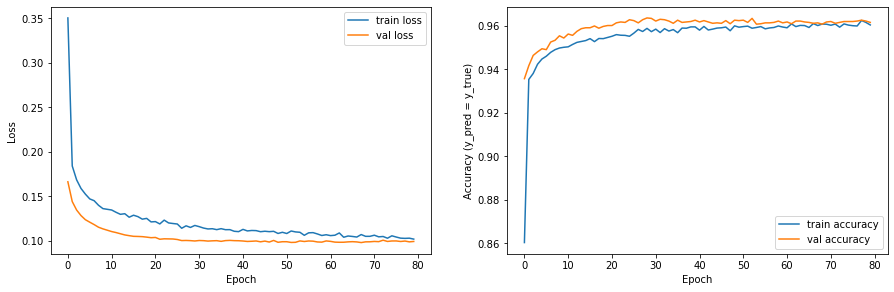

In [41]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [42]:
# count sig/bkg examples in the test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

## Test set performance plots

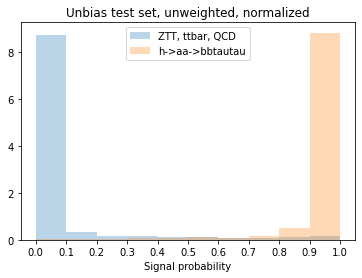

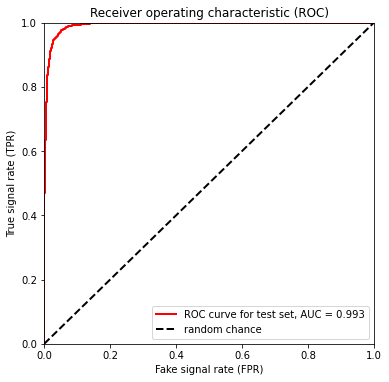

Test loss, test accuracy: [0.10282682948983926, 0.9609776139259338]


In [43]:
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'ZTT, ttbar, QCD')
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.legend(loc = 'upper center')
pyplot.title('Unbias test set, unweighted, normalized')
pyplot.xlabel('Signal probability')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Prediction on the observed data set

In [ ]:
pyplot.hist(model.predict(X_obs), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Observed data')
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'ZTT, ttbar, QCD (MC test set)', histtype = 'step')
#pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'h->aa->bbtautau (MC test set)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on observed data set, normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Write model prediction to root files

## Load all root files one by one

In [44]:
from root_numpy import array2root

infolder = 'root_raw/em18_raw/'
outfolder = 'root_outputs/em18_outputs/'

inpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths)):
    inpaths[i] = infolder + inpaths[i]
    outpaths[i] = outfolder + outpaths[i]

allfiles = []
for i in range(len(inpaths)):
    allfiles.append(ROOT.RDataFrame('emu_tree', inpaths[i]))


for i in range(len(allfiles)):
    allfiles[i] = allfiles[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1e', m_b1e)\
    .Define('m_b1mu', m_b1mu)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1e', dR_b1e)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_e', mT_e)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tt', mT_tt)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
print(len(allfiles))

46


## Data pre-processing

In [45]:
for i in range(len(allfiles)):
    allfiles[i] = pd.DataFrame(allfiles[i].AsNumpy(feature_list))
    allfiles[i] = allfiles[i].values
    allfiles[i] = scaler.transform(allfiles[i])
    print(inpaths[i])

root_raw/em18_raw/DY.root
root_raw/em18_raw/DY1.root
root_raw/em18_raw/DY2.root
root_raw/em18_raw/DY3.root
root_raw/em18_raw/DY4.root
root_raw/em18_raw/GGHTT.root
root_raw/em18_raw/GGHWW.root
root_raw/em18_raw/GGZHLLTT.root
root_raw/em18_raw/GGZHNNTT.root
root_raw/em18_raw/GGZHQQTT.root
root_raw/em18_raw/GGZHWW.root
root_raw/em18_raw/ST_tW_antitop.root
root_raw/em18_raw/ST_tW_top.root
root_raw/em18_raw/ST_t_antitop.root
root_raw/em18_raw/ST_t_top.root
root_raw/em18_raw/TTTo2L2Nu.root
root_raw/em18_raw/TTToHadronic.root
root_raw/em18_raw/TTToSemiLeptonic.root
root_raw/em18_raw/VBFHTT.root
root_raw/em18_raw/VBFHWW.root
root_raw/em18_raw/VV2L2Nu.root
root_raw/em18_raw/WZ2L2Q.root
root_raw/em18_raw/WZ3LNu.root
root_raw/em18_raw/WminusHTT.root
root_raw/em18_raw/WminusHWW.root
root_raw/em18_raw/WplusHTT.root
root_raw/em18_raw/WplusHWW.root
root_raw/em18_raw/ZHTT.root
root_raw/em18_raw/ZHWW.root
root_raw/em18_raw/ZZ2L2Q.root
root_raw/em18_raw/ZZ4L.root
root_raw/em18_raw/data_obs.root
root_raw

## Feed to NN and write outputs to root files

In [46]:
for i in range(len(allfiles)):
    y_pred = model.predict(allfiles[i])
    y_pred = np.array(y_pred, dtype = [('pred_1b', np.float32)])
    array2root(y_pred, filename = outpaths[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths[i])

root_outputs/em18_outputs/DY.root
root_outputs/em18_outputs/DY1.root
root_outputs/em18_outputs/DY2.root
root_outputs/em18_outputs/DY3.root
root_outputs/em18_outputs/DY4.root
root_outputs/em18_outputs/GGHTT.root
root_outputs/em18_outputs/GGHWW.root
root_outputs/em18_outputs/GGZHLLTT.root
root_outputs/em18_outputs/GGZHNNTT.root
root_outputs/em18_outputs/GGZHQQTT.root
root_outputs/em18_outputs/GGZHWW.root
root_outputs/em18_outputs/ST_tW_antitop.root
root_outputs/em18_outputs/ST_tW_top.root
root_outputs/em18_outputs/ST_t_antitop.root
root_outputs/em18_outputs/ST_t_top.root
root_outputs/em18_outputs/TTTo2L2Nu.root
root_outputs/em18_outputs/TTToHadronic.root
root_outputs/em18_outputs/TTToSemiLeptonic.root
root_outputs/em18_outputs/VBFHTT.root
root_outputs/em18_outputs/VBFHWW.root
root_outputs/em18_outputs/VV2L2Nu.root
root_outputs/em18_outputs/WZ2L2Q.root
root_outputs/em18_outputs/WZ3LNu.root
root_outputs/em18_outputs/WminusHTT.root
root_outputs/em18_outputs/WminusHWW.root
root_outputs/em18_